#last modified (yyyy/mm/dd): 2024/02/22

In [1]:
#Import packages
import os
import numpy as np
import pandas
import tifffile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import random
from skimage import filters, color, segmentation, measure, morphology, util, feature, draw
import cv2


INITIALIZE FUNCTIONS REQUIRED FOR THE SCRIPT

In [48]:
#INITIALIZE REQUIRED FUNCTIONS

def listdirNHF(path_1):
    """
    generates a list of the items in a directory, avoiding hidden files (hidden files are recognized because the start with a .)
    inputs: directory path
    output: list of all the items into the directory, irrespectively of the file type (folders, text, pictures etc...), without hidden files. NOTE: the order of the item in the list is the default os.listdir order
    """
    #create an initial list of items in the directory
    initial_items_list = os.listdir(path_1)

    #initialize an output list
    output_list = []
    
    #iterate through the items of the initial list
    for i in initial_items_list:

        #if the item does not start with a . (aka it is not an hidden file)
        if not i.startswith("."):

            #add the file to the output list
            output_list.append(i)

    return output_list


def gauss_kern(size, sizey=None):
    """ Returns a normalized 2D gauss kernel array for convolutions - this code is taken from scipy documentation https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html"""
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = np.mgrid[-size:size+1, -sizey:sizey+1]
    g = np.exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()


def blur_image(im, n, ny=None):
    """ blurs the image by convolving with a gaussian kernel of typical
        size n. The optional keyword argument ny allows for a different
        size in the y direction.
        This code is taken from scipy documentation https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """
    g = gauss_kern(n, sizey=ny)
    improc = scipy.signal.convolve(im,g, mode='same')
    return(improc)

def median_blur_image(imm):
    medimproc = filters.median(imm)
    return(medimproc)

def extract_smooth_timepoint_2ww(raw_timelapse, gausssmooth_sigma, bilatsmooth_parameters, embryo_mask, timepoint_2ww_n):
    #Get the raw image
    tp___im_raw = raw_timelapse[timepoint_2ww_n]
    
    # #Get the guassian smoothed image
    tp___im_gaussian = blur_image(tp___im_raw, gausssmooth_sigma, ny=None) #apply gaussian blurring
    
    #Transform raw image to type float32 before applying bilateral filtering
    tp___im_raw_f32 = util.img_as_float32(tp___im_raw)
    #Apply bilateral blurring
    tp___im_bilat = cv2.bilateralFilter(tp___im_raw_f32, bilatsmooth_parameters[0], bilatsmooth_parameters[1], bilatsmooth_parameters[2])
    
    #Get the thresholded image
    tp___im_embryo_thresh = embryo_mask[timepoint_2ww_n]

    #Get the array of the over embryo threshold pixels in the gaussian smoothed picture
    ovth_tp___im_gau_comp = tp___im_gaussian[tp___im_embryo_thresh>0]

    #Get the array of the over embryo threshold pixels in the bilateral smoothed picture
    ovth_tp___im_bil_comp = tp___im_bilat[tp___im_embryo_thresh>0]
        
    return tp___im_raw, tp___im_gaussian, tp___im_bilat, tp___im_embryo_thresh, ovth_tp___im_gau_comp, ovth_tp___im_bil_comp


def get_mode_maxperc_minperc_maxstd_minstd(image4hist, maxperc_v, minperc_v, maxstd_v, minstd_v):
    #Get picture histogram distribution
    image4hist_hist_counts, image4hist__hist_edges = np.histogram(image4hist, bins=100)

    #Get the histogram mode
    image4hist_hist_mode_pos = np.argmax(image4hist_hist_counts)
    image4hist_hist_mode_val = image4hist__hist_edges[image4hist_hist_mode_pos]

    #Get standard deviation of the intensity values histogram distribution
    histogram_ddistr_std_dv = np.std(image4hist)

    #Get a putative top threshold based on percentile
    putati_ve__max_thresh_perc = np.percentile(image4hist, maxperc_v)

    #Get a putative bottom threshold based on percentile
    putati_ve__min_thresh_perc = np.percentile(image4hist, minperc_v)

    #Get putative top threshold based on mode + N*StdDv
    putati_ve__max_thresh_stdv = image4hist_hist_mode_val+maxstd_v*histogram_ddistr_std_dv

    #Get putative bottom threshold based on mode + N*StdDv
    putati_ve__min_thresh_stdv = image4hist_hist_mode_val+minstd_v*histogram_ddistr_std_dv

    return image4hist_hist_mode_val, putati_ve__max_thresh_perc, putati_ve__min_thresh_perc, putati_ve__max_thresh_stdv, putati_ve__min_thresh_stdv


def new_get_hysteresis_based_segmentation(timelapse_with_puncta_tmpt, embryo_mask_tmpt, hyst_filt_top_perc, hyst_filt_bot_perc, hyst_filt_top_stdfactor, hyst_filt_bot_stdfactor):
    """
    returns a binary mask with brightest pixels selected based on an hystereris-filter. The top and bottom values of the hysteresis process are both, independentely, defined as follow: first it is calculated the value to use, based on an histogram percentile.
    Secondly a value is calculated by taking the mode intensity value and summing it the standard deviation of intensity values distribution, multiplied for an indicated factor. The highest of these two values is used. This process is quite robust to images with
    low signal-to-noise (the throush signal is dim or bleach and the image is almost all background).
    
    inputs: image to process as 2D numpy array (timelapse_with_puncta_tmpt). Embryo mask (binary segmentation of the embryo cytosol) as numpy array of the same shape of timelapse_with_puncta_tmpt. Percentile to use to calculate the high value of the hysteresis filtering (hyst_filt_top_perc). 
    Percentile to use to calculate the low value of the hysteresis filtering (hyst_filt_bot_perc). Number of standard deviation to sum to mode value for calculating the high value of the hysteresis filtering (hyst_filt_top_stdfactor).
    Number of standard deviation to sum to mode value for calculating the low value of the hysteresis filtering (hyst_filt_bot_stdfactor).

    output: binary segmentation of putative puncta structures as 2D numpy array of the same shape of the input image.
    """
       
    #Get the array of pixels in the median-filtered image which are in the embryo mask
    timelapse_with_puncta_tmpt_med_overembryo = timelapse_with_puncta_tmpt[embryo_mask_tmpt>0]

    #Get mode, max, min values based on percentile and standard deviantion times for gaussian and bilateral filtered images
    mode_inte_n_sit_y_val, putati_ve__top_thresh_old_i, putati_ve__bot_thresh_old_i, putati_ve__top_thresh_old_st, putati_ve__bot_thresh_old_st = get_mode_maxperc_minperc_maxstd_minstd(timelapse_with_puncta_tmpt_med_overembryo, hyst_filt_top_perc, hyst_filt_bot_perc, hyst_filt_top_stdfactor, hyst_filt_bot_stdfactor)
    
    if putati_ve__top_thresh_old_i>=putati_ve__top_thresh_old_st:
        putati_ve__top_thresh_old = putati_ve__top_thresh_old_i
    else:
        putati_ve__top_thresh_old = putati_ve__top_thresh_old_st

    ##===========
    ##===========
    ##===========
    if putati_ve__bot_thresh_old_st > putati_ve__top_thresh_old_i:
        putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_st
    else:
        if putati_ve__bot_thresh_old_i>=putati_ve__bot_thresh_old_st:
            putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_st
        else:
            putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_i

    
    # if putati_ve__bot_thresh_old_st>putati_ve__top_thresh_old_i:
    #     # putati_ve__top_thresh_old = putati_ve__top_thresh_old_st
    #     # putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_st
    #     putati_ve__top_thresh_old = putati_ve__top_thresh_old_i
    #     putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_i
    # else:
    #     # putati_ve__top_thresh_old = putati_ve__top_thresh_old_st
    #     # putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_st
    #     if putati_ve__top_thresh_old_i>=putati_ve__top_thresh_old_st:
    #         putati_ve__top_thresh_old = putati_ve__top_thresh_old_i
    #     else:
    #         putati_ve__top_thresh_old = putati_ve__top_thresh_old_st

    #     if putati_ve__bot_thresh_old_i>=putati_ve__bot_thresh_old_st:
    #         putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_i
    #     else:
    #         putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_st
    
    ###===========
    ###===========
    ###===========

    
    # Get a putative thresholded image using hysteresis based thresholding strategy using the raw image instead of the median filtered image
    timelapse_with_puncta_tmpt_hyst_thresh = filters.apply_hysteresis_threshold(timelapse_with_puncta_tmpt, low=putati_ve__bot_thresh_old, high=putati_ve__top_thresh_old)
    
    #Rescale hysteresis-based binary image on the uint8 value range
    uint8_timelapse_with_puncta_tmpt_hyst_thresh = np.where(timelapse_with_puncta_tmpt_hyst_thresh>0, 255, 0).astype(np.uint8)

    #Further remove every puncta which is detected outside the embryo
    final_filtered_img = np.where(embryo_mask_tmpt>0, uint8_timelapse_with_puncta_tmpt_hyst_thresh, 0).astype(np.uint8)
    
    return final_filtered_img


def get_frangi_based_segmentation_img_threshold(input_pict_ure1, peak_position):
    #Use Frangi filtering on the Guassian smoothed timepoint
    tmpt_2ww_frangi_img = filters.frangi(input_pict_ure1, sigmas=range(1, 5, 1), alpha=1, beta=1, gamma=1, black_ridges=False)
        
    #Calculate the histogram distribution of the intensities of the Frangi filtered image - separate the counts per histogram bin, and the edges of the bins on the histogram
    frangi_f_img_hist_counts, frangi_f_img_hist_edges = np.histogram(tmpt_2ww_frangi_img.flatten(), bins=100)
        
    #Detect at least 3 maxima in the histogram distribution
    frangi__maxima_starting_order = 10 #Inialize a value to be used for the range of maxima detection
    max_pos__frangi__hist_counts = scipy.signal.argrelmax(frangi_f_img_hist_counts, order=frangi__maxima_starting_order) #Initialize maxima detection
    while len(max_pos__frangi__hist_counts[0])<3: #Iterate detection until at least 2 maxima are detected, by progressively decreasing the range of maxima detection
        frangi__maxima_starting_order = frangi__maxima_starting_order-1
        max_pos__frangi__hist_counts = scipy.signal.argrelmax(frangi_f_img_hist_counts, order=frangi__maxima_starting_order)
        
    #Get the last (from x-axis origin) detected maxima position
    position_of_frangi_thresh = max_pos__frangi__hist_counts[0][peak_position]
        
    #get the intensity value which correspond to the last (from x-axis origin) detected maxima in the frangi-filtered histogram distribution
    frangi__threshold = frangi_f_img_hist_edges[position_of_frangi_thresh]

    return tmpt_2ww_frangi_img, frangi__threshold


def set_border_to_0(img_2changeborder):
    copy_img_2changeborder = img_2changeborder.copy()
    for brdpx in range(8):
        copy_img_2changeborder[brdpx,:] = 0
        copy_img_2changeborder[-brdpx,:] = 0
        copy_img_2changeborder[:,brdpx] = 0
        copy_img_2changeborder[:,-brdpx] = 0
    return copy_img_2changeborder


def get_frangi_based_segmentation_img(frangifiltered_input_pict_ure, threshold_frangi_val, thresholded_embryo_input):
    # Binarize the image using the Frangi-based highpass calculated threshold
    high__pass_thresh_frangi_filtered_img = np.where(frangifiltered_input_pict_ure>threshold_frangi_val, 1000, 0)
    
    # Set binary values outside the embryo to 0
    only_embryo_frangi_binary_img = np.where(thresholded_embryo_input>0, high__pass_thresh_frangi_filtered_img, 0)

    #Set border values to 0 - NOTE: this is required because Frangi-based filtering leads to the detection of the picture borders. I thouht that the step just above (Set binary values outside the embryo to 0) would have taken care of it, but it doesn't in cases where some tissue is at the border
    no_borders_only_embryo_frangi_binary_img = set_border_to_0(only_embryo_frangi_binary_img)
    
    #Rescale image in the unit8 range
    uint8_only_embryo_frangi_binary_img = np.where(no_borders_only_embryo_frangi_binary_img>0, 255, 0).astype(np.uint8)

    return uint8_only_embryo_frangi_binary_img


def combine_highpass_frangi_binary_img(highpass_input_img, frangi_input_img):
    summed_highpass_frangi_img = highpass_input_img + frangi_input_img #sum the two binary masks
    # binarized_combined_img = np.where(summed_highpass_frangi_img>0, 1000, 0).astype(np.uint8) #binarize the summed masks
    unit8_binarized_combined_img = np.where(summed_highpass_frangi_img>0, 255, 0).astype(np.uint8) #binarize the summed masks and transform the binary mask in binary format
    return unit8_binarized_combined_img


def filter_segmented_pip2_4area(input__binary__imag_e, reference_image, area_highpass_thr):
    # label image regions
    label__im_g = measure.label(input__binary__imag_e)
    
    #measure the properties of the region
    label__im_g_properties = measure.regionprops(label__im_g)

    #Initialize a zero array to be modified as output array
    out_put_arr_ay = np.zeros((reference_image.shape[0], reference_image.shape[1])).astype(np.uint8)

    #Initialize a collection list for the areas
    areas_cl = []
    
    #Iterate through the regions of the labelled image, identified using measure.regionprops
    for re_gi_on in label__im_g_properties:
        
        #Get the area of the region
        re_gion_area = re_gi_on.area

        #Add area to collection list
        areas_cl.append(re_gion_area)

        #If the region passes both area and centroid (the centroid is not very close to the outside of the embryo) thresholds modify the output array
        if re_gion_area >= area_highpass_thr:
    
            #Get region coordinates
            re_gi_on_coordinates = re_gi_on.coords
    
            #Unzip the coordinates in individual lists
            unzipped_re_gi_on_coordinates = [list(t) for t in zip(*re_gi_on_coordinates)]
            
            #Set output array values at region coordinates to 255
            out_put_arr_ay[unzipped_re_gi_on_coordinates[0], unzipped_re_gi_on_coordinates[1]] = 255
    
    return out_put_arr_ay, areas_cl


def hysteresis_filter_by_frangi_overlap(hysteresis_bin_input, frangi_bin_input, re_fer_en_ce_img):
    # label image regions
    label_hysteresis_bin_input = measure.label(hysteresis_bin_input)
    
    #measure the properties of the regions
    label_hysteresis_img_prop = measure.regionprops(label_hysteresis_bin_input)

    #Get coordinates of Frangi-based binary pixel - reorganize it to be a list of tuples
    coord_frangi_bin_input = np.argwhere(frangi_bin_input>0)
    coord_frangi_bin_input_as_list_of_tuples = [(cr_dnt[0], cr_dnt[1]) for cr_dnt in list(coord_frangi_bin_input)]

    #Initialize a zero array to be modified as output array
    output_array_filtered_hyst_img = np.zeros((re_fer_en_ce_img.shape[0], re_fer_en_ce_img.shape[1])).astype(np.uint8)

    #Iterate through the regions of the labelled image, identified using measure.regionprops
    for hyst_reg_i_on in label_hysteresis_img_prop:
    
        #Get region coordinates - reorganize it to be a list of tuples
        hyst_reg_i_on_coordinates = hyst_reg_i_on.coords
        hyst_reg_i_on_coordinates_as_listoftupl = [(cr_dnt1[0], cr_dnt1[1]) for cr_dnt1 in list(hyst_reg_i_on_coordinates)]
    
        #Get intersection of region coordinates and frangi-binary pixels coordinates
        interescion_with_frangi = list(set(hyst_reg_i_on_coordinates_as_listoftupl).intersection(set(coord_frangi_bin_input_as_list_of_tuples)))

        #If there is an intersection, add the region to the output_array_hyst_filter
        if len(interescion_with_frangi)>0:
        #Unzip the coordinates in individual lists
            unzipped_hyst_reg_i_on_coordinates = [list(tt33) for tt33 in zip(*hyst_reg_i_on_coordinates)]
        
            #Set output array values at region coordinates to 255
            output_array_filtered_hyst_img[unzipped_hyst_reg_i_on_coordinates[0], unzipped_hyst_reg_i_on_coordinates[1]] = 255
    return output_array_filtered_hyst_img


def filter_segmented_pip2_4distance(input__binary__image, thresholded__embryo_img, distance_highpass_thr):
    # label image regions
    label__img = measure.label(input__binary__image)
    
    #measure the properties of the region
    label__img_properties = measure.regionprops(label__img)

    #Get the coordinates of the outside of the embryo
    embryo_outside_coord_colX_rowY_i_i = np.argwhere(thresholded__embryo_img==0)
        
    #Transform coordinates so that they are tuples in a list
    embryo_outside_coord_colX_rowY_i = [(list(cccrd)[1], list(cccrd)[0]) for cccrd in embryo_outside_coord_colX_rowY_i_i]
    
    #Initialize a zero array to be modified as output array
    output_arr_ay = np.zeros((thresholded__embryo_img.shape[0], thresholded__embryo_img.shape[1])).astype(np.uint8)

    #Initialize a collection list for the nearest neighbor distances
    nnd_cl = []
    
    #Iterate through the regions of the labelled image, identified using measure.regionprops
    for re_gion in label__img_properties:
        
        #Get the coordinates of the outside of the embryo
        embryo_outside_coord_colX_rowY = embryo_outside_coord_colX_rowY_i

        #Get the coordinates of the centroid of the region
        cc_yy_row, cc_xx_col = re_gion.centroid
        
        # show regions whose distance from embryo outside is shorter (blue) and longer (white) than the HighPass threshold
        input_re_gion_centroid = (cc_xx_col, cc_yy_row)

        #Add centroid coordinates to the list of outside of the embryo coordinates
        embryo_outside_coord_colX_rowY_plusCC = embryo_outside_coord_colX_rowY + [input_re_gion_centroid]
        
        # Make a tree out of the outside embryo coordinates plus the centroid coordinates
        embryo_outside_coord_tree = scipy.spatial.KDTree(embryo_outside_coord_colX_rowY_plusCC)
        
        # Get the 3 closest distances (and relative indeces in the list of coordinates) to the region centroid. NOTE: the first (aka closest) distance is always the point itself with distance 0
        distance__out, result__out = embryo_outside_coord_tree.query(input_re_gion_centroid, k=3)

        #Add nearest neighbor distance to collection list
        nnd_cl = nnd_cl + list(distance__out)
        
        #If the nearest neightbor distance of the region is higher than the highpass threshold modify the output array
        if list(distance__out)[1]>distance_highpass_thr:
            
            #Get region coordinates
            re_gion_coordinates = re_gion.coords
    
            #Unzip the coordinates in individual lists
            unzipped_re_gion_coordinates = [list(t) for t in zip(*re_gion_coordinates)]
            
            #Set output array values at region coordinates to 255
            output_arr_ay[unzipped_re_gion_coordinates[0], unzipped_re_gion_coordinates[1]] = 255
    
    return output_arr_ay, nnd_cl


def subtract_2Darrays_in_unit8space(uint8_start_arr, uint8_array_to_subtract):
    #Subtract the arrays
    subtraction_array = uint8_start_arr - uint8_array_to_subtract

    #Even though it seems values are already in the 0-255 range, further binarize the image on this range and transform it to unit8
    uint8_subtraction_array = np.where(subtraction_array>0, 255, 0).astype(np.uint8)

    return uint8_subtraction_array


def detect_puncta_structures(timelapse_with_puncta_tmpt, embryo_mask_tmpt, hyst_filt_top_perc, hyst_filt_bot_perc, hyst_filt_top_stdfactor, hyst_filt_bot_stdfactor, use_raw_img_4hyst=None):
    """
    returns a binary mask with brightest pixels selected based on an hystereris-filter. The top and bottom values of the hysteresis process are both, independentely, defined as follow: first it is calculated the value to use, based on an histogram percentile.
    Secondly a value is calculated by taking the mode intensity value and summing it the standard deviation of intensity values distribution, multiplied for an indicated factor. The highest of these two values is used. This process is quite robust to images with
    low signal-to-noise (the throush signal is dim or bleach and the image is almost all background).
    
    inputs: image to process as 2D numpy array (timelapse_with_puncta_tmpt). Embryo mask (binary segmentation of the embryo cytosol) as numpy array of the same shape of timelapse_with_puncta_tmpt. Percentile to use to calculate the high value of the hysteresis filtering (hyst_filt_top_perc). 
    Percentile to use to calculate the low value of the hysteresis filtering (hyst_filt_bot_perc). Number of standard deviation to sum to mode value for calculating the high value of the hysteresis filtering (hyst_filt_top_stdfactor).
    Number of standard deviation to sum to mode value for calculating the low value of the hysteresis filtering (hyst_filt_bot_stdfactor).

    output: binary segmentation of putative puncta structures as 2D numpy array of the same shape of the input image.
    """

    #Median blurr the selected timepoint
    timelapse_with_puncta_tmpt_med = filters.median(timelapse_with_puncta_tmpt)
       
    #Get the array of pixels in the median-filtered image which are in the embryo mask
    timelapse_with_puncta_tmpt_med_overembryo = timelapse_with_puncta_tmpt_med[embryo_mask_tmpt>0]
    
    #Get picture histogram distribution
    timelapse_with_puncta_tmpt_med_overembryo_hist_counts, timelapse_with_puncta_tmpt_med_overembryo_hist_edges = np.histogram(timelapse_with_puncta_tmpt_med_overembryo, bins=35)
    
    #Get the histogram mode
    mode_posi_ti_on = np.argmax(timelapse_with_puncta_tmpt_med_overembryo_hist_counts)
    mode_inte_n_sit_y_val = timelapse_with_puncta_tmpt_med_overembryo_hist_edges[mode_posi_ti_on]

    #Get standard deviation of the intensity values histogram distribution
    histogramdistr_std_dv = np.std(timelapse_with_puncta_tmpt_med_overembryo)

    #Get a putative top threshold based on percentile
    putati_ve__top_thresh_old_i = np.percentile(timelapse_with_puncta_tmpt_med_overembryo, hyst_filt_top_perc)

    if putati_ve__top_thresh_old_i>=(mode_inte_n_sit_y_val+hyst_filt_top_stdfactor*histogramdistr_std_dv):
        putati_ve__top_thresh_old = putati_ve__top_thresh_old_i
    else:
        putati_ve__top_thresh_old = mode_inte_n_sit_y_val+hyst_filt_top_stdfactor*histogramdistr_std_dv

    #Get a putative bottom threshold based on percentile
    putati_ve__bot_thresh_old_i = np.percentile(timelapse_with_puncta_tmpt_med_overembryo, hyst_filt_bot_perc)
    
    if putati_ve__bot_thresh_old_i>=(mode_inte_n_sit_y_val+hyst_filt_bot_stdfactor*histogramdistr_std_dv):
        putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_i
    else:
        putati_ve__bot_thresh_old = mode_inte_n_sit_y_val+hyst_filt_bot_stdfactor*histogramdistr_std_dv

    if use_raw_img_4hyst!= None and use_raw_img_4hyst!= False:
        # Get a putative thresholded image using hysteresis based thresholding strategy using the raw image instead of the median filtered image
        timelapse_with_puncta_tmpt_hyst_thresh = filters.apply_hysteresis_threshold(timelapse_with_puncta_tmpt, low=putati_ve__bot_thresh_old, high=putati_ve__top_thresh_old)
        
    else:
        # Get a putative thresholded image using hysteresis based thresholding strategy using the median filtered image
        timelapse_with_puncta_tmpt_hyst_thresh = filters.apply_hysteresis_threshold(timelapse_with_puncta_tmpt_med, low=putati_ve__bot_thresh_old, high=putati_ve__top_thresh_old)
    
    #Rescale hysteresis-based binary image on the uint8 value range
    uint8_timelapse_with_puncta_tmpt_hyst_thresh = np.where(timelapse_with_puncta_tmpt_hyst_thresh>0, 255, 0).astype(np.uint8)

    #Further remove every puncta which is detected outside the embryo
    final_filtered_img = np.where(embryo_mask_tmpt>0, uint8_timelapse_with_puncta_tmpt_hyst_thresh, 0).astype(np.uint8)
    
    return final_filtered_img


print("wowowo")


wowowo


DEFINE INPUT AND OUTPUT FOLDERS - DEFINE COMMON VARIABLES FOR DIFFERENT PROCESSING PARTS

In [3]:
#indicate the input_folder and the output_folder

input_folder = r"/Users/ulivia/Desktop/Alessandro/projects/filopodia_actin_dynamics_img/fil_to_lam_transition/raw_timecourses/embryo_6"
output_folder = r"/Users/ulivia/Desktop/Alessandro/projects/filopodia_actin_dynamics_img/fil_to_lam_transition/segmented_masks/embryo_6"

#indicate target name for the imaged channels
ch1_target_name = "arx2" #Note: this channel was designed to be arx2::gfp signal - refer to transgenic strain ACR074
ch2_target_name = "cyk1" #Note: this channel was designed to be cyk1::halo + JF647 signal - refer to transgenic strain ACR074
ch3_target_name = "pip2" #Note: this channel was designed to be pip2::mcherry signal - refer to transgenic strain ACR074

#indicate saving names for the channels
ch1_sav_ing_name = "arx2_puncta"
ch2_sav_ing_name = "cyk1_puncta"
ch3_sav_ing_name = "pip2_enriched_domains"
embryo_mask_sav_ing_name = "embryo_threshold"

#Indicate the plane to process
plane_2process = 2

print("wowowo")


wowowo


In [4]:
#ORGANIZE TIMECOURSES OF EACH CHANNEL AND PLANE TO LISTS. IDENTIFY THE TIMECOURSE SPECIFIC FOR THE CORTEX. NOTE: THE IDENTIFICATION IS SIMPLY BASED ON THE FACT THAT IT SHOULD BE THE LAST IN ASCENDING ORDER


def organize_channel_timecourses(inpout_dir, ch1_trgt_name, ch2_trgt_name, ch3_trgt_name, ch1_sv_ng_name, ch2_sv_ng_name, ch3_sv_ng_name, embryo_mask_sv_ng_name):
    
    #Initialize a dictionary which links planes and fluorophores to their list of stacks
    organized_dict_out = {ch1_trgt_name:{}, ch2_trgt_name:{}, ch3_trgt_name:{}}
    
    #Get a list of the timecourses in inpout_dir
    timecourses_l = listdirNHF(inpout_dir)
    
    #Iterate through the timecourses
    for tc in timecourses_l:
    
        #After some processes, some files are generated... to avoid errors, only work on tiff files, which don't contain the channels saving names
        if (('.tif' in tc) and (ch1_sv_ng_name not in tc) and (ch2_sv_ng_name not in tc) and (ch3_sv_ng_name not in tc) and (embryo_mask_sv_ng_name not in tc)):
            
            #Get the plane of the timecourse - NOTE: for the identification of the plane number it is assumed that this is reported after the letters 'pln' in the timecourse name. It is also assumed that there are not more than 9 planes
            tc_pln = int(tc[tc.index('pln')+3:tc.index('pln')+4])

            #Open the file
            tc_f = tifffile.imread(os.path.join(inpout_dir, tc))
            
            #check if one of the target names is within the name of the timecourse. If so, link the plane and the fluorophore to the list of timepoints in the timecourse within the organized_dict
            if ch1_trgt_name in tc:
                # print("CH1", tc)
                organized_dict_out[ch1_trgt_name][tc_pln] = list(tc_f)
            elif ch2_trgt_name in tc:
                # print("CH2", tc)
                organized_dict_out[ch2_trgt_name][tc_pln] = list(tc_f)
            elif ch3_trgt_name in tc:
                # print("CH3", tc)
                organized_dict_out[ch3_trgt_name][tc_pln] = list(tc_f)
            else:
                print("some problem here")

    return organized_dict_out

organized_dict = organize_channel_timecourses(input_folder, ch1_target_name, ch2_target_name, ch3_target_name, ch1_sav_ing_name, ch2_sav_ing_name, ch3_sav_ing_name, embryo_mask_sav_ing_name)

print("wowowo")


wowowo


SEGMENTATION OF EMBRYO CYTOPLASM

In [5]:

#Select the ch3 (supposely pip2-mCherry) timecourse to process (supposely corresponding to embryo cortex)
ch3_lp_timepoints_list = organized_dict[ch3_target_name][plane_2process]


#THESE PARAMETERS COULD BE CHANGED TO REFINE THE SEGMENTATION OF THE EMBRYO - HOWEVER BY DEFAULT THEY ARE NOT SUPPOSED TO BE CHANGED

#Gaussian smoothing embryo
gau_smooth_sigma_embryo = 5 #Suggested value is 5

#The bins to use when generating the histogram of signal intensity values - this parameter is very likely not required to be changed from 100
bin_n_cell_prof = 100 #Suggested is 100

#Highpass filter area
embryo_highpass_area_threshold = 250


In [8]:
#DEFINE AREA THRESHOLD FOR Ch3 (pip2-membrane)

def get_embryo_thresholded_areas(timecourse_list_in, sigma_gaussian_smt, int_hist_bins):
    
    #Initialize a timepoint counter a dictionary to map each timepoint to its thresholds - tp_min_thresh_collection - a list to collect all thresholds calculated - tp_min_thresh_collection - and a list to collect all the gaussian smoothed timepoints - gaus_tp_collection -
    tpc = 0 #timepoint counter
    tp_thre_dict = {}
    tp_min_thresh_collection = []
    gaus_tp_collection = []
    
    #Iterate through the timepoints
    for tp in timecourse_list_in:
        # print("="*20, tpc)
        # print(tp.shape)
        #Gaussian blur the timepoint
        gauss_tp = blur_image(tp, sigma_gaussian_smt, ny=None)
        # print(gauss_tp.shape)
        #Add the gaussian smoothed timepoint to the collection list
        gaus_tp_collection.append(gauss_tp)
    
        #Flatten the gaussian smoothed timepoint image
        gauss_tp_fl = gauss_tp.flatten()
    
        #Get the histogram distribution of the flatten image
        gauss_tp_hist_counts, gauss_tp_hist_edges = np.histogram(gauss_tp_fl, bins=int_hist_bins)
    
        #Get the position of the mode value of the histogram distribution in the guassian smoothed image (the position of the intensity value with minimum counts)
        tp_mode_position = np.argmax(gauss_tp_hist_counts)
    
        #Sub-slice the histogram values to consider only the part after the mode
        gauss_tp_hist_counts_overmode = gauss_tp_hist_counts[tp_mode_position:]
    
        #Initialize an order counter
        order_count__min = 5
    
        #Get the position/index of the minima values in the sliced (over the mode) histogram distribution of the gaussian smoothed image (the position of the intensity values with minimum counts)
        min_val_hist_scipy_i = scipy.signal.argrelmin(gauss_tp_hist_counts_overmode, order=order_count__min)
        
        #while loop, decreasing the order counter until at least a minimum value is found
        while min_val_hist_scipy_i[0].shape[0]<1:
            order_count__min = order_count__min-1
            min_val_hist_scipy_i = scipy.signal.argrelmin(gauss_tp_hist_counts_overmode, order=order_count__min)
        
        # Sum the mode position to the position/index of the first (from the x axis origin) minima value in the sliced (over the mode) histogram distribution
        min_val_hist_scipy = tp_mode_position + min_val_hist_scipy_i[0][0]

        #Initialize an order counter
        order_count__max = 5
    
        #Get the position/index of the maxima values in the sliced (over the mode) histogram distribution of the gaussian smoothed image (the position of the intensity values with maximum counts)
        max_val_hist_scipy_i = scipy.signal.argrelmax(gauss_tp_hist_counts_overmode, order=order_count__max)
    
        #while loop, decreasing the order counter until at least a maxima value is found
        while max_val_hist_scipy_i[0].shape[0]<1:
            order_count__max = order_count__max-1
            max_val_hist_scipy_i = scipy.signal.argrelmax(gauss_tp_hist_counts_overmode, order=order_count__max)
        
        # Sum the mode position to the position/index of the first (from the x axis origin) maxima value in the sliced (over the mode) histogram distribution
        max_val_hist_scipy = tp_mode_position + max_val_hist_scipy_i[0][0]
    
        #Get the position/index of the minimum value in the histogram distribution of the gaussian smoothed image, when considering only the values in between the mode and the first (from x axis origin) maxima after the mode. Then sum to it the position of the mode
        min_val_hist_minbwnmaxs = tp_mode_position + np.argmin(gauss_tp_hist_counts[tp_mode_position:max_val_hist_scipy])
    
        #Get the intensity value of the first histogram minima (min_val_hist_scipy has all the positions of the minima of the histogram distribution. We take the first from the left - from the x axis origin - and check which intensity value is in that position)
        putative_threshold_min_scipy = gauss_tp_hist_edges[min_val_hist_scipy]
        
        #Get the intensity value of the histogram-minimum-in-between-the-first-two-histogram-maxima (hmbfthm)
        putative_threshold_min_minbwnmaxs = gauss_tp_hist_edges[min_val_hist_minbwnmaxs]
    
        #Get mode intensity value
        putative_mode_threshold = gauss_tp_hist_edges[tp_mode_position]
    
        # #Get the intensity value of the first (from x axis origin) sliced (over the mode) histogram maxima
        putative_max_val = gauss_tp_hist_edges[max_val_hist_scipy]
    
        #link timepoint to the calculated thresholds
        tp_thre_dict[tpc] = (putative_threshold_min_scipy, putative_threshold_min_minbwnmaxs, putative_mode_threshold, putative_max_val)
    
        #Add the intensity value of the first histogram minima and the intensity value of the histogram-minimum-in-between-the-first-two-histogram-maxima (hmbfthm) to the list collecting all min thresholds values
        tp_min_thresh_collection.append(putative_threshold_min_scipy)
        tp_min_thresh_collection.append(putative_threshold_min_minbwnmaxs)
    
        # #Update timepoint counter
        tpc = tpc+1

    
    #Calculate the median and standard deviation of all values at first histogram minima position or at histogram-minimum-in-between-the-first-two-histogram-maxima position
    median_min_thresh, std_dev_min_thresh = np.median(tp_min_thresh_collection), np.std(tp_min_thresh_collection)
    
    #Initialize a list to collect all areas of regions in the thresholded images. It will be used to form the output array
    output_embryo_areas_list = []
    
    #Initialize a counter for indexing randomly sampled timepoint to their sub-plot location
    spc = 0 #subplot counter
    
    #Iterate through the timepoints in the dictionary linking timepoints to their calculated thresholds
    for tp1 in tp_thre_dict:
        # print("========="*20)
    
        #Collect threshold value based on first histogram minima position
        put_threshold_scipy = tp_thre_dict[tp1][0]
    
        #Collect threshold value based on histogram-minimum-in-between-the-first-two-histogram-maxima position
        put_threshold_minbwnmaxs = tp_thre_dict[tp1][1]
    
        #As first option: if the threshold value based on first histogram minima position is not further than half a standard deviation from the median of thresholds - use it to threshold the timepoint image
        if ((put_threshold_scipy>(median_min_thresh-(std_dev_min_thresh/2))) and (put_threshold_scipy<(median_min_thresh+(std_dev_min_thresh/2)))):
            threshold_to_use = put_threshold_scipy
            # print("SCIPY")
    
        #As second option: if the threshold value based on histogram-minimum-in-between-the-first-two-histogram-maxima position is not further than half a standard deviation from the median of thresholds - use it to threshold the timepoint image
        elif ((put_threshold_minbwnmaxs>(median_min_thresh-(std_dev_min_thresh/2))) and (put_threshold_minbwnmaxs<(median_min_thresh+(std_dev_min_thresh/2)))):
            threshold_to_use = put_threshold_minbwnmaxs
            # print("MBTM")
    
        #As a last option: simply use the median of thresholds to threshold the timepoint image
        else:
            threshold_to_use = median_min_thresh
            # print("MEDIAN")

        #Recollect the gaussian smoothed image from the collection list rather than re-doing the smoothing
        guass_tp_img = gaus_tp_collection[tp1]
    
        #Threshold the image
        tp_threshold_min = np.where(guass_tp_img < threshold_to_use, 0.0, 10000.0)
    
        #Get areas in the thresholded embryo mask
        embryo_image_area_filtered, embryo_tmpt_area_list = filter_segmented_pip2_4area(tp_threshold_min, guass_tp_img, 0.001)

        #Add areas to output collection list
        output_embryo_areas_list = output_embryo_areas_list + embryo_tmpt_area_list

    return output_embryo_areas_list
    
#Use get_embryo_thresholded_areas function to collect all the areas in the embryo masks of timepoints in the timecourse
all_areas_embryo_masks = get_embryo_thresholded_areas(ch3_lp_timepoints_list, gau_smooth_sigma_embryo, bin_n_cell_prof)


print("wowowo")


wowowo


(array([327.,   3.,   5.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   2.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

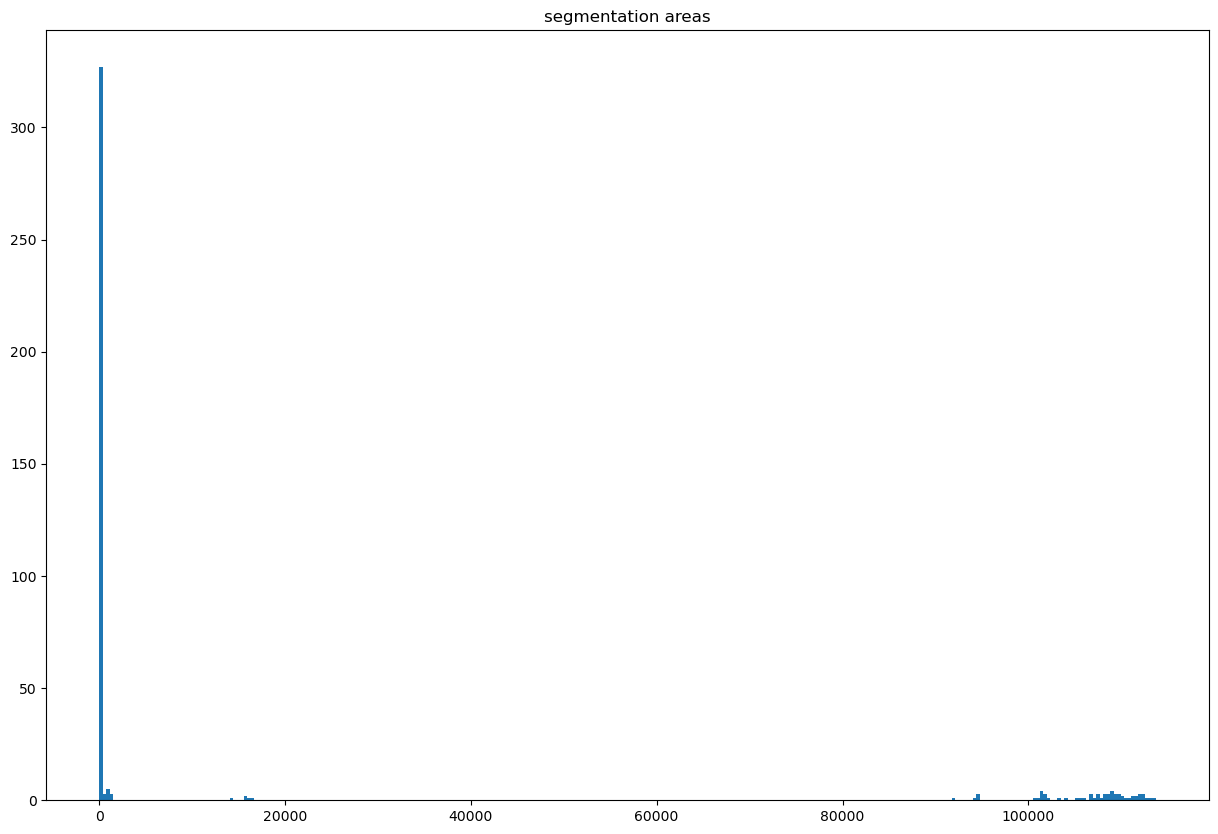

In [9]:
#Visualize the histogram distribution of embryo areas within the full timecourse
fig5000, ax5000 = plt.subplots(1,1, figsize=(15,10))
ax5000.set_title("segmentation areas")
ax5000.hist(all_areas_embryo_masks, bins=300)
# ax5000.set_xlim(-0.5, 1000) #change this line to slice the histogram graph
# ax5000.set_ylim(0, 100) #change this line to slice the histogram graph



13
50


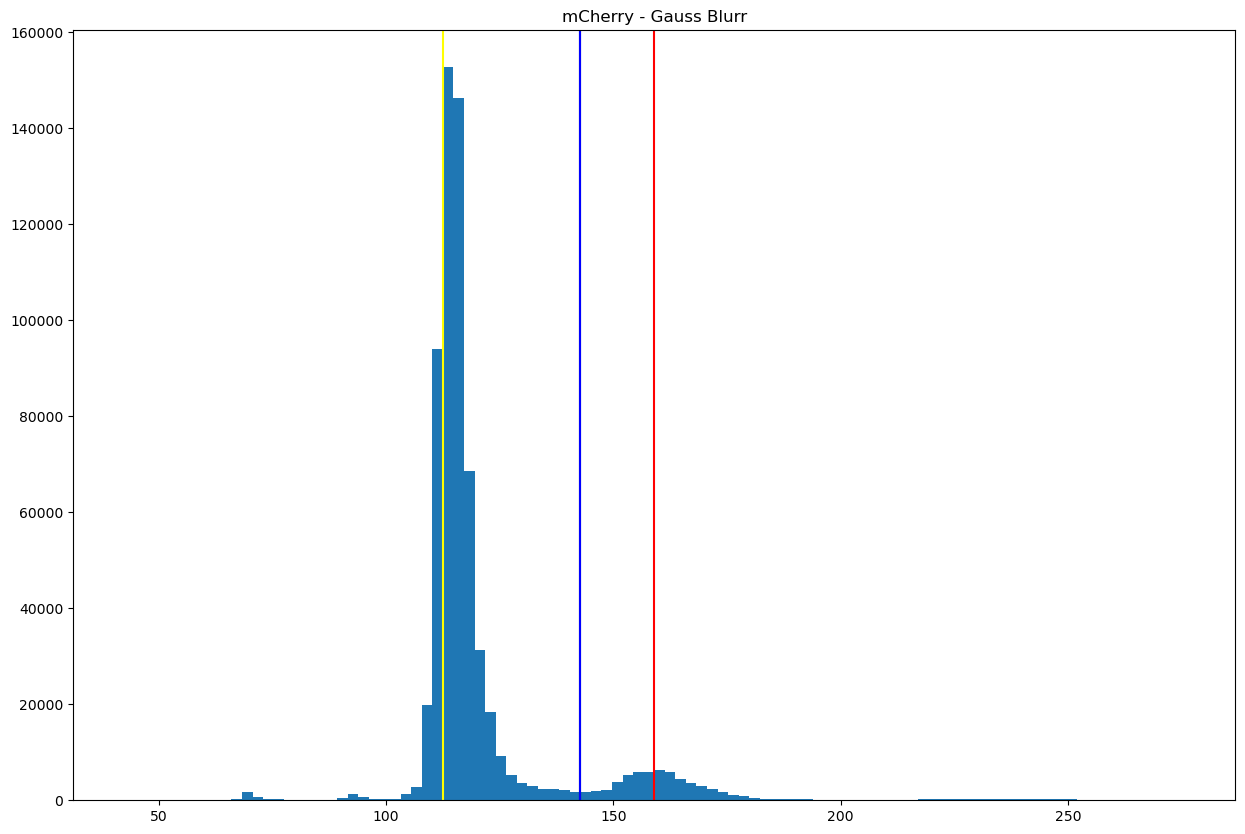

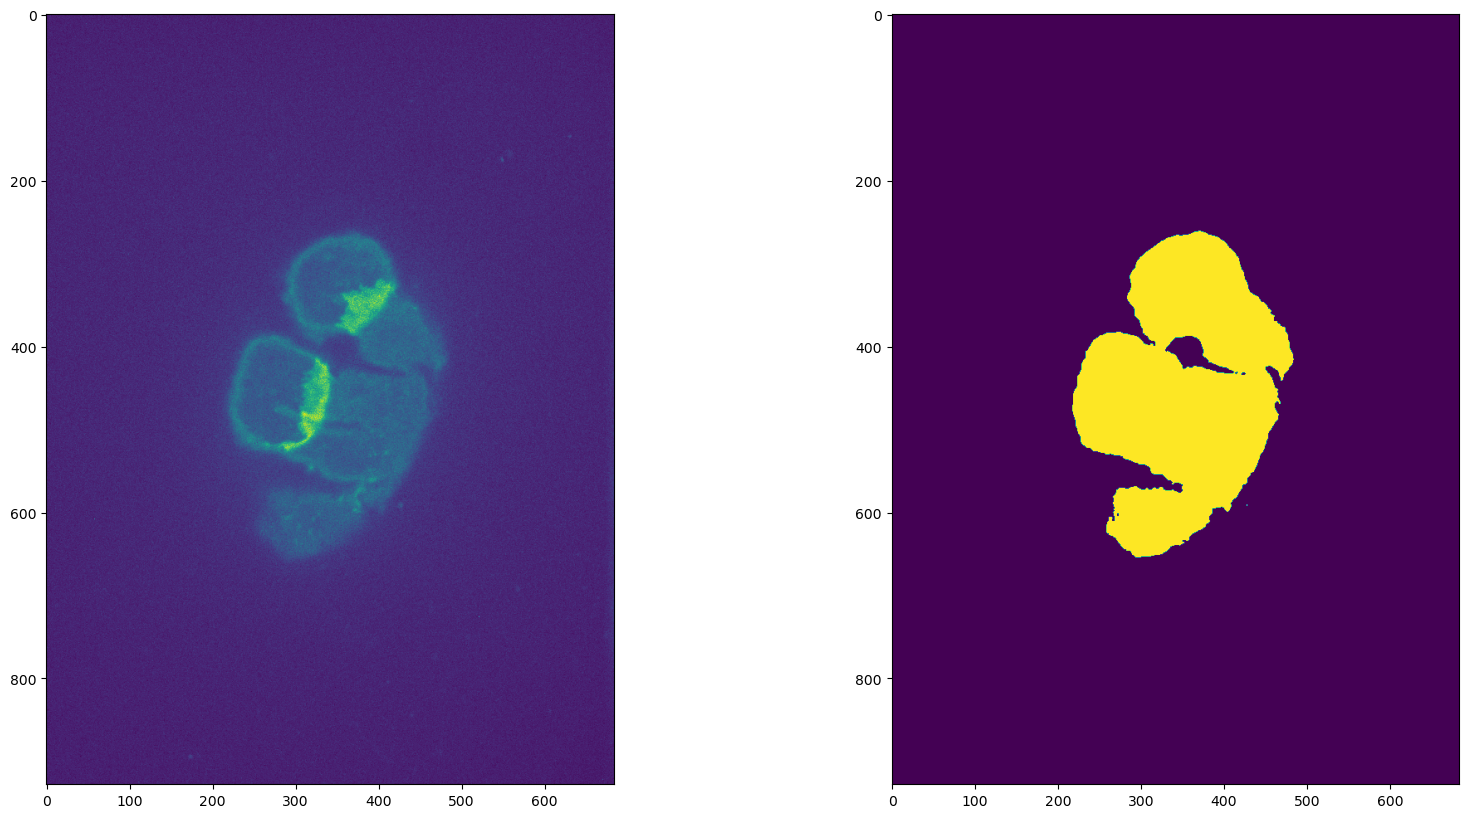

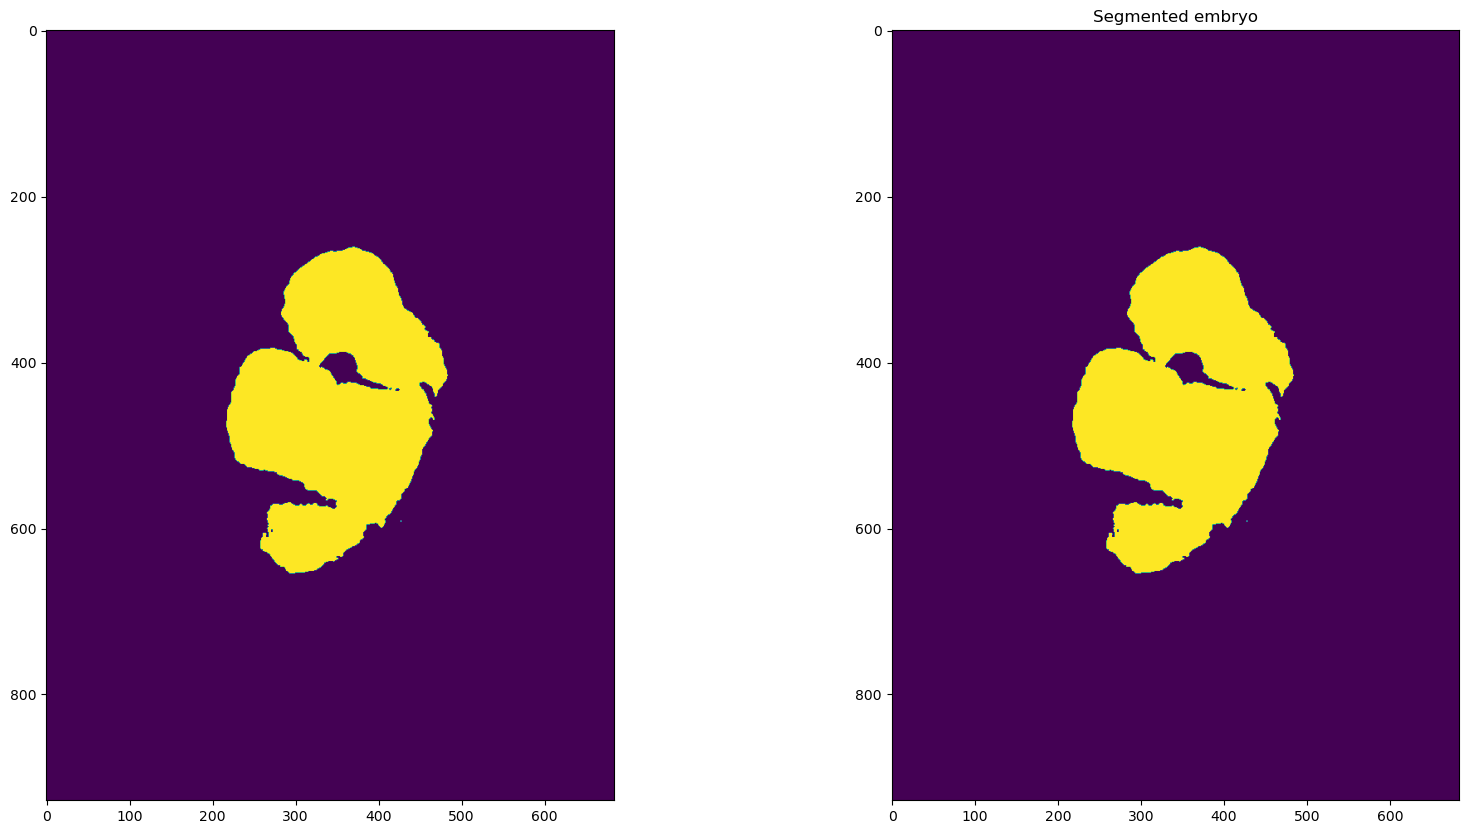

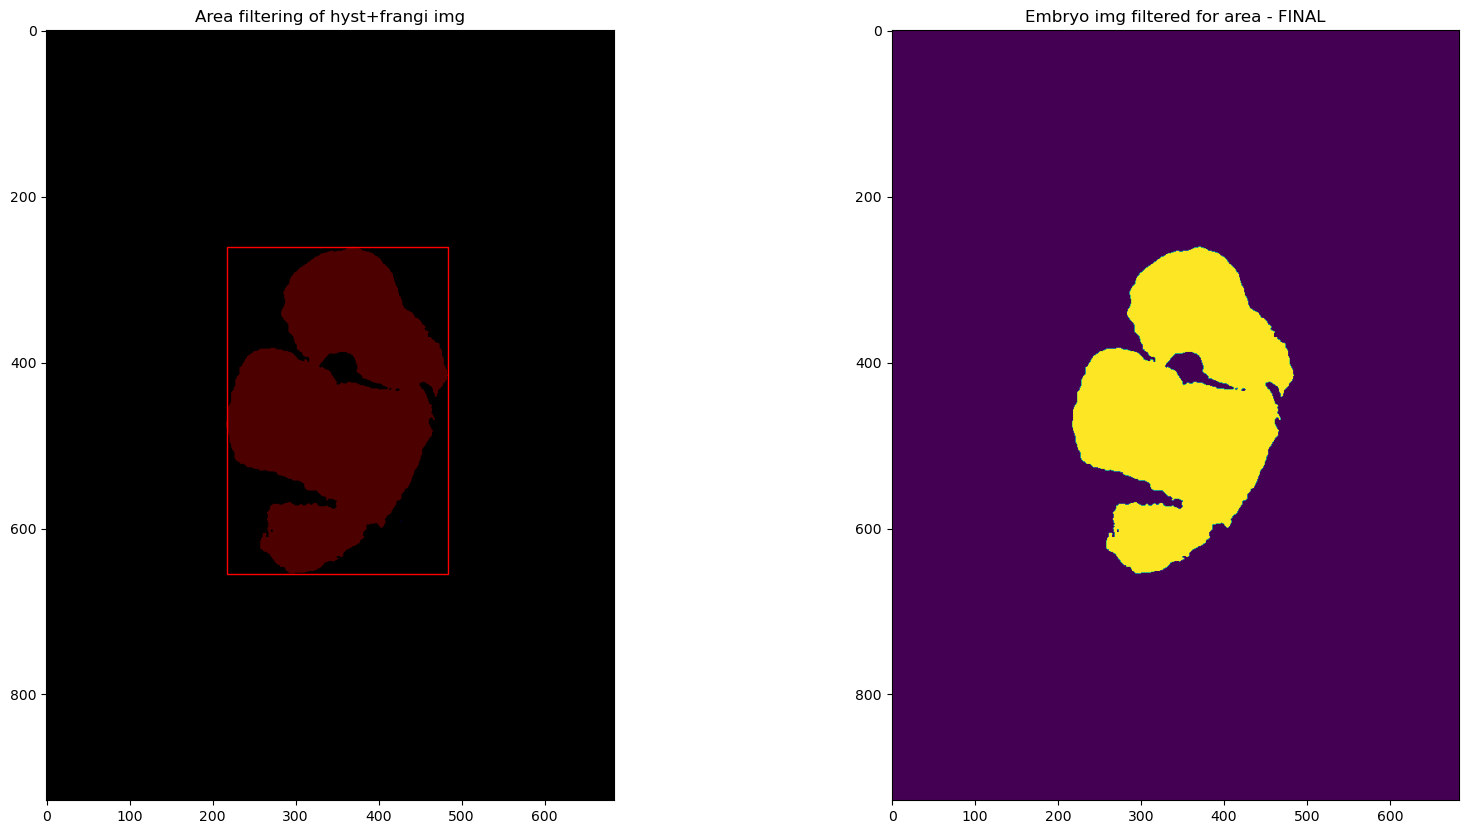

In [6]:
#THE PRESENT CELL IS HERE IF ONE WANTS TO CHECK CELL SEGMENTATION FOR INDIVUAL TIMEPOINTS OF Ch3 - pip2-mCherry
#Indicate timepoint to check
timepoint_to_check = 39

#Segment mask, if necessary - MAINTAIN SEGMENTED REGION
#======= THIS (polygon_vertices) IS THE VARIABLE TO CHANGE FOR TESTING THE POLYGON VERTICES
#Indicate a list of the polygon vertices in clock-wise order. Each vertex is indicated as [y_row, x_column] of the array. The start (the [0,0] coordinates) is top-left corner.
#If the entire image has to be kept, either leave an empty list (note: and empty list is this: [])
i_list_of_polygon_vertices = []
# i_list_of_polygon_vertices = [[320,170],[260,300],[280,510],[420,510],[500,400],[500,170]]
#======= THIS (polygon_vertices) IS THE VARIABLE TO CHANGE FOR TESTING THE POLYGON VERTICES



#Select timepoint image
tp_2_check = ch3_lp_timepoints_list[timepoint_to_check]

#Gaussian blurr the image
blurr_tp_2_check = blur_image(tp_2_check, gau_smooth_sigma_embryo, ny=None)

if len(i_list_of_polygon_vertices)>0:
    #Display the segmentation result
    polygon_____vertices = np.array(i_list_of_polygon_vertices)
    #Form a mask with the indicated vertices
    polygon_____mask = draw.polygon2mask(tp_2_check.shape, polygon_____vertices)
    #Segment the embryo, and visualize the result
    segmented_tp_2_check = np.where(polygon_____mask==True, tp_2_check, 0)
    blurr_tp_2_check_4hist = blurr_tp_2_check[segmented_tp_2_check>0]
    #Get the histogram of pixels intensities for the gaussian smoothed image
    blurr_tp_hist_counts, blurr_tp_hist_edges = np.histogram(blurr_tp_2_check_4hist, bins=bin_n_cell_prof)
        
else:
    #Get the histogram of pixels intensities for the gaussian smoothed image
    blurr_tp_hist_counts, blurr_tp_hist_edges = np.histogram(blurr_tp_2_check.flatten(), bins=bin_n_cell_prof)


# #Get the histogram of pixels intensities for the gaussian smoothed image
# blurr_tp_hist_counts, blurr_tp_hist_edges = np.histogram(blurr_tp_2_check.flatten(), bins=bin_n_cell_prof)
# # print(blurr_tp1_ch3_fl_hist_counts)

#Get the position of the mode value of the histogram distribution in the guassian smoothed image (the position of the intensity value with minimum counts)
mode_position = np.argmax(blurr_tp_hist_counts)

#Get mode intensity value
mode_threshold = blurr_tp_hist_edges[mode_position]

#Sub-slice the histogram values to consider only the part after the mode
over_mode_tp_hist_counts = blurr_tp_hist_counts[mode_position:]

#Initialize an order counter
oder_counter_min = 5
#Get the position/index of minima values in the sliced (over the mode) histogram distribution of the gaussian smoothed image (the position of the intensity values with minimum counts)
min_val_blur_v = scipy.signal.argrelmin(over_mode_tp_hist_counts, order=oder_counter_min)
# print(min_val_blur_v[0].shape)
#while loop, decreasing the order counter until at least a minimum value is fount
while min_val_blur_v[0].shape[0]<1:
    min_val_blur_v = scipy.signal.argrelmin(over_mode_tp_hist_counts, order=oder_counter_min)
    oder_counter_min = oder_counter_min-1
print(min_val_blur_v[0][0])

#Get the intensity value of the first histogram minima (min_val_blur_v has all the positions of the minima of the histogram distribution. We take the first from the left - from the x axis origin - and check which intensity value is in that position)
#NOTE: the decision to take the first minimum (from x axis origin) of the histogram distribution as threshold is based on former analyses of the mCherry histogram distribution, which are not anymore included in this pipeline,
#These analyses indicated that such value separates the imaging field background from the embryo volume
threshold_min = blurr_tp_hist_edges[mode_position + min_val_blur_v[0][0]]
# print(threshold_min)

#Initialize an order counter
order_counter_max = 5
# #Get the position/index of maxima values in the sliced (over the mode) histogram distribution of the gaussian smoothed image (the position of the intensity values with maximum counts)
max_val_blur_v_i = scipy.signal.argrelmax(over_mode_tp_hist_counts, order=order_counter_max)
#while loop, decreasing the order counter until at least a maximum value is fount
while max_val_blur_v_i[0].shape[0]<1:
    max_val_blur_v_i = scipy.signal.argrelmin(over_mode_tp_hist_counts, order=order_counter_max)
    order_counter_max = order_counter_max-1

# #Get the position/index of maxima values in the sliced (over the mode) histogram distribution of the gaussian smoothed image (the position of the intensity values with maximum counts)
max_val_blur_v = mode_position + max_val_blur_v_i[0][0]
print(max_val_blur_v)

# # #Get the intensity value of the first (from x axis origin) maxima in the sliced (over the mode) histogram distribution (max_val_blur_v has all the positions of the maxima of the histogram distribution. We take the first from the left - from the x axis origin - and check which intensity value is in that position)
threshold_max = blurr_tp_hist_edges[max_val_blur_v]
# # threshold_max_2 = blurr_tp_hist_edges[max_val_blur_v[0][3]]

# # #Get the position/index of minima values in the histogram distribution of the gaussian smoothed image, when considering only the values in between the mode and first maxima after the mode. Then sum to it the position of the mode
min_hist_val_2 = mode_position + np.argmin(blurr_tp_hist_counts[mode_position:max_val_blur_v])
# # print(min_hist_val_2)

# # #Get the intensity value of the histogram-minimum-in-between-the-first-two-histogram-maxima (hmbfthm)
threshold_min_2 = blurr_tp_hist_edges[min_hist_val_2]

#Plot the result
fig1, ax1 = plt.subplots(1,1, figsize=(15,10))
# ax1.set_xlim(115, 130) #change this line to slice the histogram graph
# ax1.set_ylim(0, 10000) #change this line to slice the histogram graph
ax1.set_title("mCherry - Gauss Blurr")
ax1.hist(blurr_tp_2_check.flatten(), bins=bin_n_cell_prof)
ax1.axvline(x=threshold_min, color="black")
ax1.axvline(x=threshold_max, color="red")
# ax1.axvline(x=threshold_max_2, color="red")
ax1.axvline(x=threshold_min_2, color="blue")
ax1.axvline(x=mode_threshold, color="yellow")

#Threshold the blurred image timepoint - NOTE: YOU HAVE TO MODIFY THE THRESHOLD TO SELECT WHAT TO VISUALIZE
threshold_min_tp_ch3 = np.where(blurr_tp_2_check < threshold_min, 0.0, 1000)
# threshold_min_tp_ch3 = np.where(blurr_tp_2_check < 125, 0.0, 1000)
# threshold_min_tp_ch3 = np.where(blurr_tp_2_check < threshold_min_2, 0.0, 1000)

#Show the thresholded image an the original timepoint
fig2, ax2 = plt.subplots(1,2, figsize=(20,10))
ax2[0].imshow(tp_2_check)
ax2[1].imshow(threshold_min_tp_ch3)

fig3, ax3 = plt.subplots(1,2, figsize=(20,10))
if ((i_list_of_polygon_vertices != None) and (len(i_list_of_polygon_vertices)>0)):
    #Display the segmentation result
    poly_gon_____verti_ces = np.array(i_list_of_polygon_vertices)
    #Form a mask with the indicated vertices
    poly_gon_____mas_k = draw.polygon2mask(tp_2_check.shape, poly_gon_____verti_ces)
    #Form a matplotlib patch, to visualize the result
    pol_patch = plt.Polygon([[x[1], x[0]] for x in list(poly_gon_____verti_ces)], fill=False, edgecolor='blue', linewidth=1)
    #Segment the embryo, and visualize the result
    segmented_out_put_arr_ay = np.where(poly_gon_____mas_k==True, threshold_min_tp_ch3, 0)
    ax3[0].imshow(threshold_min_tp_ch3)
    ax3[0].add_patch(pol_patch)
    ax3[1].set_title("Segmented embryo")
    ax3[1].imshow(segmented_out_put_arr_ay)
        
else:
    #Segment the embryo, and visualize the result
    segmented_out_put_arr_ay = threshold_min_tp_ch3
    ax3[0].imshow(threshold_min_tp_ch3)
    ax3[1].set_title("Segmented embryo")
    ax3[1].imshow(segmented_out_put_arr_ay)


def filter_segmented_pip2_4area_wp(input__binary__imag_e, reference_image, area_highpass_thr):
    # label image regions
    label__im_g = measure.label(input__binary__imag_e)
    
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    new_image_label_over_lay = color.label2rgb(label__im_g, image=reference_image, bg_label=0)
    
    #measure the properties of the region
    label__im_g_properties = measure.regionprops(label__im_g)
    fig3012, ax3012 = plt.subplots(1,2, figsize=(20,10))
    ax3012[0].set_title("Area filtering of hyst+frangi img")
    ax3012[0].imshow(new_image_label_over_lay)
    
    #Initialize a zero array to be modified as output array
    out_put_arr_ay = np.zeros((reference_image.shape[0], reference_image.shape[1])).astype(np.uint8)
    #Initialize a collection list for the areas
    areas_cl = []
    #Iterate through the regions of the labelled image, identified using measure.regionprops
    for re_gi_on in label__im_g_properties:
        
        #Get the area of the region
        re_gion_area = re_gi_on.area

        #Add area to collection list
        areas_cl.append(re_gion_area)
        
        #If the region passes both area and centroid (the centroid is not very close to the outside of the embryo) thresholds modify the output array
        if re_gion_area >= area_highpass_thr:
    
            #Get region coordinates
            re_gi_on_coordinates = re_gi_on.coords
    
            #Unzip the coordinates in individual lists
            unzipped_re_gi_on_coordinates = [list(t) for t in zip(*re_gi_on_coordinates)]

            #Add rectangle patch to identify the kept region
            rectangl_patch = plt.Rectangle((re_gi_on.bbox[1],re_gi_on.bbox[0]), width=abs(re_gi_on.bbox[3]-re_gi_on.bbox[1]), height=abs(re_gi_on.bbox[2]-re_gi_on.bbox[0]), color='red', fill=False)
            ax3012[0].add_patch(rectangl_patch)
            
            #Set output array values at region coordinates to 255
            out_put_arr_ay[unzipped_re_gi_on_coordinates[0], unzipped_re_gi_on_coordinates[1]] = 255

            ax3012[1].set_title("Embryo img filtered for area - FINAL")
            ax3012[1].imshow(out_put_arr_ay)



filter_segmented_pip2_4area_wp(segmented_out_put_arr_ay, tp_2_check, embryo_highpass_area_threshold)




wowowo


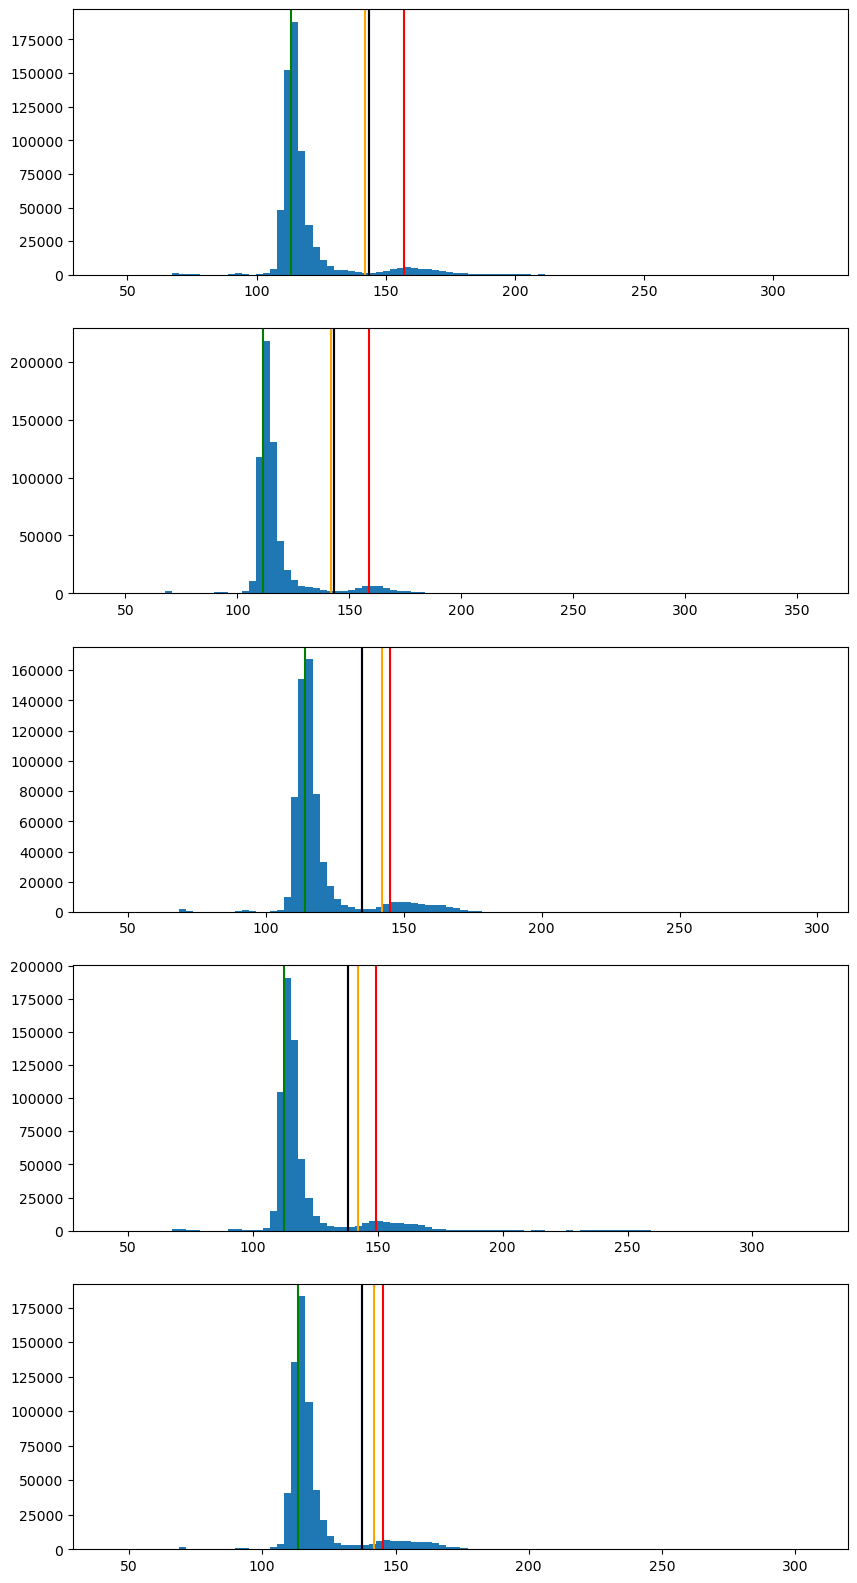

In [7]:
#THRESHOLD ALL THE TIMEPOINTS FOR THE Ch3 (pip2-membrane)

def mask_embryo(timecourse_list_in, saving_path, name_structure, plane_position, sigma_gaussian_smt, int_hist_bins, embr_mask_sv_ng_name, area_threshold4embryo, list_of_polygon_vertices=None):
    #Initialize an image to plot the histogram results
    fig3, ax3 = plt.subplots(len(timecourse_list_in)//12,1, figsize=(10,20))
    
    #Randomily select some timepoint to plot
    random_timepoints = random.sample(range(len(timecourse_list_in)), k=len(timecourse_list_in)//12)
    
    #Initialize a timepoint counter a dictionary to map each timepoint to its thresholds - tp_min_thresh_collection - a list to collect all thresholds calculated - tp_min_thresh_collection - and a list to collect all the gaussian smoothed timepoints - gaus_tp_collection -
    tpc = 0 #timepoint counter
    tp_thre_dict = {}
    tp_min_thresh_collection = []
    gaus_tp_collection = []

    #Iterate through the timepoints
    for tp in timecourse_list_in:
        # print("="*20, tpc)
        # print(tp.shape)
        #Gaussian blur the timepoint
        gauss_tp = blur_image(tp, sigma_gaussian_smt, ny=None)
        # print(gauss_tp.shape)
        #Add the gaussian smoothed timepoint to the collection list
        gaus_tp_collection.append(gauss_tp)

        if (list_of_polygon_vertices!=None) and (len(list_of_polygon_vertices)>0):
            #Display the segmentation result
            poly__gon_____verti__ces = np.array(list_of_polygon_vertices)
            #Form a mask with the indicated vertices
            poly__gon_____mas__k = draw.polygon2mask(tp.shape, poly__gon_____verti__ces)
            #Segment the embryo, and visualize the result
            seg_men_ted_tp = np.where(poly__gon_____mas__k==True, tp, 0)
            segmented_gauss_tp = gauss_tp[seg_men_ted_tp>0]
            #Get the histogram distribution of the flatten image
            gauss_tp_hist_counts, gauss_tp_hist_edges = np.histogram(segmented_gauss_tp, bins=int_hist_bins)
                
        else:
        
            #Flatten the gaussian smoothed timepoint image
            gauss_tp_fl = gauss_tp.flatten()
    
            #Get the histogram distribution of the flatten image
            gauss_tp_hist_counts, gauss_tp_hist_edges = np.histogram(gauss_tp_fl, bins=int_hist_bins)
        
        #Get the position of the mode value of the histogram distribution in the guassian smoothed image (the position of the intensity value with minimum counts)
        tp_mode_position = np.argmax(gauss_tp_hist_counts)
    
        #Sub-slice the histogram values to consider only the part after the mode
        gauss_tp_hist_counts_overmode = gauss_tp_hist_counts[tp_mode_position:]
    
        #Initialize an order counter
        order_count__min = 5
    
        #Get the position/index of the minima values in the sliced (over the mode) histogram distribution of the gaussian smoothed image (the position of the intensity values with minimum counts)
        min_val_hist_scipy_i = scipy.signal.argrelmin(gauss_tp_hist_counts_overmode, order=order_count__min)
        
        #while loop, decreasing the order counter until at least a minimum value is found
        while min_val_hist_scipy_i[0].shape[0]<1:
            order_count__min = order_count__min-1
            min_val_hist_scipy_i = scipy.signal.argrelmin(gauss_tp_hist_counts_overmode, order=order_count__min)
        
        # Sum the mode position to the position/index of the first (from the x axis origin) minima value in the sliced (over the mode) histogram distribution
        min_val_hist_scipy = tp_mode_position + min_val_hist_scipy_i[0][0]

        #Initialize an order counter
        order_count__max = 5
    
        #Get the position/index of the maxima values in the sliced (over the mode) histogram distribution of the gaussian smoothed image (the position of the intensity values with maximum counts)
        max_val_hist_scipy_i = scipy.signal.argrelmax(gauss_tp_hist_counts_overmode, order=order_count__max)
    
        #while loop, decreasing the order counter until at least a maxima value is found
        while max_val_hist_scipy_i[0].shape[0]<1:
            order_count__max = order_count__max-1
            max_val_hist_scipy_i = scipy.signal.argrelmax(gauss_tp_hist_counts_overmode, order=order_count__max)
        
        # Sum the mode position to the position/index of the first (from the x axis origin) maxima value in the sliced (over the mode) histogram distribution
        max_val_hist_scipy = tp_mode_position + max_val_hist_scipy_i[0][0]
    
        #Get the position/index of the minimum value in the histogram distribution of the gaussian smoothed image, when considering only the values in between the mode and the first (from x axis origin) maxima after the mode. Then sum to it the position of the mode
        min_val_hist_minbwnmaxs = tp_mode_position + np.argmin(gauss_tp_hist_counts[tp_mode_position:max_val_hist_scipy])
    
        #Get the intensity value of the first histogram minima (min_val_hist_scipy has all the positions of the minima of the histogram distribution. We take the first from the left - from the x axis origin - and check which intensity value is in that position)
        putative_threshold_min_scipy = gauss_tp_hist_edges[min_val_hist_scipy]
        
        #Get the intensity value of the histogram-minimum-in-between-the-first-two-histogram-maxima (hmbfthm)
        putative_threshold_min_minbwnmaxs = gauss_tp_hist_edges[min_val_hist_minbwnmaxs]
    
        #Get mode intensity value
        putative_mode_threshold = gauss_tp_hist_edges[tp_mode_position]
    
        # #Get the intensity value of the first (from x axis origin) sliced (over the mode) histogram maxima
        putative_max_val = gauss_tp_hist_edges[max_val_hist_scipy]
    
        #link timepoint to the calculated thresholds
        tp_thre_dict[tpc] = (putative_threshold_min_scipy, putative_threshold_min_minbwnmaxs, putative_mode_threshold, putative_max_val)
    
        #Add the intensity value of the first histogram minima and the intensity value of the histogram-minimum-in-between-the-first-two-histogram-maxima (hmbfthm) to the list collecting all min thresholds values
        tp_min_thresh_collection.append(putative_threshold_min_scipy)
        tp_min_thresh_collection.append(putative_threshold_min_minbwnmaxs)
    
        # #Update timepoint counter
        tpc = tpc+1

    
    #Calculate the median and standard deviation of all values at first histogram minima position or at histogram-minimum-in-between-the-first-two-histogram-maxima position
    median_min_thresh, std_dev_min_thresh = np.median(tp_min_thresh_collection), np.std(tp_min_thresh_collection)
    
    #Initialize a list to collect all thresholded images. It will be used to form the output array
    tp_list = []
    
    #Initialize a counter for indexing randomly sampled timepoint to their sub-plot location
    spc = 0 #subplot counter
    
    #Iterate through the timepoints in the dictionary linking timepoints to their calculated thresholds
    for tp1 in tp_thre_dict:
        # print("========="*20)
    
        #Collect threshold value based on first histogram minima position
        put_threshold_scipy = tp_thre_dict[tp1][0]
    
        #Collect threshold value based on histogram-minimum-in-between-the-first-two-histogram-maxima position
        put_threshold_minbwnmaxs = tp_thre_dict[tp1][1]
    
        #As first option: if the threshold value based on first histogram minima position is not further than half a standard deviation from the median of thresholds - use it to threshold the timepoint image
        if ((put_threshold_scipy>(median_min_thresh-(std_dev_min_thresh/2))) and (put_threshold_scipy<(median_min_thresh+(std_dev_min_thresh/2)))):
            threshold_to_use = put_threshold_scipy
            # print("SCIPY")
    
        #As second option: if the threshold value based on histogram-minimum-in-between-the-first-two-histogram-maxima position is not further than half a standard deviation from the median of thresholds - use it to threshold the timepoint image
        elif ((put_threshold_minbwnmaxs>(median_min_thresh-(std_dev_min_thresh/2))) and (put_threshold_minbwnmaxs<(median_min_thresh+(std_dev_min_thresh/2)))):
            threshold_to_use = put_threshold_minbwnmaxs
            # print("MBTM")
    
        #As a last option: simply use the median of thresholds to threshold the timepoint image
        else:
            threshold_to_use = median_min_thresh
            # print("MEDIAN")

        #Recollect the gaussian smoothed image from the collection list rather than re-doing the smoothing
        guass_tp_img = gaus_tp_collection[tp1]
    
        #Threshold the image
        tp_threshold_min = np.where(guass_tp_img < threshold_to_use, 0.0, 10000.0)


        #Segment the embryo mask on a polygon, if required
        if ((list_of_polygon_vertices != None) and (len(list_of_polygon_vertices)>0)):
            #Get poligon vertices as an array
            polygon_____vertices2segment = np.array(list_of_polygon_vertices)
            #Form a mask with the indicated vertices
            polygon_____mask2segment = draw.polygon2mask(guass_tp_img.shape, polygon_____vertices2segment)
            #Segment the embryo, and visualize the result
            polygon_segmented_out_put_arr_ay = np.where(polygon_____mask2segment==True, tp_threshold_min, 0)
        
        else:
            #Segment the embryo, and visualize the result
            polygon_segmented_out_put_arr_ay = tp_threshold_min

        
        #Get areas in the thresholded embryo mask
        embryo_image_area___filtered, embryo_tmpt_area___list = filter_segmented_pip2_4area(polygon_segmented_out_put_arr_ay, guass_tp_img, area_threshold4embryo)
        
        #Append the thresholded image to respective collection list
        tp_list.append(embryo_image_area___filtered)
    
        #If the timepoint has been randomly selected, plot its intensities histogram and calculated thresholds
        if tp1 in random_timepoints:
            ax3[spc].hist(guass_tp_img.flatten(), bins=int_hist_bins)
            ax3[spc].axvline(x=put_threshold_minbwnmaxs, color="blue")
            ax3[spc].axvline(x=put_threshold_scipy, color="black")
            ax3[spc].axvline(x=median_min_thresh, color="orange")
            ax3[spc].axvline(x=tp_thre_dict[tp1][2], color="green")
            ax3[spc].axvline(x=tp_thre_dict[tp1][3], color="red")
            spc = spc+1
    
    #Use the list collecting all thresholded timepoints to form a final array
    tp_arr = np.asarray(tp_list).astype(np.uint16)
    
    #Save the final array
    tp_thre_saving_name = str(embr_mask_sv_ng_name)+"_"+str(name_structure)+"_pln"+str(plane_position)+".tif"
    
    # Save files - uncomment these lines to save the files
    tifffile.imwrite(os.path.join(saving_path, tp_thre_saving_name), tp_arr, photometric='minisblack')


#Indicate the vertices of the area to segment, if required
# embryo_region_list_of_polygon_vertices = [[320,170],[260,300],[280,510],[420,510],[500,400],[500,170]]

#Use mask_embryo on ch3 (pip2-mCherry, cortex plane) to get the mask of the embryo.
#Note that the name of the structure labelled (pip2) and plane imaged (the cortex is assumed to be the last imaged plane in each timepoint's stack) are asked as inputs in the function. The are respectively ch3_target_name, plane_2process
#Also note that it is possible to change the extent of gaussian smoothing which is done to the image during the processing and the amounts of bins of the histogram used to calculate the thresholds. These parameters, respectively gau_smooth_sigma_embryo, bin_n_cell_prof,
#can be changed at the beginning of the "EMBRYO SEGMENTATION" section. However supposely they should not

mask_embryo(ch3_lp_timepoints_list, output_folder, ch3_target_name, plane_2process, gau_smooth_sigma_embryo, bin_n_cell_prof, embryo_mask_sav_ing_name, embryo_highpass_area_threshold)
# mask_embryo(ch3_lp_timepoints_list, output_folder, ch3_target_name, plane_2process, gau_smooth_sigma_embryo, bin_n_cell_prof, embryo_mask_sav_ing_name, embryo_highpass_area_threshold, embryo_region_list_of_polygon_vertices)


print("wowowo")


SEGMENTATION OF PiP2 ENRICHED MEMBRANE DOMAINS - NOTE: some aspects of the process could be fastened by non-re-running already calculated elements. However re-running them allows to maintain the section modulare, so that it could be performed without having runned the "EMBRYO SEGMENTATION" part

In [8]:
#Import ch3 timelapse and the embryo-thresholded images - re-form the gaussian smoothed timecourse

#Get a list of the files in the input_ and output_ folders
list_inp_files = listdirNHF(input_folder)
list_out_files = listdirNHF(output_folder)

#Get the name of the ch3 timecourse (supposely pip2-mCherry) for the target plane to process (supposely the embryo cortex)
ch3_name_2target = [f for f in list_inp_files if ((ch3_target_name in f) and (("pln"+str(plane_2process)) in f) and (ch1_sav_ing_name not in f) and (ch2_sav_ing_name not in f) and (ch3_sav_ing_name not in f) and (embryo_mask_sav_ing_name not in f))][0]
# Get the name of the embryo segmented mask for the target plane timecourse
ch3_embryo_target_name = [f2 for f2 in list_out_files if ((embryo_mask_sav_ing_name in f2) and (("pln"+str(plane_2process)) in f2))][0]
# print(ch3_name_2target)
# print(ch3_embryo_target_name)

#Create the directories of the channel-3 (pip2-mCherry) and embryo-thresholded files
ch3_timelapse_dir = os.path.join(input_folder, ch3_name_2target)
ch3_threshold_dir = os.path.join(output_folder, ch3_embryo_target_name)

#Open channel-3 (pip2-mCherry) and embryo-thresholded files
ch3_timalapse_img = tifffile.imread(ch3_timelapse_dir)
print(ch3_timalapse_img.shape)
ch3_threshold_img = tifffile.imread(ch3_threshold_dir)
print(ch3_threshold_img.shape)

print("wowowo")


(61, 928, 684)
(61, 928, 684)
wowowo


In [51]:
#DEFINE PARAMETERS FOR SEGMENTATION - NOTE: THESE PARAMETERS CAN SLIGHTLY CHANGE FOR DIFFERENTLY ACQUIRED SAMPLES BUT IN GENERAL IT IS POSSIBLE TO JUST LEAVE THEM LIKE THIS

#Gaussian smoothing pip2-enriched domains - the number changes between 0.1 and infinite. The higher the number the less sharper (but also potentially noisier) the segmentation
gau_smooth_sigma_fil = 5 #recommended 5 -------- 3 for Gregoire's images

#Bilateral filering pip2-enriched domains
bil_smooth_diameter = 4
bil_smooth_sigma_color = 20 
bil_smooth_sigma_space = 3

#Frangi filtering strictness for pip2-enriched domains's detection - this is a negative value ranging from -1 to... hard to exactely define, I would probably not go further then -3 or -4.
#It defines how strict or loose the process is in finding edges (contours of pip2-enriched domains). For sharp signals values lower than -1 could lead to aspecific structures segmentations.
#However for blurred images where signal to noise ratio is not good, -1 might be too strict leading practically to segmenting no structures.
frangi_filter_peak_position = -1  #recommended -1 -------- -3 for Gregoire's images

#Hysteresis detection parameters
pip2_top_percentile_hyst_filt = 99 #percentile to use for calculating the high value to be passed to hysteresis filtering - suggested 99
pip2_bot_percentile_hyst_filt = 98 #percentile to use for calculating the low value to be passed to hysteresis filtering - suggested 97-98
pip2_top_stdv_multfactor_hyst_filt = 3.9 #how many standard deviations to sum to the mode of the intensity distribution, for calculating the high value to be passed to hysteresis filtering - suggested 3.9
pip2_bot_stdv_multfactor_hyst_filt = 2.8 #how many standard deviations to sum to the mode of the intensity distribution, for calculating the low value to be passed to hysteresis filtering - suggested 2.8

#Highpass area threshold - regions smaller than this area will be removed
highpass_area_threshold = 5 #Indicate the threshold in pixels: smaller filopodia will be excluded. The histogram above should have a huge peak at the very beginning comprising 1 or more bins. The recommended threshold should be in the middle of this peak, a bit towards to higher value side.
#Highpass distance threshold - regions whose centroid is closer to the outside of the embryo than this distance will be removed
highpass_distance_threshold = 5 #Indicate the threshold (this unfortunately is arbitrary units, but based on above distances histogram): filopodia whose distance from the outside of the embryo is shorter than the threshold will be excluded. The histogram above should have at least 2 peaks. The recommended threshold should be just before the first of these peaks

print("wowowo")


wowowo


In [16]:
#Plot the histogram distribution of the area of the detected pip2-enriched domains as well as their distances from the outside of the embryo

areas_collection_list = []
shortdist_collection_list = []


for itrtn in range(len(ch3_timalapse_img)):
    
    #Use extract_timepoint_2ww_wp to get the raw image, the gaussian smoothed image, the bilateral filtered image, the embryo thresholded mask, the values of the pixels within the embryo mask of the gaussian smoothed and bilateral filtered images, for the current timepoint
    t_p___im_raw, t_p___im_gaussian, t_p___im_bilateral, t_p___im_embryo_thresh, ovth_t_p___im_gauss, ovth_t_p___im_bilat = extract_smooth_timepoint_2ww(ch3_timalapse_img, gau_smooth_sigma_fil, (bil_smooth_diameter, bil_smooth_sigma_color, bil_smooth_sigma_space), ch3_threshold_img, itrtn)

    
    #======== HYSTERESIS-BASED FILTERING
    #Get hysteresis based segmented segmented timepoints for the gaussian blurred and the bilater blurred images
    puta_tive_threshold_img_hyst = new_get_hysteresis_based_segmentation(t_p___im_gaussian, t_p___im_embryo_thresh, pip2_top_percentile_hyst_filt, pip2_bot_percentile_hyst_filt, pip2_top_stdv_multfactor_hyst_filt, pip2_bot_stdv_multfactor_hyst_filt)

    
    #======== FRANGI-BASED FILTERING
    #Get Frangi-filtered image and Frangi putative threshold
    t_p__2ww_frangi_img, t_p__2ww_frangi_thresh = get_frangi_based_segmentation_img_threshold(util.img_as_int(t_p___im_bilateral), frangi_filter_peak_position)

    #Get putative thresholded image using Frangi-based method
    seg_ment__high_pass_thresh_frangi_filt_img = get_frangi_based_segmentation_img(t_p__2ww_frangi_img, t_p__2ww_frangi_thresh, t_p___im_embryo_thresh)

    
    #======== FILTERING OF HYSTERESIS-BASED BINARY IMAGE BY OVERLAP WITH FRANGI
    hyst_filtered_img = hysteresis_filter_by_frangi_overlap(puta_tive_threshold_img_hyst, seg_ment__high_pass_thresh_frangi_filt_img, t_p___im_raw)
    
    
    #======== GET DISTANCES FROM OUTSIDE EMBRYO OF THE STRUCTURES DETECTED IN FRANGI-BASED BINARIZATION
    frangi_filt_on_distoutembryo, collection_distaces_list = filter_segmented_pip2_4distance(seg_ment__high_pass_thresh_frangi_filt_img, t_p___im_embryo_thresh, highpass_distance_threshold)
    shortdist_collection_list = shortdist_collection_list + collection_distaces_list

    
    #======== COMBINE HYSTERESIS-BASED AND FRANGI-BASED FILTERING
    #Combine the 2 images
    binary_comb_ined_binary_img = combine_highpass_frangi_binary_img(hyst_filtered_img, frangi_filt_on_distoutembryo)

    
    #======== GET PROPERTIES OF THE SEGMENTED REGIONS
    binary_combined_filtered_area, areas_of_tmpnt = filter_segmented_pip2_4area(binary_comb_ined_binary_img, t_p___im_raw, highpass_area_threshold)
    areas_collection_list = areas_collection_list + areas_of_tmpnt
    
    if itrtn in [len(ch3_timalapse_img)//8, len(ch3_timalapse_img)//4, (len(ch3_timalapse_img)//8)*3, len(ch3_timalapse_img)//2, (len(ch3_timalapse_img)//8)*5, (len(ch3_timalapse_img)//4)*3, (len(ch3_timalapse_img)//8)*7, len(ch3_timalapse_img)]:
        print("="*3, itrtn, "/",len(ch3_timalapse_img))


print("wowowo")


=== 7 / 61
=== 15 / 61
=== 21 / 61
=== 30 / 61
=== 35 / 61
=== 45 / 61
=== 49 / 61
wowowo


(array([3206.,   63.,  312.,  466.,  386.,  382.,  383.,  310.,  289.,
         319.,  334.,  306.,  244.,  262.,  256.,  257.,  222.,  194.,
         167.,  168.,  142.,  162.,   99.,   89.,   99.,   49.,   53.,
          39.,   26.,   22.]),
 array([ 0.        ,  2.29322674,  4.58645348,  6.87968023,  9.17290697,
        11.46613371, 13.75936045, 16.05258719, 18.34581393, 20.63904068,
        22.93226742, 25.22549416, 27.5187209 , 29.81194764, 32.10517438,
        34.39840113, 36.69162787, 38.98485461, 41.27808135, 43.57130809,
        45.86453483, 48.15776158, 50.45098832, 52.74421506, 55.0374418 ,
        57.33066854, 59.62389528, 61.91712203, 64.21034877, 66.50357551,
        68.79680225]),
 <BarContainer object of 30 artists>)

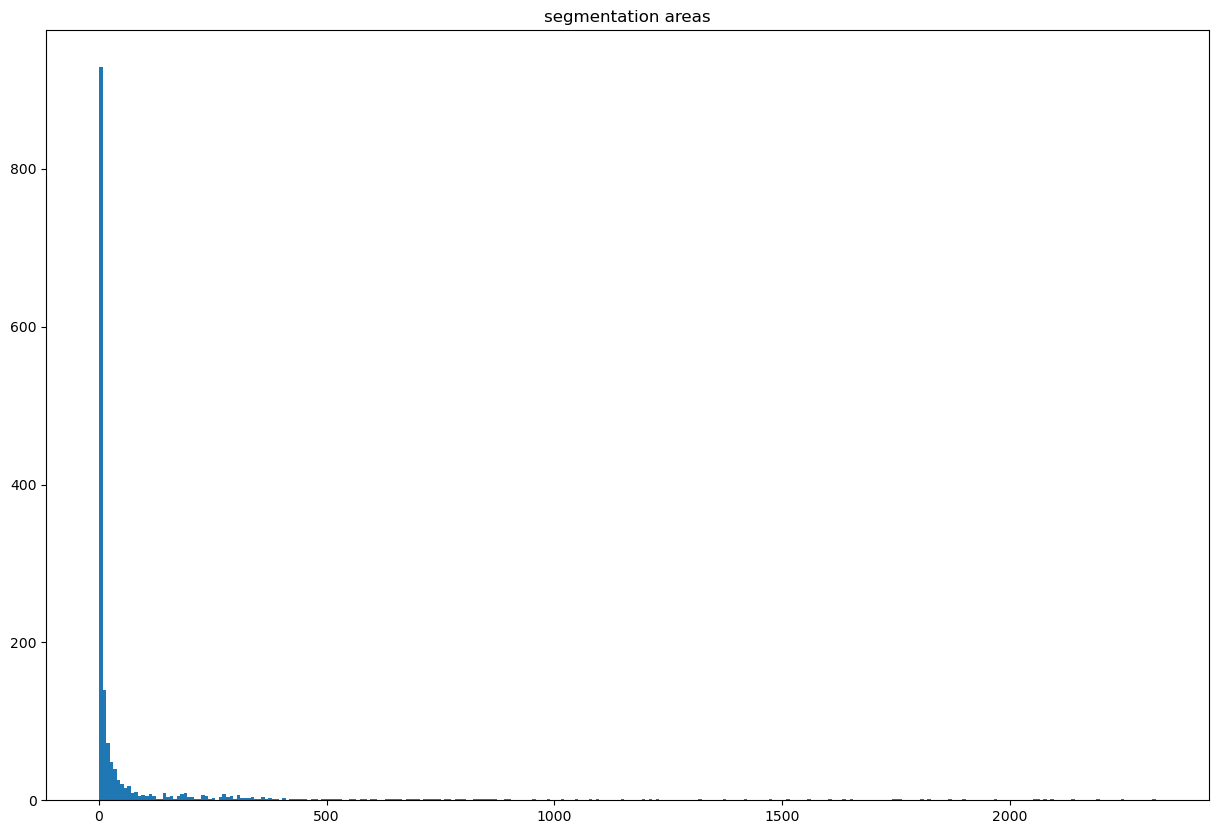

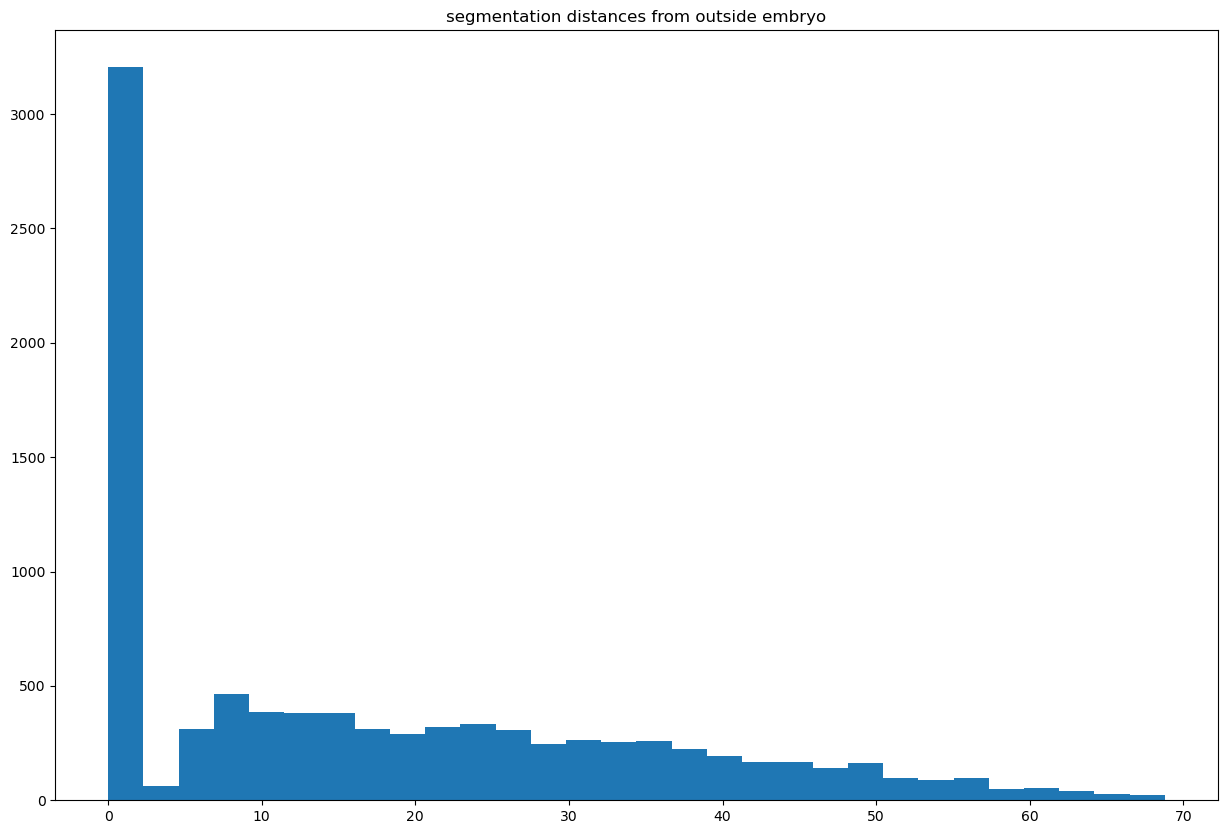

In [17]:
fig4, ax4 = plt.subplots(1,1, figsize=(15,10))
ax4.set_title("segmentation areas")
ax4.hist(areas_collection_list, bins=300)
# ax4.set_xlim(-0.5, 100) #change this line to slice the histogram graph
# ax4.set_ylim(0, 100) #change this line to slice the histogram graph


fig5, ax5 = plt.subplots(1,1, figsize=(15,10))
ax5.set_title("segmentation distances from outside embryo")
ax5.hist(shortdist_collection_list, bins=30)
# ax5.set_xlim(-0.5, 10) #change this line to slice the histogram graph


top perc:  226.36359925361154
bot perc:  183.1546562227253
top stdv:  240.5035515297442
bot stdv:  233.6016412601545
top USED:  240.5035515297442
bot USED:  233.6016412601545


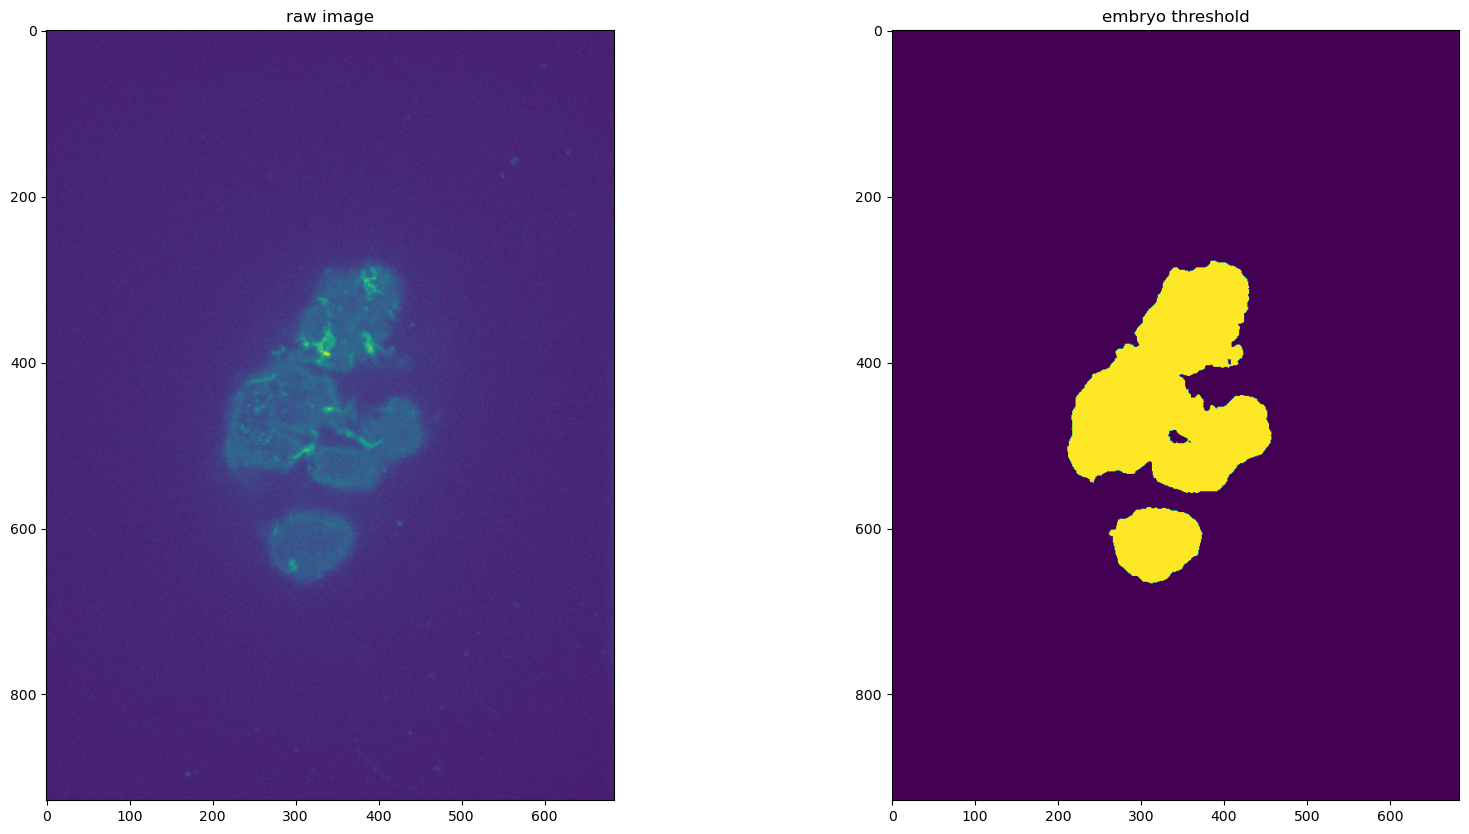

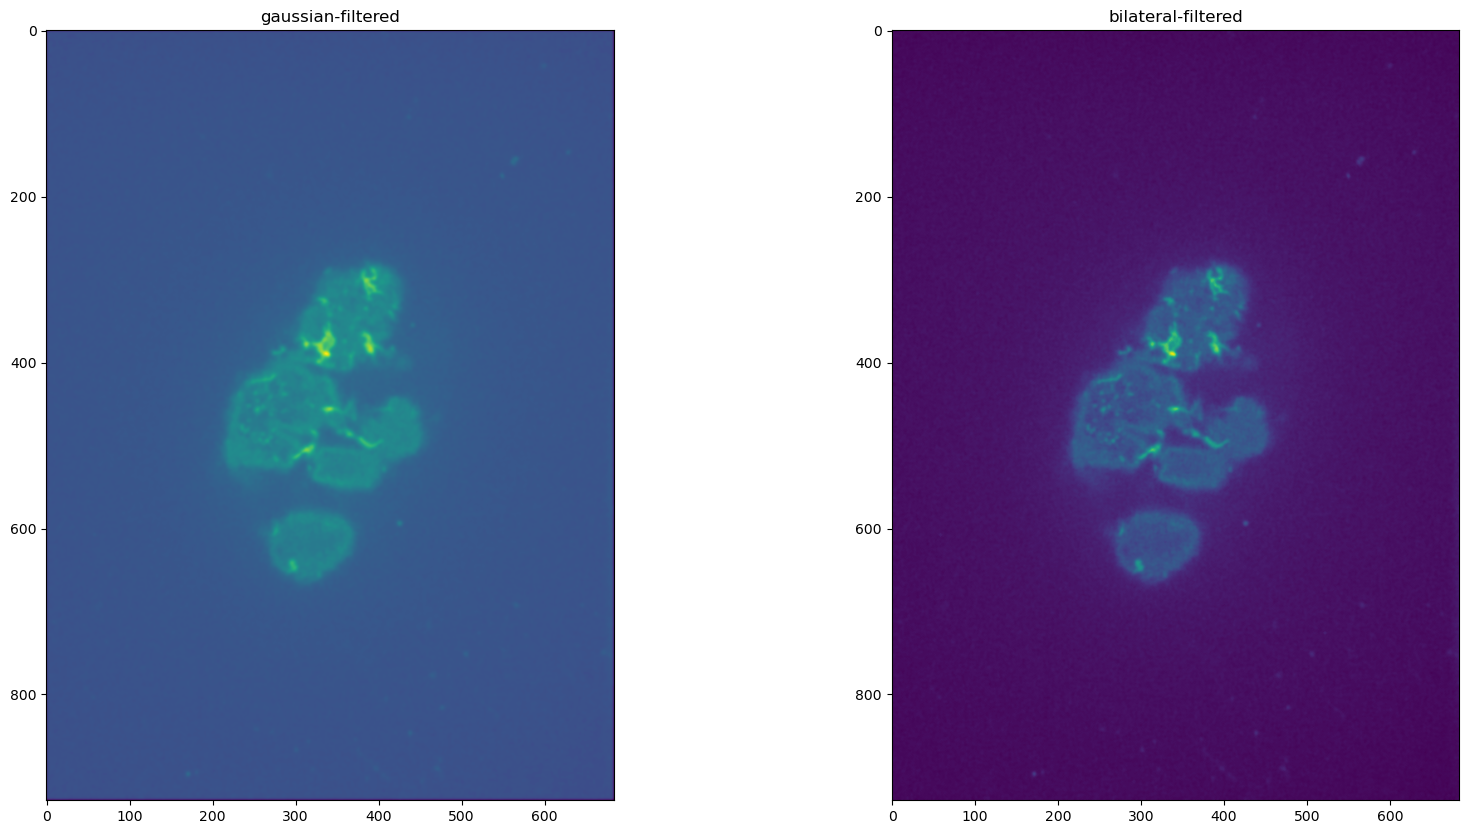

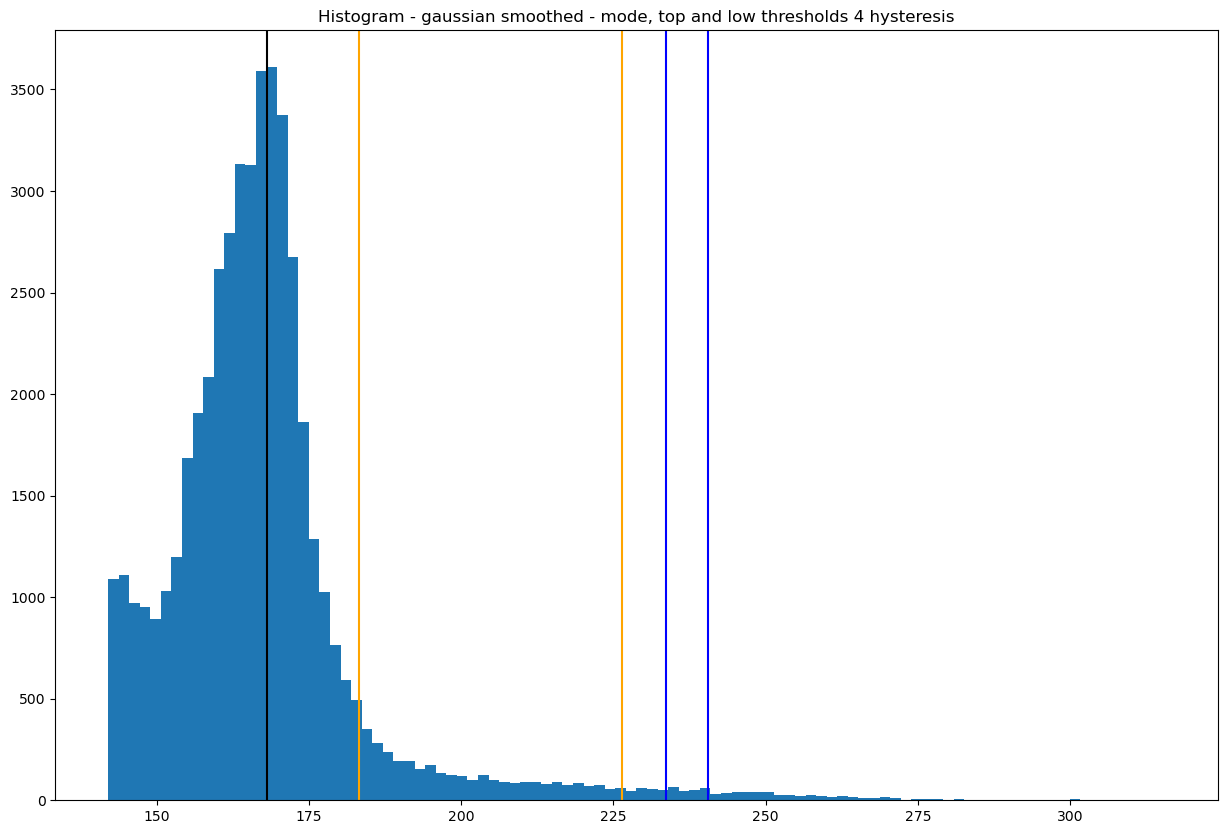

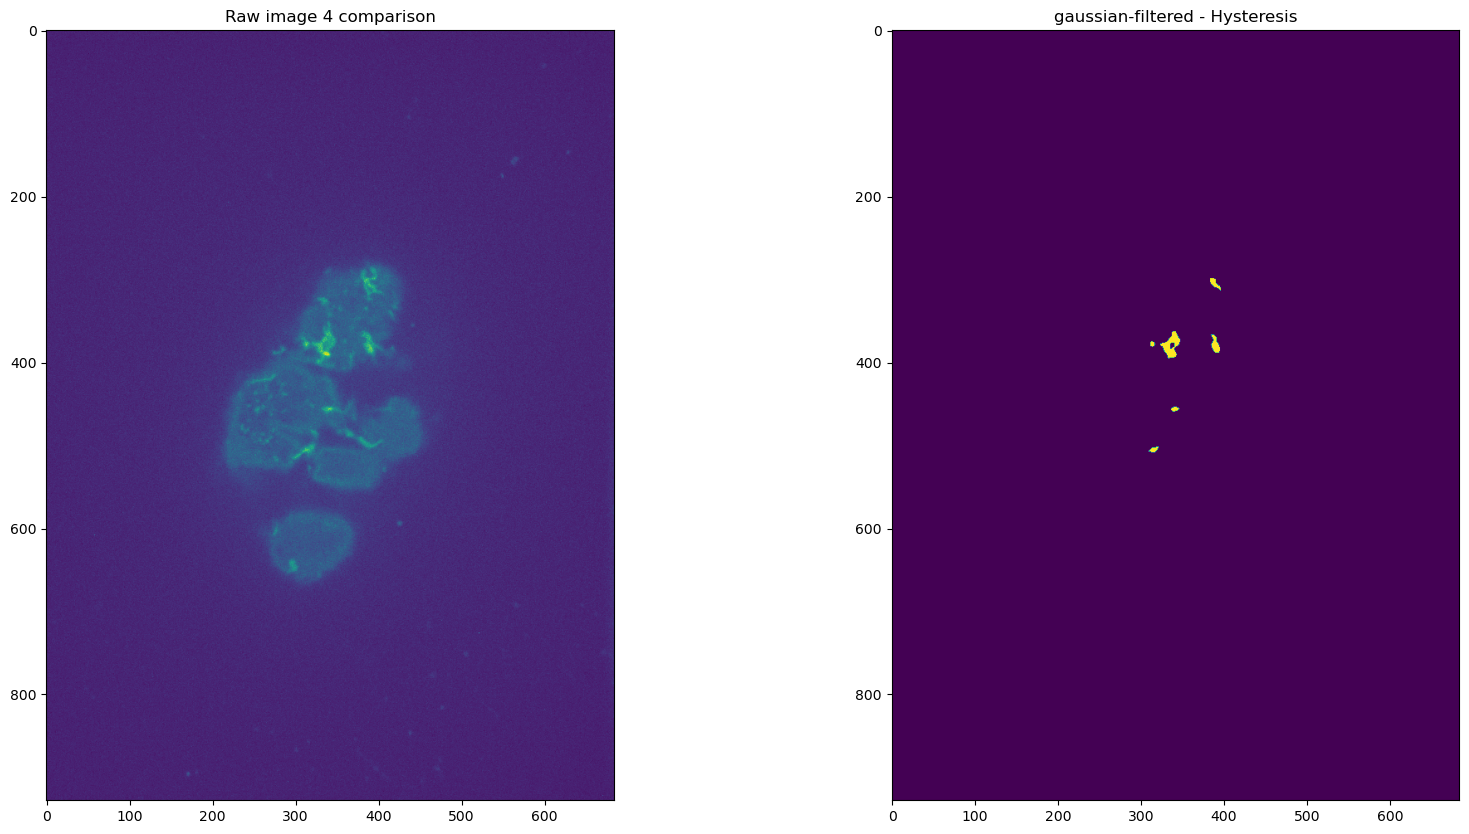

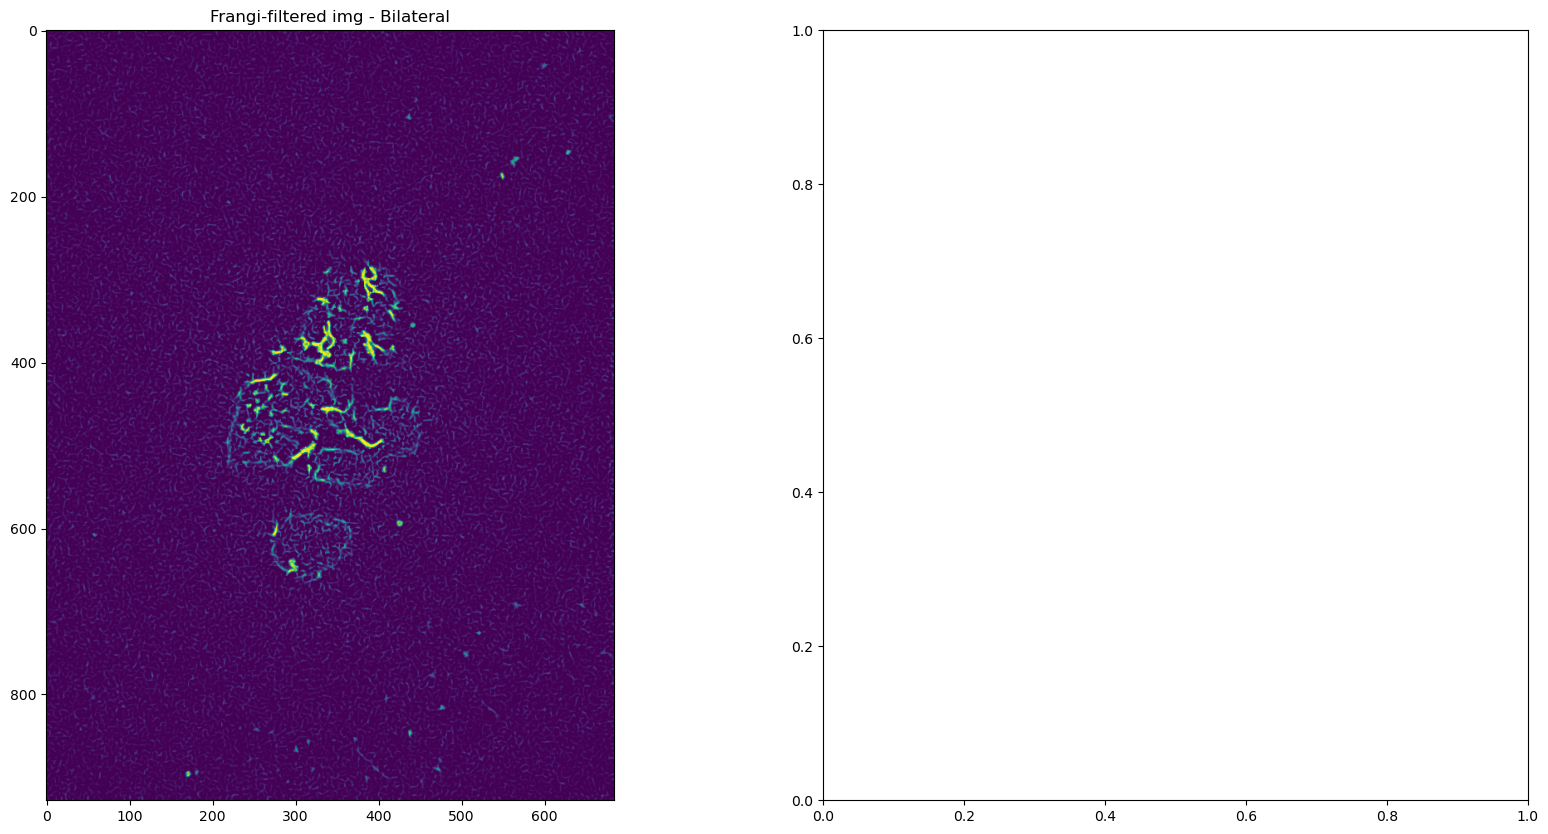

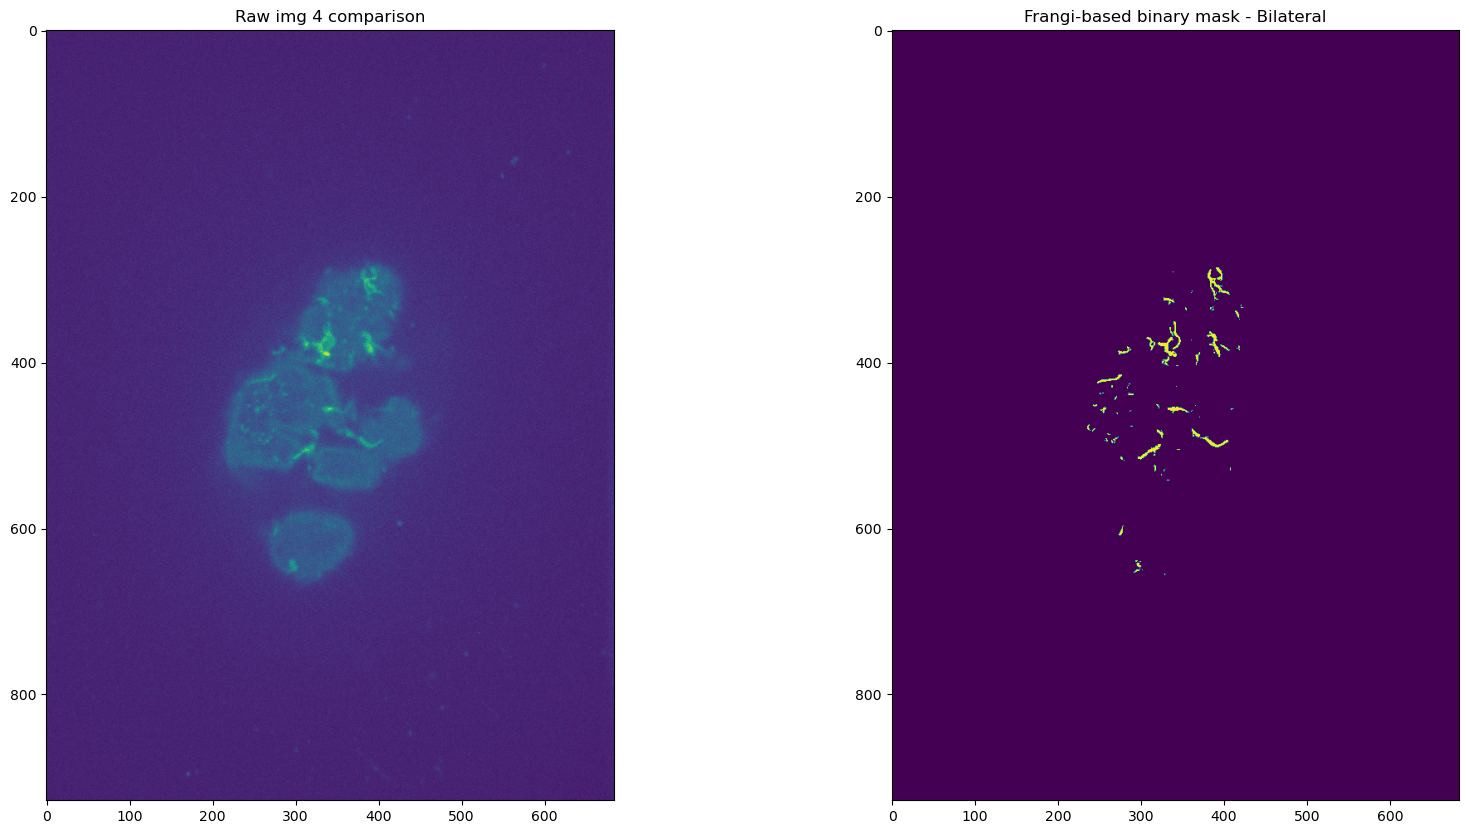

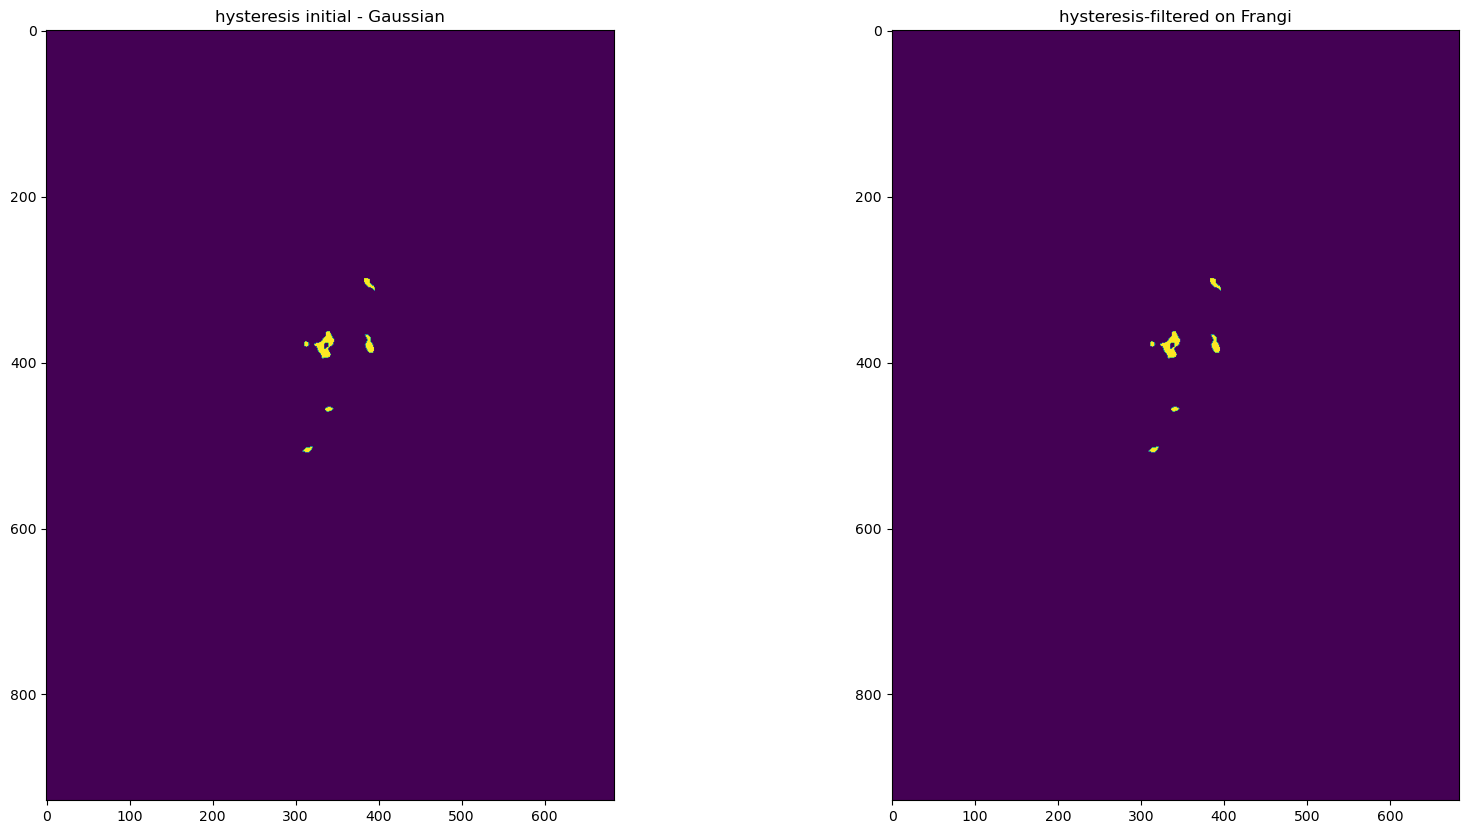

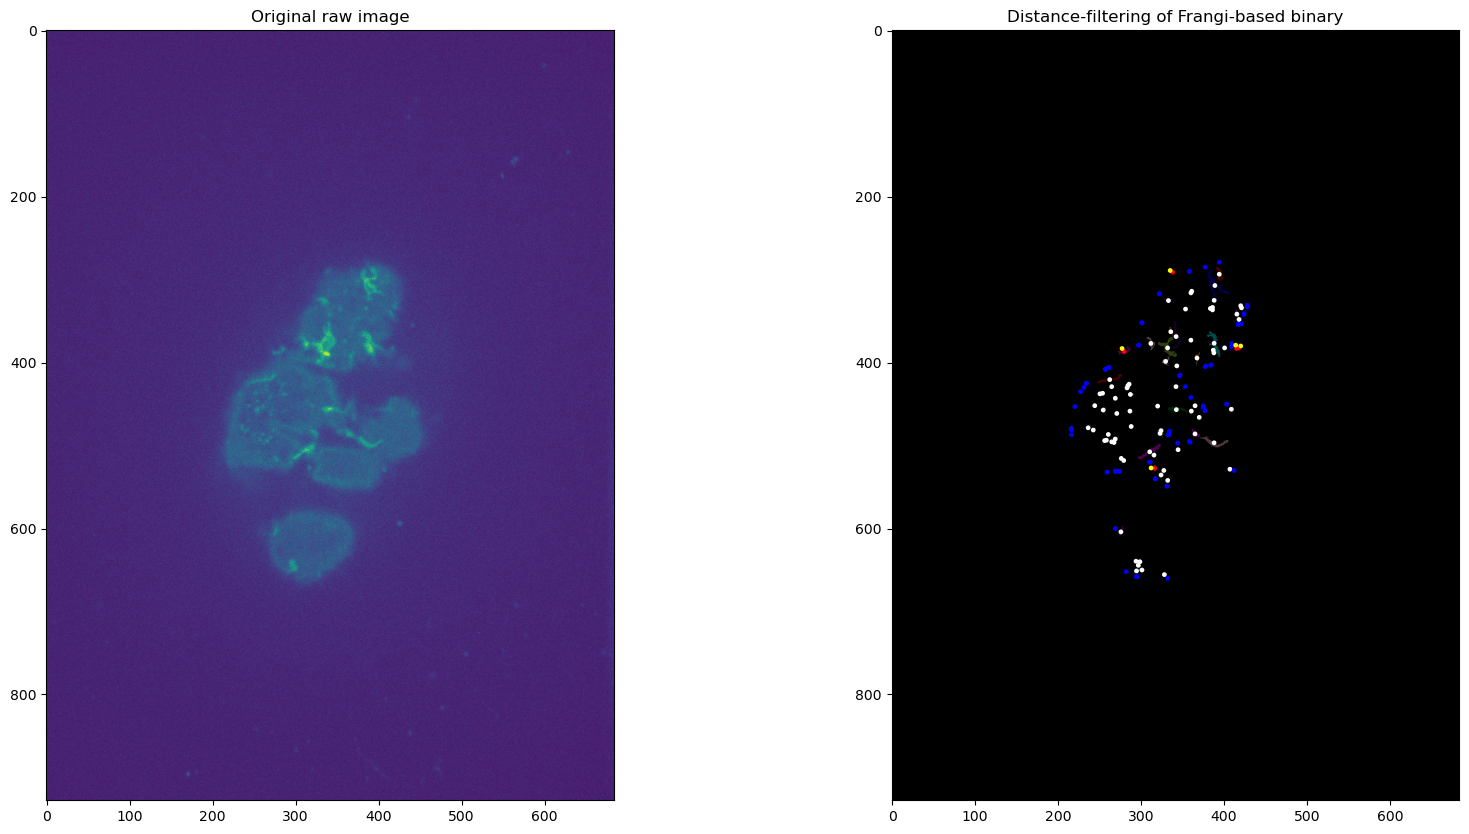

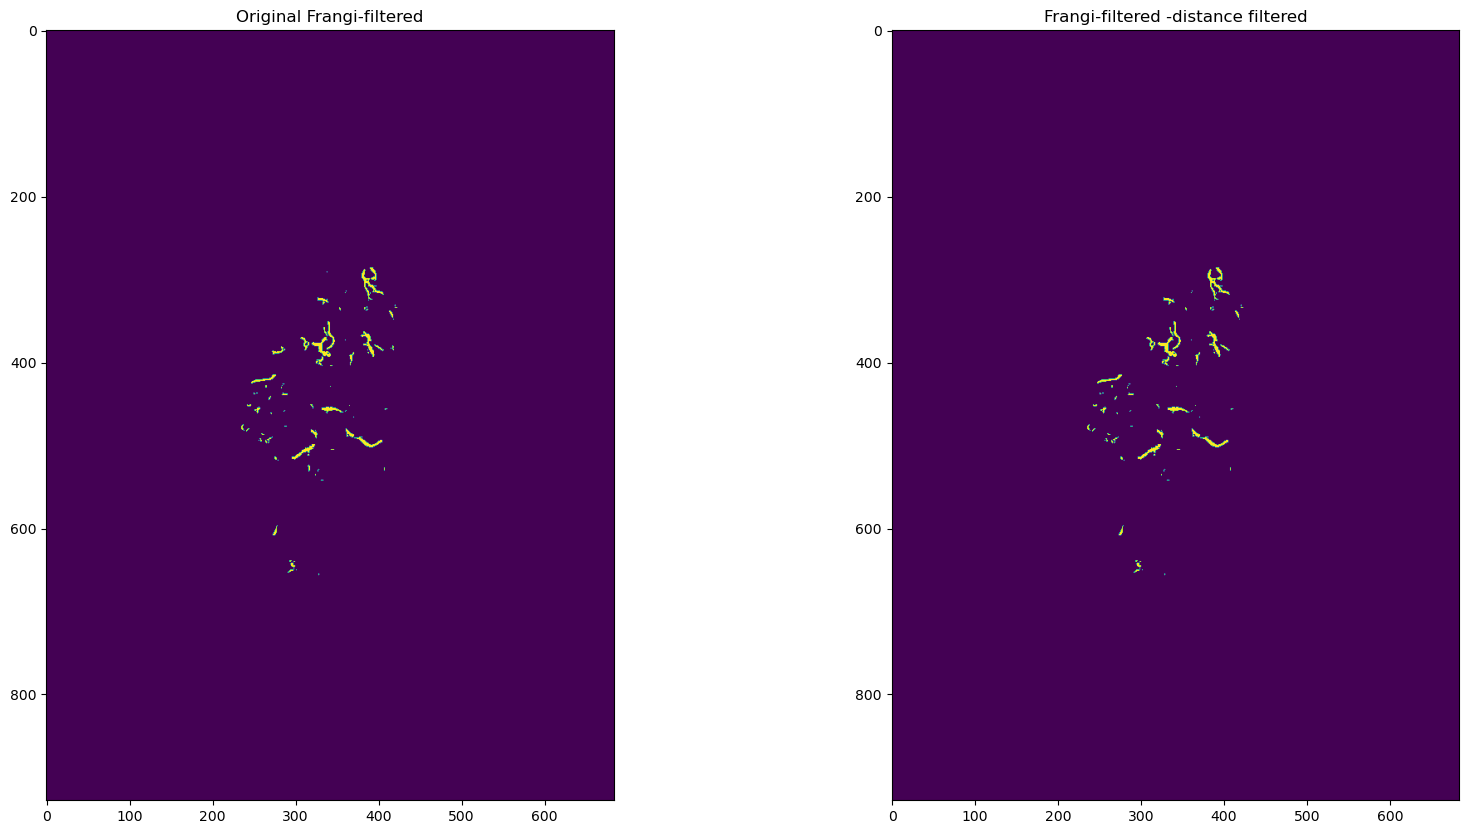

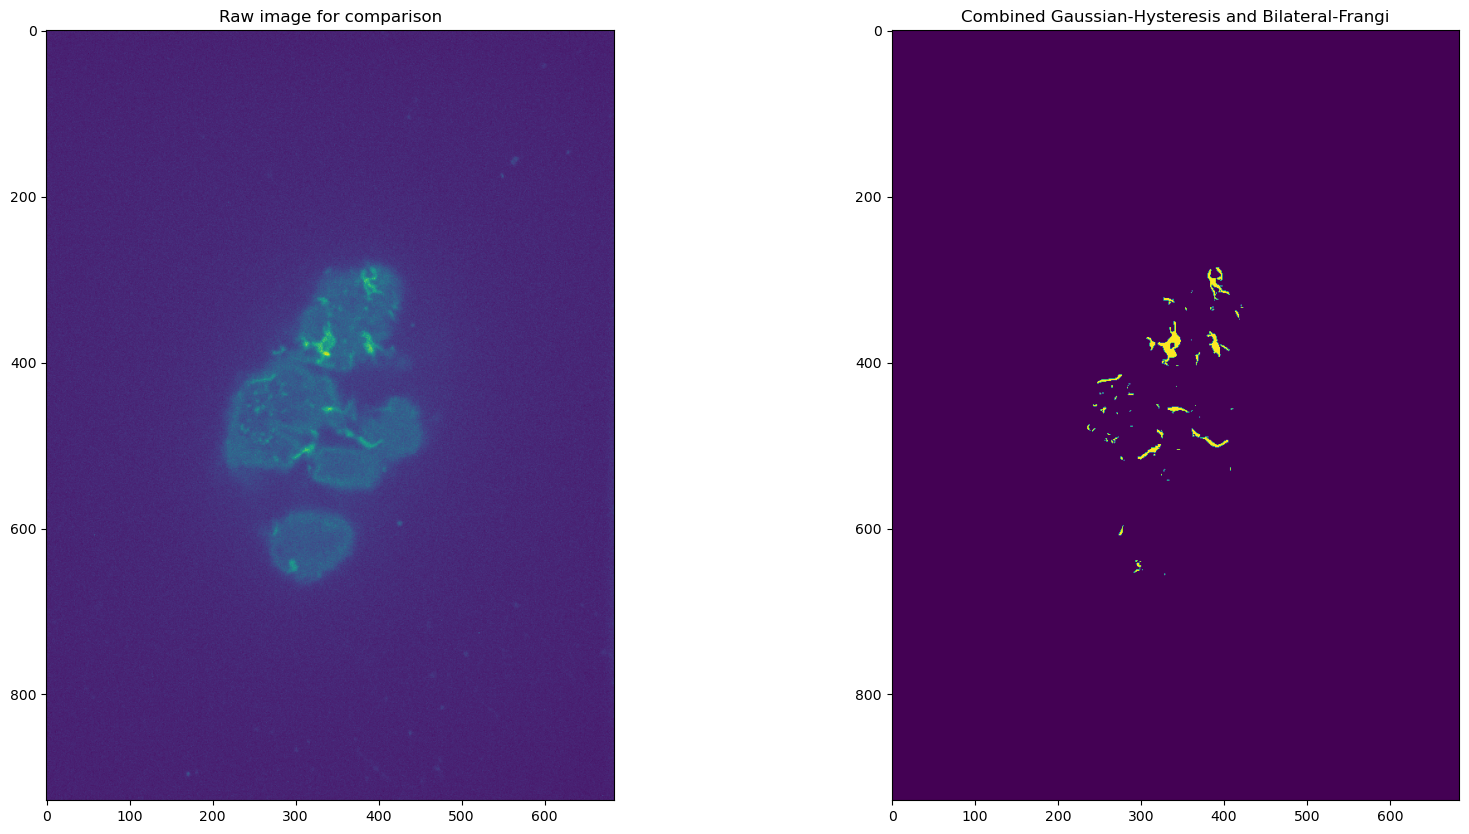

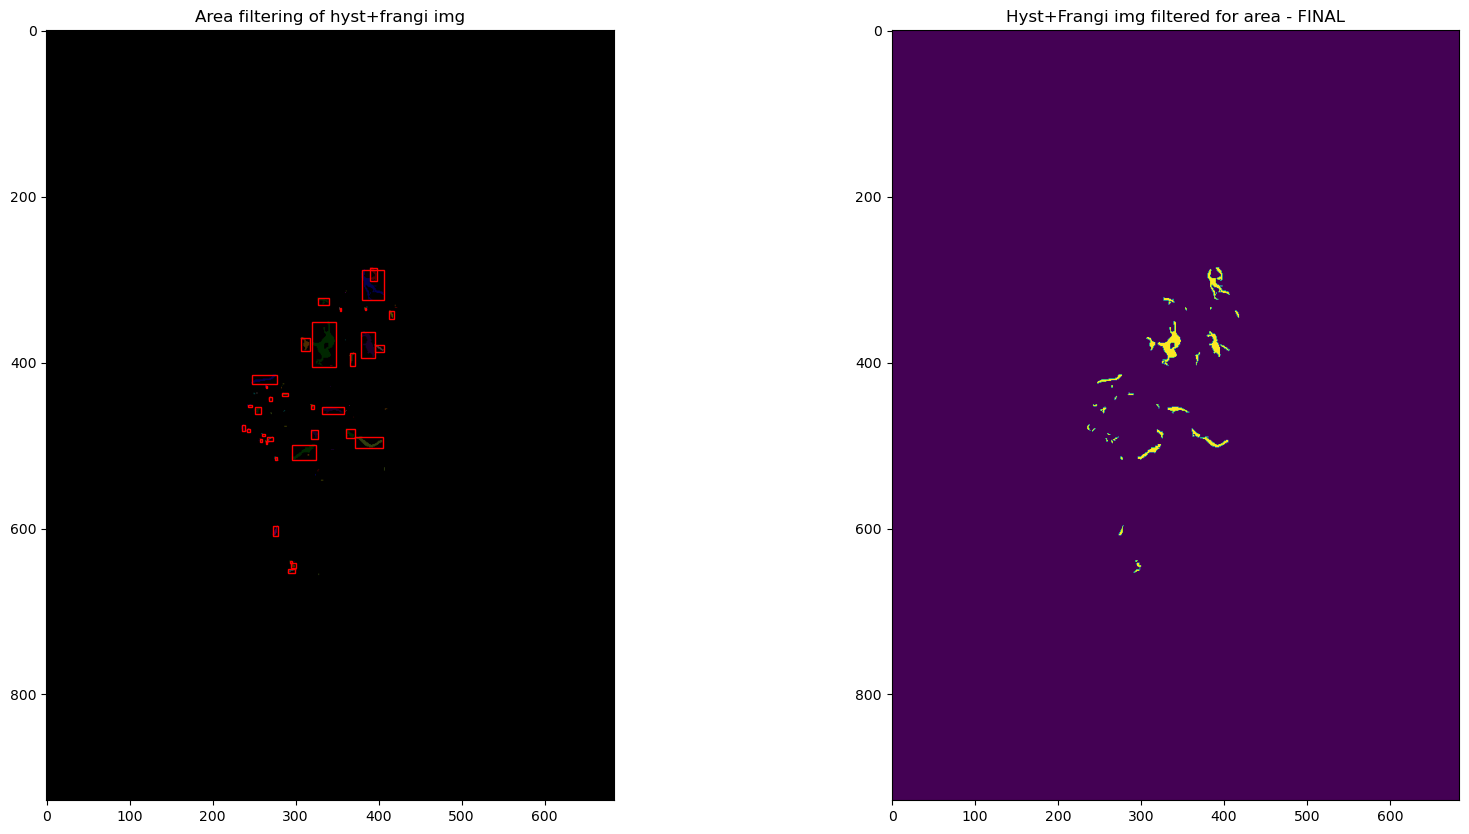

In [46]:
#test individual timepoint for filopodia segmentation

### =====
### INDICATE THE TIMEPOINT TO WORK WITH
### =====
tmpt__2ww = 0


### =====
### EXTRACT THE TIMEPOINT FROM THE TIMECOURSE, GET THE GAUSSIAN SMOOTHED TIMEPOINT, THE BILATERAL SMOOTHED TIMEPOINT, THE THRESHOLDED EMBRYO AND
### VALUES OF PIXELS INTENSITY FOR THE AREA WITHIN THE EMBRYO MASK BOTH FOR THE GUASSIAN SMOOTHED AND THE BILATERAL SMOOTHED TIMEPOINT
### =====

def extract_smooth_timepoint_2ww_wp(raw_timelapse, gausssmooth_sigma, bilatsmooth_parameters, embryo_mask, timepoint_2ww_n):
    #Get the raw image
    tp___im_raw = raw_timelapse[timepoint_2ww_n]
    
    # #Get the guassian smoothed image
    tp___im_gaussian = blur_image(tp___im_raw, gausssmooth_sigma, ny=None) #apply gaussian blurring
    
    #Transform raw image to type float32 before applying bilateral filtering
    tp___im_raw_f32 = util.img_as_float32(tp___im_raw)
    #Apply bilateral blurring
    tp___im_bilat = cv2.bilateralFilter(tp___im_raw_f32, bilatsmooth_parameters[0], bilatsmooth_parameters[1], bilatsmooth_parameters[2])
    
    #Get the thresholded image
    tp___im_embryo_thresh = embryo_mask[timepoint_2ww_n]

    #Get the array of the over embryo threshold pixels in the gaussian smoothed picture
    ovth_tp___im_gau_comp = tp___im_gaussian[tp___im_embryo_thresh>0]

    #Get the array of the over embryo threshold pixels in the bilateral smoothed picture
    ovth_tp___im_bil_comp = tp___im_bilat[tp___im_embryo_thresh>0]

    #Plot the result
    fig3000, ax3000 = plt.subplots(1,2, figsize=(20,10))
    ax3000[0].set_title("raw image")
    ax3000[0].imshow(tp___im_raw)
    ax3000[1].set_title("embryo threshold")
    ax3000[1].imshow(tp___im_embryo_thresh)

    fig3001, ax3001 = plt.subplots(1,2, figsize=(20,10))
    ax3001[0].set_title("gaussian-filtered")
    ax3001[0].imshow(tp___im_gaussian)
    ax3001[1].set_title("bilateral-filtered")
    ax3001[1].imshow(tp___im_bilat)

    
    return tp___im_raw, tp___im_gaussian, tp___im_bilat, tp___im_embryo_thresh, ovth_tp___im_gau_comp, ovth_tp___im_bil_comp


#Use extract_timepoint_2ww_wp to get the raw image, the gaussian smoothed image, the bilateral filtered image, the embryo thresholded mask, the values of the pixels within the embryo mask of the gaussian smoothed and bilateral filtered images, for the current timepoint
raw_tmp2ww, gauss_tmp2ww, bilat_tmp2ww, embr_tmp2ww, ovth_gauss__tmp2ww, ovth_bilat__tmp2ww = extract_smooth_timepoint_2ww_wp(ch3_timalapse_img, gau_smooth_sigma_fil, (bil_smooth_diameter, bil_smooth_sigma_color, bil_smooth_sigma_space), ch3_threshold_img, tmpt__2ww)



### =====
### HYSTERESIS SEGMENTATION ON GAUSSIAN SMOOTHED TIMEPOINT
### =====

def get_mode_maxperc_minperc_maxstd_minstd_wp(image4hist, maxperc_v, minperc_v, maxstd_v, minstd_v):
    #Get picture histogram distribution
    image4hist_hist_counts, image4hist__hist_edges = np.histogram(image4hist, bins=100)

    #Get the histogram mode
    image4hist_hist_mode_pos = np.argmax(image4hist_hist_counts)
    image4hist_hist_mode_val = image4hist__hist_edges[image4hist_hist_mode_pos]

    #Get standard deviation of the intensity values histogram distribution
    histogram_ddistr_std_dv = np.std(image4hist)

    #Get a putative top threshold based on percentile
    putati_ve__max_thresh_perc = np.percentile(image4hist, maxperc_v)

    #Get a putative bottom threshold based on percentile
    putati_ve__min_thresh_perc = np.percentile(image4hist, minperc_v)

    #Get putative top threshold based on mode + N*StdDv
    putati_ve__max_thresh_stdv = image4hist_hist_mode_val+maxstd_v*histogram_ddistr_std_dv

    #Get putative bottom threshold based on mode + N*StdDv
    putati_ve__min_thresh_stdv = image4hist_hist_mode_val+minstd_v*histogram_ddistr_std_dv

    #Plot histogram distribution of Frangi-filtered image
    fig3002, ax3002 = plt.subplots(1,1, figsize=(15,10))
    ax3002.set_title("Histogram - gaussian smoothed - mode, top and low thresholds 4 hysteresis")
    ax3002.hist(image4hist.flatten(), bins=100)
    ax3002.axvline(x=image4hist_hist_mode_val, color="black")
    ax3002.axvline(x=putati_ve__max_thresh_perc, color="orange")
    ax3002.axvline(x=putati_ve__min_thresh_perc, color="orange")
    ax3002.axvline(x=putati_ve__max_thresh_stdv, color="blue")
    ax3002.axvline(x=putati_ve__min_thresh_stdv, color="blue")
    
    return image4hist_hist_mode_val, putati_ve__max_thresh_perc, putati_ve__min_thresh_perc, putati_ve__max_thresh_stdv, putati_ve__min_thresh_stdv
    

#Get mode, max, min values based on percentile and standard deviantion times for gaussian and bilateral filtered images
gauss_mode, gauss_max_p, gauss_min_p, gauss_max_st, gauss_min_st = get_mode_maxperc_minperc_maxstd_minstd_wp(ovth_gauss__tmp2ww, pip2_top_percentile_hyst_filt, pip2_bot_percentile_hyst_filt, pip2_top_stdv_multfactor_hyst_filt, pip2_bot_stdv_multfactor_hyst_filt)


def new_get_hysteresis_based_segmentation_wp(timelapse_with_puncta_tmpt, raw_tmpt_4comparison, embryo_mask_tmpt, hyst_filt_top_perc, hyst_filt_bot_perc, hyst_filt_top_stdfactor, hyst_filt_bot_stdfactor):
    """
    returns a binary mask with brightest pixels selected based on an hystereris-filter. The top and bottom values of the hysteresis process are both, independentely, defined as follow: first it is calculated the value to use, based on an histogram percentile.
    Secondly a value is calculated by taking the mode intensity value and summing it the standard deviation of intensity values distribution, multiplied for an indicated factor. The highest of these two values is used. This process is quite robust to images with
    low signal-to-noise (the throush signal is dim or bleach and the image is almost all background).
    
    inputs: image to process as 2D numpy array (timelapse_with_puncta_tmpt). Embryo mask (binary segmentation of the embryo cytosol) as numpy array of the same shape of timelapse_with_puncta_tmpt. Percentile to use to calculate the high value of the hysteresis filtering (hyst_filt_top_perc). 
    Percentile to use to calculate the low value of the hysteresis filtering (hyst_filt_bot_perc). Number of standard deviation to sum to mode value for calculating the high value of the hysteresis filtering (hyst_filt_top_stdfactor).
    Number of standard deviation to sum to mode value for calculating the low value of the hysteresis filtering (hyst_filt_bot_stdfactor).

    output: binary segmentation of putative puncta structures as 2D numpy array of the same shape of the input image.
    """
       
    #Get the array of pixels in the median-filtered image which are in the embryo mask
    timelapse_with_puncta_tmpt_med_overembryo = timelapse_with_puncta_tmpt[embryo_mask_tmpt>0]

    #Get mode, max, min values based on percentile and standard deviantion times for gaussian and bilateral filtered images
    mode_inte_n_sit_y_val, putati_ve__top_thresh_old_i, putati_ve__bot_thresh_old_i, putati_ve__top_thresh_old_st, putati_ve__bot_thresh_old_st = get_mode_maxperc_minperc_maxstd_minstd(timelapse_with_puncta_tmpt_med_overembryo, hyst_filt_top_perc, hyst_filt_bot_perc, hyst_filt_top_stdfactor, hyst_filt_bot_stdfactor)
    
    if putati_ve__top_thresh_old_i>=putati_ve__top_thresh_old_st:
        putati_ve__top_thresh_old = putati_ve__top_thresh_old_i
    else:
        putati_ve__top_thresh_old = putati_ve__top_thresh_old_st

    ##===========
    ##===========
    ##===========
    if putati_ve__bot_thresh_old_st > putati_ve__top_thresh_old_i:
        putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_st
    else:
        if putati_ve__bot_thresh_old_i>=putati_ve__bot_thresh_old_st:
            putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_st
        else:
            putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_i

    
    # if putati_ve__bot_thresh_old_st>putati_ve__top_thresh_old_i:
    #     # putati_ve__top_thresh_old = putati_ve__top_thresh_old_st
    #     # putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_st
    #     putati_ve__top_thresh_old = putati_ve__top_thresh_old_st
    #     putati_ve__bot_thresh_old = putati_ve__top_thresh_old_st
    # else:
    #     # putati_ve__top_thresh_old = putati_ve__top_thresh_old_st
    #     # putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_st
    #     if putati_ve__top_thresh_old_i>=putati_ve__top_thresh_old_st:
    #         putati_ve__top_thresh_old = putati_ve__top_thresh_old_i
    #     else:
    #         putati_ve__top_thresh_old = putati_ve__top_thresh_old_st

    #     if putati_ve__bot_thresh_old_i>=putati_ve__bot_thresh_old_st:
    #         putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_i
    #     else:
    #         putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_st
    # print("top perc: ", putati_ve__top_thresh_old_i)
    # print("bot perc: ", putati_ve__bot_thresh_old_i)
    # print("top stdv: ", putati_ve__top_thresh_old_st)
    # print("bot stdv: ", putati_ve__bot_thresh_old_st)
    # print("top USED: ", putati_ve__top_thresh_old)
    # print("bot USED: ", putati_ve__bot_thresh_old)
    
    ###===========
    ###===========
    ###===========
    
    # Get a putative thresholded image using hysteresis based thresholding strategy using the raw image instead of the median filtered image
    timelapse_with_puncta_tmpt_hyst_thresh = filters.apply_hysteresis_threshold(timelapse_with_puncta_tmpt, low=putati_ve__bot_thresh_old, high=putati_ve__top_thresh_old)
    
    #Rescale hysteresis-based binary image on the uint8 value range
    uint8_timelapse_with_puncta_tmpt_hyst_thresh = np.where(timelapse_with_puncta_tmpt_hyst_thresh>0, 255, 0).astype(np.uint8)

    #Further remove every puncta which is detected outside the embryo
    final_filtered_img = np.where(embryo_mask_tmpt>0, uint8_timelapse_with_puncta_tmpt_hyst_thresh, 0).astype(np.uint8)

    #Plot the result
    fig3003, ax3003 = plt.subplots(1,2, figsize=(20,10))
    ax3003[0].set_title("Raw image 4 comparison")
    ax3003[0].imshow(raw_tmpt_4comparison)
    ax3003[1].set_title("gaussian-filtered - Hysteresis")
    ax3003[1].imshow(final_filtered_img)
    
    return final_filtered_img


#Get hysteresis based segmented segmented timepoints for the gaussian blurred and the bilater blurred images
hysteresis_segm_img_gauss = new_get_hysteresis_based_segmentation_wp(gauss_tmp2ww, raw_tmp2ww, embr_tmp2ww, pip2_top_percentile_hyst_filt, pip2_bot_percentile_hyst_filt, pip2_top_stdv_multfactor_hyst_filt, pip2_bot_stdv_multfactor_hyst_filt)



### =====
### FRANGI SEGMENTATION ON BILATERAL - FILTERED TIMEPOINT
### =====

def get_frangi_based_segmentation_img_threshold_wp(input_pict_ure1, peak_position):
    
    #Use Frangi filtering on the Guassian smoothed timepoint
    tmpt_2ww_frangi_img = filters.frangi(input_pict_ure1, sigmas=range(1, 5, 1), alpha=1, beta=1, gamma=1, black_ridges=False)
        
    #Calculate the histogram distribution of the intensities of the Frangi filtered image - separate the counts per histogram bin, and the edges of the bins on the histogram
    frangi_f_img_hist_counts, frangi_f_img_hist_edges = np.histogram(tmpt_2ww_frangi_img.flatten(), bins=100)
        
    #Detect at least 3 maxima in the histogram distribution
    frangi__maxima_starting_order = 10 #Inialize a value to be used for the range of maxima detection
    max_pos__frangi__hist_counts = scipy.signal.argrelmax(frangi_f_img_hist_counts, order=frangi__maxima_starting_order) #Initialize maxima detection
    while len(max_pos__frangi__hist_counts[0])<3: #Iterate detection until at least 2 maxima are detected, by progressively decreasing the range of maxima detection
        frangi__maxima_starting_order = frangi__maxima_starting_order-1
        max_pos__frangi__hist_counts = scipy.signal.argrelmax(frangi_f_img_hist_counts, order=frangi__maxima_starting_order)
        
    #Get the last (from x-axis origin) detected maxima position
    position_of_frangi_thresh = max_pos__frangi__hist_counts[0][peak_position]
        
    #get the intensity value which correspond to the last (from x-axis origin) detected maxima in the frangi-filtered histogram distribution
    frangi__threshold = frangi_f_img_hist_edges[position_of_frangi_thresh]

    #Plot histogram distribution of Frangi-filtered image
    fig3004, ax3004 = plt.subplots(1,1, figsize=(15,10))
    ax3004.set_title("Histogram - Frangi - threshold")
    ax3004.hist(tmpt_2ww_frangi_img.flatten(), bins=100)
    ax3004.axvline(x=frangi__threshold, color="black")
    
    return tmpt_2ww_frangi_img, frangi__threshold


#Use Frangi filtering on the Bilateral filtered timepoint - NOTE WELL THAT IMAGE MUST BE TRANSFORMED TO int16
tmpnt__2ww_frangiF_img_bilat, thresh_frangi_bilat = get_frangi_based_segmentation_img_threshold(util.img_as_int(bilat_tmp2ww), frangi_filter_peak_position)


def get_frangi_based_segmentation_img_wp(frangifiltered_input_pict_ure, raw_imag_4comparis, threshold_frangi_val, thresholded_embryo_input):
    # Binarize the image using the Frangi-based highpass calculated threshold
    high__pass_thresh_frangi_filtered_img = np.where(frangifiltered_input_pict_ure>threshold_frangi_val, 1000, 0)
    
    # Set binary values outside the embryo to 0
    only_embryo_frangi_binary_img = np.where(thresholded_embryo_input>0, high__pass_thresh_frangi_filtered_img, 0)

    #Set border values to 0 - NOTE: this is required because Frangi-based filtering leads to the detection of the picture borders. I thouht that the step just above (Set binary values outside the embryo to 0) would have taken care of it, but it doesn't in cases where some tissue is at the border
    no_borders_only_embryo_frangi_binary_img = set_border_to_0(only_embryo_frangi_binary_img)
    
    #Rescale image in the unit8 range
    uint8_only_embryo_frangi_binary_img = np.where(no_borders_only_embryo_frangi_binary_img>0, 255, 0).astype(np.uint8)

    #Plot the result
    fig3005, ax3005 = plt.subplots(1,2, figsize=(20,10))
    ax3005[0].set_title("Frangi-filtered img - Bilateral")
    ax3005[0].imshow(frangifiltered_input_pict_ure)
    # ax3005[1].set_title("bilateral-filtered - Frangi")
    # ax3005[1].imshow(tmpnt__2ww_frangiF_img_bilat)

    fig3006, ax3006 = plt.subplots(1,2, figsize=(20,10))
    ax3006[0].set_title("Raw img 4 comparison")
    ax3006[0].imshow(raw_imag_4comparis)
    ax3006[1].set_title("Frangi-based binary mask - Bilateral")
    ax3006[1].imshow(uint8_only_embryo_frangi_binary_img)

    return uint8_only_embryo_frangi_binary_img


#Get frangi based segmented timepoint for the bilateral-blurred Frangi-filtered image
frangi_segm_img_bilat = get_frangi_based_segmentation_img_wp(tmpnt__2ww_frangiF_img_bilat, raw_tmp2ww, thresh_frangi_bilat, embr_tmp2ww)


#========
#======== FILTER HYSTERESIS-BASED BINARY IMAGE BASED ON OVERLAP WITH HYSTERESIS-BASED BINARY IMAGE (WHICH IS MORE STRINGENT)
#========

def hysteresis_filter_by_frangi_overlap_wp(hysteresis_bin_input, frangi_bin_input, re_fer_en_ce_img):
    # label image regions
    label_hysteresis_bin_input = measure.label(hysteresis_bin_input)
    
    #measure the properties of the regions
    label_hysteresis_img_prop = measure.regionprops(label_hysteresis_bin_input)

    #Get coordinates of Frangi-based binary pixel - reorganize it to be a list of tuples
    coord_frangi_bin_input = np.argwhere(frangi_bin_input>0)
    coord_frangi_bin_input_as_list_of_tuples = [(cr_dnt[0], cr_dnt[1]) for cr_dnt in list(coord_frangi_bin_input)]

    #Initialize a zero array to be modified as output array
    output_array_filtered_hyst_img = np.zeros((re_fer_en_ce_img.shape[0], re_fer_en_ce_img.shape[1])).astype(np.uint8)

    #Iterate through the regions of the labelled image, identified using measure.regionprops
    for hyst_reg_i_on in label_hysteresis_img_prop:
    
        #Get region coordinates - reorganize it to be a list of tuples
        hyst_reg_i_on_coordinates = hyst_reg_i_on.coords
        hyst_reg_i_on_coordinates_as_listoftupl = [(cr_dnt1[0], cr_dnt1[1]) for cr_dnt1 in list(hyst_reg_i_on_coordinates)]
    
        #Get intersection of region coordinates and frangi-binary pixels coordinates
        interescion_with_frangi = list(set(hyst_reg_i_on_coordinates_as_listoftupl).intersection(set(coord_frangi_bin_input_as_list_of_tuples)))

        #If there is an intersection, add the region to the output_array_hyst_filter
        if len(interescion_with_frangi)>0:
        #Unzip the coordinates in individual lists
            unzipped_hyst_reg_i_on_coordinates = [list(tt33) for tt33 in zip(*hyst_reg_i_on_coordinates)]
        
            #Set output array values at region coordinates to 255
            output_array_filtered_hyst_img[unzipped_hyst_reg_i_on_coordinates[0], unzipped_hyst_reg_i_on_coordinates[1]] = 255

    #Plot the result
    fig3007, ax3007 = plt.subplots(1,2, figsize=(20,10))
    ax3007[0].set_title("hysteresis initial - Gaussian")
    ax3007[0].imshow(hysteresis_bin_input)
    ax3007[1].set_title("hysteresis-filtered on Frangi")
    ax3007[1].imshow(output_array_filtered_hyst_img)
    
    return output_array_filtered_hyst_img


#Filter Hysteresis-based binary image to remove structures which don't overlap at all with Frangi detected structures
frangi_filtered_hyst_based_binary_img_gaussian = hysteresis_filter_by_frangi_overlap_wp(hysteresis_segm_img_gauss, frangi_segm_img_bilat, raw_tmp2ww)



#========
#======== FILTER FRANGI-BASED BINARY IMAGE BASED ON PROXIMITY TO THE OUTSIDE OF THE EMBRYO
#========

def filter_segmented_pip2_4distance_wp(input__binary__image, thresholded__embryo_img, originalraw4comparison, distance_highpass_thr):
    # label image regions
    label__img = measure.label(input__binary__image)

    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = color.label2rgb(label__img, image=thresholded__embryo_img, bg_label=0)
    
    #measure the properties of the region
    label__img_properties = measure.regionprops(label__img)
    
    #Get the coordinates of the outside of the embryo
    embryo_outside_coord_colX_rowY_i_i = np.argwhere(thresholded__embryo_img==0)
        
    #Transform coordinates so that they are tuples in a list
    embryo_outside_coord_colX_rowY_i = [(list(cccrd)[1], list(cccrd)[0]) for cccrd in embryo_outside_coord_colX_rowY_i_i]

    #Initialize the plotting of the filtering process
    fig3008, ax3008 = plt.subplots(1,2, figsize=(20,10))
    ax3008[0].set_title("Original raw image")
    ax3008[0].imshow(originalraw4comparison)
    ax3008[1].set_title("Distance-filtering of Frangi-based binary")
    ax3008[1].imshow(image_label_overlay)
    
    #Initialize a zero array to be modified as output array
    output_arr_ay = np.zeros((thresholded__embryo_img.shape[0], thresholded__embryo_img.shape[1])).astype(np.uint8)

    #Initialize a collection list for the nearest neighbor distances
    nnd_cl = []
    
    #Iterate through the regions of the labelled image, identified using measure.regionprops
    for re_gion in label__img_properties:
        
        #Get the coordinates of the outside of the embryo
        embryo_outside_coord_colX_rowY = embryo_outside_coord_colX_rowY_i

        #Get the coordinates of the centroid of the region
        cc_yy_row, cc_xx_col = re_gion.centroid
        
        # show regions whose distance from embryo outside is shorter (blue) and longer (white) than the HighPass threshold
        input_re_gion_centroid = (cc_xx_col, cc_yy_row)

        #Add centroid coordinates to the list of outside of the embryo coordinates
        embryo_outside_coord_colX_rowY_plusCC = embryo_outside_coord_colX_rowY + [input_re_gion_centroid]
        
        # Make a tree out of the outside embryo coordinates plus the centroid coordinates
        embryo_outside_coord_tree = scipy.spatial.KDTree(embryo_outside_coord_colX_rowY_plusCC)
        
        # Get the 3 closest distances (and relative indeces in the list of coordinates) to the region centroid. NOTE: the first (aka closest) distance is always the point itself with distance 0
        distance__out, result__out = embryo_outside_coord_tree.query(input_re_gion_centroid, k=3)

        #Add nearest neighbor distance to collection list
        nnd_cl = nnd_cl + list(distance__out)
        
        #If the nearest neightbor distance of the region is higher than the highpass threshold modify the output array
        if list(distance__out)[1]>distance_highpass_thr:
            
            #Get region coordinates
            re_gion_coordinates = re_gion.coords

            # #Get coordinates of closest point outside the embryo
            cpoe__coord = embryo_outside_coord_colX_rowY_plusCC[list(result__out)[1]]
    
            #Unzip the coordinates in individual lists
            unzipped_re_gion_coordinates = [list(t) for t in zip(*re_gion_coordinates)]
            
            #Set output array values at region coordinates to 255
            output_arr_ay[unzipped_re_gion_coordinates[0], unzipped_re_gion_coordinates[1]] = 255

            #Form a circulat patch on the centroid of the region of interest
            cir_patch = plt.Circle(input_re_gion_centroid, radius=2, color='white')
            
            #Form a circulat patch on the coordinates of the closest point to the centroid of the region of interest which is outside the embryo
            cir_patch_nnd = plt.Circle(cpoe__coord, radius=2, color='blue')
    
            #Add patches to the graph
            ax3008[1].add_patch(cir_patch)
            ax3008[1].add_patch(cir_patch_nnd)

        else:
            # #Get coordinates of closest point outside the embryo
            cpoe__coord_x = embryo_outside_coord_colX_rowY_plusCC[list(result__out)[1]]

            #Form a circulat patch on the centroid of the region of interest
            cir_patch_x = plt.Circle(input_re_gion_centroid, radius=2, color='red')
            
            #Form a circulat patch on the coordinates of the closest point to the centroid of the region of interest which is outside the embryo
            cir_patch_nnd_x = plt.Circle(cpoe__coord_x, radius=2, color='yellow')
    
            #Add patches to the graph
            ax3008[1].add_patch(cir_patch_x)
            ax3008[1].add_patch(cir_patch_nnd_x)

    #Plot the result
    fig3009, ax3009 = plt.subplots(1,2, figsize=(20,10))
    ax3009[0].set_title("Original Frangi-filtered")
    ax3009[0].imshow(input__binary__image)
    ax3009[1].set_title("Frangi-filtered -distance filtered")
    ax3009[1].imshow(output_arr_ay)
        
    return output_arr_ay, nnd_cl


#Filter Frangi-based binary image to remove structures which are too close to the boarder of the embryo - NOTE THAT YOU HAVE TO TAKE THE FIRST OUTPUT OF THE FUNCTION
frangi_filtered_distance_embryo_bilateral = filter_segmented_pip2_4distance_wp(frangi_segm_img_bilat, embr_tmp2ww, raw_tmp2ww, highpass_distance_threshold)[0]



#========
#======== COMBINE HYSTERESIS FILTERED AND FRANGI-FILTERED IMAGES
#========

def combine_highpass_frangi_binary_img_wp(highpass_input_img, frangi_input_img, rawimage4_comp_arison):
    summed_highpass_frangi_img = highpass_input_img + frangi_input_img #sum the two binary masks
    # binarized_combined_img = np.where(summed_highpass_frangi_img>0, 1000, 0).astype(np.uint8) #binarize the summed masks
    unit8_binarized_combined_img = np.where(summed_highpass_frangi_img>0, 255, 0).astype(np.uint8) #binarize the summed masks and transform the binary mask in binary format

    #Plot the result
    fig3010, ax3010 = plt.subplots(1,2, figsize=(20,10))
    ax3010[0].set_title("Raw image for comparison")
    ax3010[0].imshow(rawimage4_comp_arison)
    ax3010[1].set_title("Combined Gaussian-Hysteresis and Bilateral-Frangi")
    ax3010[1].imshow(unit8_binarized_combined_img)
    
    return unit8_binarized_combined_img


#Combine hysteresis filtered and frangi-filtered images
binary_comb_ined_binary_img = combine_highpass_frangi_binary_img_wp(frangi_filtered_hyst_based_binary_img_gaussian, frangi_filtered_distance_embryo_bilateral, raw_tmp2ww)



#========
#======== FILTER COMBINED BINARY IMAGE TO REMOVE VERY SMALL REGIONS
#========

def filter_segmented_pip2_4area_wp(input__binary__imag_e, reference_image, area_highpass_thr):
    # label image regions
    label__im_g = measure.label(input__binary__imag_e)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    new_image_label_over_lay = color.label2rgb(label__im_g, image=reference_image, bg_label=0)
    #measure the properties of the region
    label__im_g_properties = measure.regionprops(label__im_g)
    fig3011, ax3011 = plt.subplots(1,2, figsize=(20,10))
    ax3011[0].set_title("Area filtering of hyst+frangi img")
    ax3011[0].imshow(new_image_label_over_lay)
    #Initialize a zero array to be modified as output array
    out_put_arr_ay = np.zeros((reference_image.shape[0], reference_image.shape[1])).astype(np.uint8)
    #Initialize a collection list for the areas
    areas_cl = []
    #Iterate through the regions of the labelled image, identified using measure.regionprops
    for re_gi_on in label__im_g_properties:
        
        #Get the area of the region
        re_gion_area = re_gi_on.area

        #Add area to collection list
        areas_cl.append(re_gion_area)
        
        #If the region passes both area and centroid (the centroid is not very close to the outside of the embryo) thresholds modify the output array
        if re_gion_area >= area_highpass_thr:
    
            #Get region coordinates
            re_gi_on_coordinates = re_gi_on.coords
    
            #Unzip the coordinates in individual lists
            unzipped_re_gi_on_coordinates = [list(t) for t in zip(*re_gi_on_coordinates)]

            #Add rectangle patch to identify the kept region
            rectangl_patch = plt.Rectangle((re_gi_on.bbox[1],re_gi_on.bbox[0]), width=abs(re_gi_on.bbox[3]-re_gi_on.bbox[1]), height=abs(re_gi_on.bbox[2]-re_gi_on.bbox[0]), color='red', fill=False)
            ax3011[0].add_patch(rectangl_patch)
            
            #Set output array values at region coordinates to 255
            out_put_arr_ay[unzipped_re_gi_on_coordinates[0], unzipped_re_gi_on_coordinates[1]] = 255

    ax3011[1].set_title("Hyst+Frangi img filtered for area - FINAL")
    ax3011[1].imshow(out_put_arr_ay)
    return out_put_arr_ay, areas_cl


#Use filter_segmented_pip2_4area to filter out small areas in the combined image - NOTE THAT YOU HAVE TO TAKE THE FIRST OUTPUT OF THE FUNCTION
nosmallareas_finalmask = filter_segmented_pip2_4area_wp(binary_comb_ined_binary_img, raw_tmp2ww, highpass_area_threshold)[0]




In [52]:
#Iterate processing on all the timelapse and save the resust

#===================
#===================
#repeat the filtering parameters - this is a safety measure since it already happened that halfway the script gave an error for not having them initialized, in this way the error will be immediately

#Gaussian smoothing pip2-enriched domains - the number changes between 0.1 and infinite. The higher the number the less sharper (but also potentially noisier) the segmentation
gau_smooth_sigma_fil_rep = gau_smooth_sigma_fil

#Bilateral filering pip2-enriched domains
bil_smooth_diameter_rep = bil_smooth_diameter
bil_smooth_sigma_color_rep = bil_smooth_sigma_color
bil_smooth_sigma_space_rep = bil_smooth_sigma_space

#Hysteresis detection parameters
pip2_top_percentile_hyst_filt_rep = pip2_top_percentile_hyst_filt
pip2_bot_percentile_hyst_filt_rep = pip2_bot_percentile_hyst_filt
pip2_top_stdv_multfactor_hyst_filt_rep = pip2_top_stdv_multfactor_hyst_filt
pip2_bot_stdv_multfactor_hyst_filt_rep = pip2_bot_stdv_multfactor_hyst_filt

#Frangi filtering strictness for pip2-enriched domains's detection
frangi_filter_peak_position_rep = frangi_filter_peak_position

#Highpass distance threshold
highpass_distance_threshold_rep = highpass_distance_threshold

#Highpass area threshold
highpass_area_threshold_rep = highpass_area_threshold

#Variables for name saving
ch3_sav_ing_name_rep = ch3_sav_ing_name
plane_2process_rep = plane_2process
#===================
#===================



def segment_pip2_enriched_domains(output_folder_i, raw_timelapse_ch3, embryomask_timelapse, sigma_gaussian_smoothing, diameter_bilateral_smoothing, sigmacol_bilateral_smoothing, sigmaspac_bilateral_smoothing, toppercent_hyster, botpercent_hyster,topstdv_hyster, botstdv_hyster, peakposition_frangi, area_highpass_threshold, nnd_highpass_threshold, ch3savingname, processedplane):
     
    #Initialize a dictionary linking indivual timepoints to their processed images, this will save time in the second part of the script
    dict_tmpnt_to_processed_img_and_frangithresh = {}

    #Initialize a list to collect all Frangi thresholds
    frangi_thresh_collect_l = []
    
    #Iterate through timepoints
    for tmpnt__2ww_c in range(len(list(raw_timelapse_ch3))):
    # for gau_tmpnt__img in gauss_img_list[:10]:

        #Use extract_timepoint_2ww_wp to get the raw image, the gaussian smoothed image, the bilateral filtered image, the embryo thresholded mask, the values of the pixels within the embryo mask of the gaussian smoothed and bilateral filtered images, for the current timepoint
        tmpnt___im_raw, tmpnt___im_gaussian, tmpnt___im_bilateral, tmpnt___im_embryo_thresh, ovth_tmpnt___im_gauss, ovth_tmpnt___im_bilat = extract_smooth_timepoint_2ww(raw_timelapse_ch3, sigma_gaussian_smoothing, (diameter_bilateral_smoothing, sigmacol_bilateral_smoothing, sigmaspac_bilateral_smoothing), embryomask_timelapse, tmpnt__2ww_c)

        #Get Hysteresis-based binary image
        tmpnt___im_hyst = new_get_hysteresis_based_segmentation(tmpnt___im_gaussian, tmpnt___im_embryo_thresh, toppercent_hyster, botpercent_hyster,topstdv_hyster, botstdv_hyster)
        
        #Get Frangi-based filtered image and binarization threshold
        frangi_based_filtered_img, frangi_based_threshold = get_frangi_based_segmentation_img_threshold(util.img_as_int(tmpnt___im_bilateral), peakposition_frangi)
    
        #Link timepoint to Frangi img and threshold in the dict_tmpnt_to_frangi_img_thresh dictionary
        dict_tmpnt_to_processed_img_and_frangithresh[tmpnt__2ww_c] = [tmpnt___im_raw, tmpnt___im_gaussian, tmpnt___im_bilateral, tmpnt___im_embryo_thresh, ovth_tmpnt___im_gauss, ovth_tmpnt___im_bilat, tmpnt___im_hyst, frangi_based_filtered_img, frangi_based_threshold]
        
        #Collect Frangi threshold in frangi_thresh_collect_l list
        frangi_thresh_collect_l.append(frangi_based_threshold)
    
        if tmpnt__2ww_c in [len(list(raw_timelapse_ch3))//8, len(list(raw_timelapse_ch3))//4, (len(list(raw_timelapse_ch3))//8)*3, len(list(raw_timelapse_ch3))//2, (len(list(raw_timelapse_ch3))//8)*5, (len(list(raw_timelapse_ch3))//4)*3, (len(list(raw_timelapse_ch3))//8)*7, len(list(raw_timelapse_ch3))]:
            print("="*3, tmpnt__2ww_c, "/",len(list(raw_timelapse_ch3)))
    
        
    print("=== finished initial filtering ===")

    #Calculate the median and standard deviations of calculated Frangi thresholds
    frangi_thresh_med, frangi_thresh_stdv = np.median(frangi_thresh_collect_l), np.std(frangi_thresh_collect_l)
    
    #Initialize a collection list, to be used to form the output array - this output should contain the full structures which are putative filopodia, irrespective of their being protruding from lamellipodia or not
    whole_fil_output_collection_list = []

    #Iterate through the timepoints of the dict_tmpnt_to_frangi_img_thresh dictionary
    for tm_pnt in dict_tmpnt_to_processed_img_and_frangithresh:
    # for tm_pnt in [24,25]:
             
        #Get the raw image
        tmpnt__img_raw = dict_tmpnt_to_processed_img_and_frangithresh[tm_pnt][0]
    
        #Get the gaussian smoothed image
        tmpnt__img_gaussian = dict_tmpnt_to_processed_img_and_frangithresh[tm_pnt][1]

        #Get the bilateral smoothed image
        tmpnt__img_bilateral = dict_tmpnt_to_processed_img_and_frangithresh[tm_pnt][2]
        
        #Get the embryo thresholded image
        tmpnt__img_embryo_thresh = dict_tmpnt_to_processed_img_and_frangithresh[tm_pnt][3]
    
        # #Get the array of the over embryo threshold pixels in the gaussian smoothed picture
        # tmpnt_ovth_embryo = tmpnt__img_gaussian[tmpnt__img_embryo_thresh>0]
    
        # #Get hysterisi-based binary image
        hysteresis_based_binary_img = dict_tmpnt_to_processed_img_and_frangithresh[tm_pnt][-3]
        
        # #Get Frangi-filtered image
        frangi_filtered__img = dict_tmpnt_to_processed_img_and_frangithresh[tm_pnt][-2]
        
        # #Get initial Frangi threshold
        i_frangi_based_thresh = dict_tmpnt_to_processed_img_and_frangithresh[tm_pnt][-1]
        
        #use the threshold if it is within 1/2 a standard deviation from the global median of frangi based threshold, otherwise use the globa median
        if ((i_frangi_based_thresh>(frangi_thresh_med-(1*frangi_thresh_stdv))) and (i_frangi_based_thresh<(frangi_thresh_med+(1*frangi_thresh_stdv)))):
            frangi_based_thresh = i_frangi_based_thresh
        else:
            frangi_based_thresh = frangi_thresh_med
            # frangi_based_thresh = i_frangi_based_thresh
    
        #Get Frangi-based binary image
        frangi_based_binary_img = get_frangi_based_segmentation_img(frangi_filtered__img, frangi_based_thresh, tmpnt__img_embryo_thresh)
        
        # #Filter Hysteresis-based binary image to remove structures which don't overlap at all with Frangi detected structures
        frangi_filtered_hyst_based_binary_img = hysteresis_filter_by_frangi_overlap(hysteresis_based_binary_img, frangi_based_binary_img, tmpnt__img_raw)
        
        # #Filter Frangi-based binary image to remove structures very close to the embryo boarder
        dist_fitered_frangi_based_binary_img = filter_segmented_pip2_4distance(frangi_based_binary_img, tmpnt__img_embryo_thresh, nnd_highpass_threshold)[0]
        
        #Get combined image highpass+frangi
        combined_hysteresis_frangibased_binary_img = combine_highpass_frangi_binary_img(frangi_filtered_hyst_based_binary_img, dist_fitered_frangi_based_binary_img)
        
        # Filter combined image to remove very small region
        region_by_area_filtered_img = filter_segmented_pip2_4area(combined_hysteresis_frangibased_binary_img, tmpnt__img_raw, area_highpass_threshold)[0]

        #Add output image to collection list
        whole_fil_output_collection_list.append(region_by_area_filtered_img)
         
        if tm_pnt in [len(dict_tmpnt_to_processed_img_and_frangithresh)//8, len(dict_tmpnt_to_processed_img_and_frangithresh)//4, (len(dict_tmpnt_to_processed_img_and_frangithresh)//8)*3, len(dict_tmpnt_to_processed_img_and_frangithresh)//2, (len(dict_tmpnt_to_processed_img_and_frangithresh)//8)*5, (len(dict_tmpnt_to_processed_img_and_frangithresh)//4)*3, (len(dict_tmpnt_to_processed_img_and_frangithresh)//8)*7, len(dict_tmpnt_to_processed_img_and_frangithresh)]:
            print("="*3, tm_pnt, "/",len(dict_tmpnt_to_processed_img_and_frangithresh))


    #Transform output collection list in output array
    whole_fil_output_collection_array = np.asarray(whole_fil_output_collection_list).astype(np.uint8)
    
    # #Save the final array
    # ch3targetname, processedplane
    putative_pip2enriched_saving_name = "pln"+ str(processedplane)+"_"+str(ch3savingname)+".tif"
    
    # Save files - uncomment these lines to save the files
    tifffile.imwrite(os.path.join(output_folder_i, putative_pip2enriched_saving_name), whole_fil_output_collection_array, photometric='minisblack')


segment_pip2_enriched_domains(output_folder, ch3_timalapse_img, ch3_threshold_img, gau_smooth_sigma_fil_rep, bil_smooth_diameter_rep, bil_smooth_sigma_color_rep, bil_smooth_sigma_space_rep, pip2_top_percentile_hyst_filt_rep, pip2_bot_percentile_hyst_filt_rep, pip2_top_stdv_multfactor_hyst_filt_rep, pip2_bot_stdv_multfactor_hyst_filt_rep, frangi_filter_peak_position_rep, highpass_distance_threshold_rep, highpass_area_threshold_rep, ch3_sav_ing_name_rep, plane_2process_rep)


print("wowowo")



=== 7 / 61
=== 15 / 61
=== 21 / 61
=== 30 / 61
=== 35 / 61
=== 45 / 61
=== 49 / 61
=== finished initial filtering ===
=== 7 / 61
=== 15 / 61
=== 21 / 61
=== 30 / 61
=== 35 / 61
=== 45 / 61
=== 49 / 61
wowowo


SEGMENTATION OF CYK1 PUNCTA

In [33]:
#Import thresholded embryo, thresholded filopodia cyk1 and arx2 images
#Get a list of the files in the input_ output_ folder
list_out1_files = listdirNHF(output_folder)
list_inp1_files = listdirNHF(input_folder)

# Get the name of the embryo segmented mask for the target plane timecourse
embryo_threshold_target_name = [f2 for f2 in list_out1_files if ((embryo_mask_sav_ing_name in f2) and (("pln"+str(plane_2process)) in f2))][0]
#Get the name of the ch3-thresholded mask timecourse (supposely pip2-enriched domains) for the target plane to process (supposely the embryo cortex)
ch3_threshold_name_2target = [f for f in list_out1_files if ((ch3_sav_ing_name in f) and (("pln"+str(plane_2process)) in f) and (ch1_sav_ing_name not in f) and (ch2_sav_ing_name not in f) and (embryo_mask_sav_ing_name not in f))][0]
# Get the name of the Ch2 timecourse (supposely cyk1 puncta) for the target plane timecourse
ch2_name_2target = [f for f in list_inp1_files if ((ch2_target_name in f) and (("pln"+str(plane_2process)) in f) and (ch1_sav_ing_name not in f) and (ch2_sav_ing_name not in f) and (ch3_sav_ing_name not in f) and (embryo_mask_sav_ing_name not in f))][0]
# print(embryo_threshold_target_name)
# print(ch3_threshold_name_2target)
# print(ch1_name_2target)
# print(ch2_name_2target)


#Indicate the directories of the thresholded embryo, thresholded filopodia and thresholded protursions time-lapses
embryo_timelapse_dir = os.path.join(list_out1_files, embryo_threshold_target_name)
ch3_threshold_dir = os.path.join(list_out1_files, ch3_threshold_name_2target)
ch2_dir = os.path.join(list_inp1_files, ch2_name_2target)


#Open he thresholded embryo, thresholded filopodia and thresholded protursions time-lapses
embryo_timelapse_img = tifffile.imread(embryo_timelapse_dir)
print(embryo_timelapse_img.shape)

ch3_threshold_timelapse_img = tifffile.imread(ch3_threshold_dir)
print(ch3_threshold_timelapse_img.shape)

ch2_timecourse = tifffile.imread(ch2_dir)
print(ch2_timecourse.shape)



(61, 928, 684)
(61, 928, 684)
(61, 928, 684)
(61, 928, 684)


In [35]:
#Initialize processing function

def puncta_segmentation_on_timecourses(output_folder_ii, puncta_timecourse, embryo_thresholded_time_course, top_thresh_prcntl, bot_thresh_prcntl, top_thresh_stndrdv, bot_thresh_stndrdv,  chsavingname, processed1plane, use_raw_imgtmpt=None):
    #Initialize a collection list - to be used for forming the array to be saved
    ou_t_pu_t_timecourse_collection = []
    
    #Initialize a position counter
    pnct_tmpnt_counter = 0
    
    #Iterate through the timepoints of the timecourse
    for puncta_t_m_pntt in list(puncta_timecourse):
        
        #Extract the thresholded embryo of current timepoint
        selected_tmpnt_embryo_img = embryo_thresholded_time_course[pnct_tmpnt_counter,:,:]
        
        #Get the binary mask of putative puncta
        puncta_thresholded_tmpnt = detect_puncta_structures(puncta_t_m_pntt, selected_tmpnt_embryo_img, top_thresh_prcntl, bot_thresh_prcntl, top_thresh_stndrdv, bot_thresh_stndrdv, use_raw_imgtmpt)
        
        #Collect the binary mask in the collection list
        ou_t_pu_t_timecourse_collection.append(puncta_thresholded_tmpnt)
    
        #Update the counter
        pnct_tmpnt_counter = pnct_tmpnt_counter + 1
    
    #Transform the collection list in an array
    ou_t_pu_t_timecourse_collection_array = np.asarray(ou_t_pu_t_timecourse_collection).astype(np.uint8)

    #CHANGE THE NAME SAVING
    #Save the final array
    ch_putative_puncta_saving_name = "pln"+ str(processed1plane)+"_"+str(chsavingname)+".tif"
    
    #Save files - uncomment these lines to save the files
    tifffile.imwrite(os.path.join(output_folder_ii, ch_putative_puncta_saving_name), ou_t_pu_t_timecourse_collection_array, photometric='minisblack')

print("wowowo")


wowowo


Ch2 segmentation - supposedly Cyk1

In [36]:
# #Ch2 detection parameters - supposedly Cyk1
ch2_top_percentile_hyst_filt = 99 #percentile to use for calculating the high value to be passed to hysteresis filtering - suggested 99.5 -------- 99.5 for Gregoire's images
ch2_bot_percentile_hyst_filt = 98.7 #percentile to use for calculating the low value to be passed to hysteresis filtering - suggested 99.3 -------- 99.3 for Gregoire's images
ch2_top_stdv_multfactor_hyst_filt = 5 #how many standard deviations to sum to the mode of the intensity distribution, for calculating the high value to be passed to hysteresis filtering - suggested 6  -------- 6 for Gregoire's images
ch2_bot_stdv_multfactor_hyst_filt = 4 #how many standard deviations to sum to the mode of the intensity distribution, for calculating the low value to be passed to hysteresis filtering - suggested 5  -------- 5 for Gregoire's images


print("wowowo")


wowowo


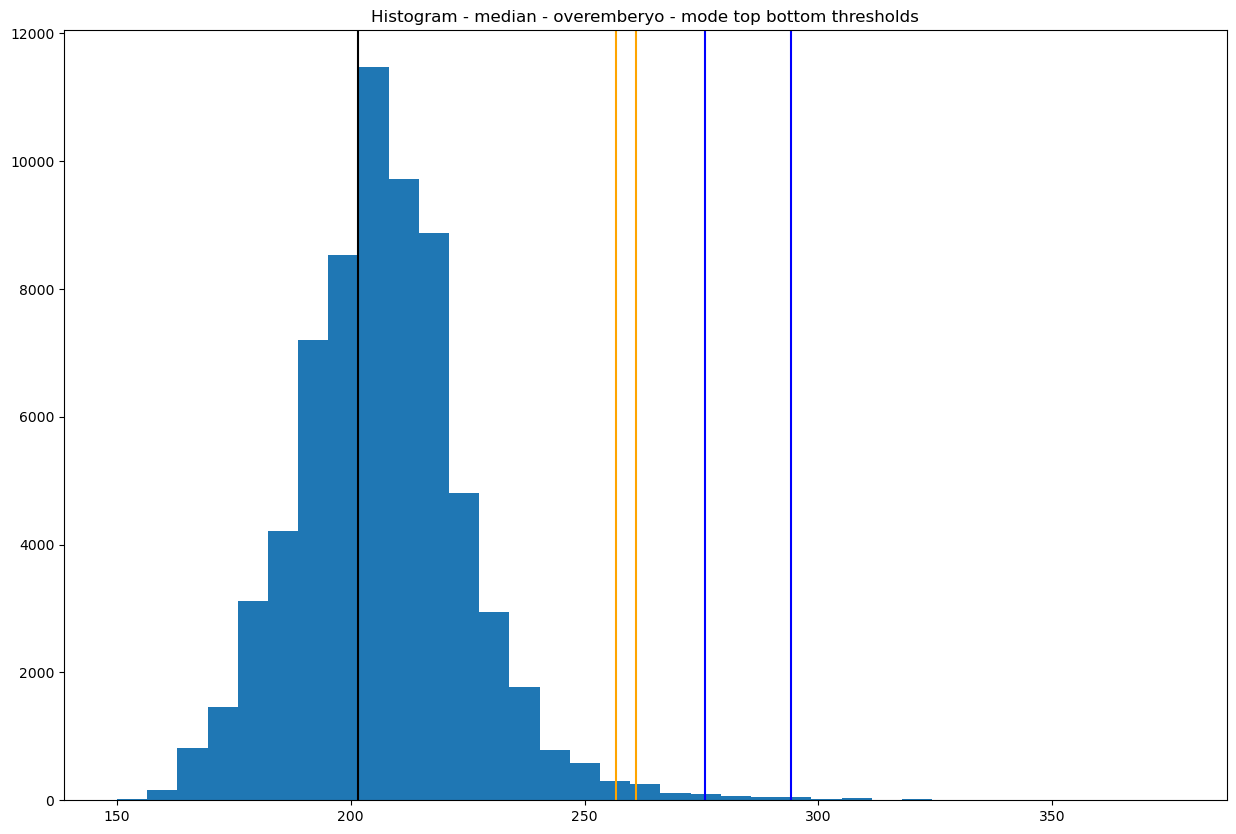

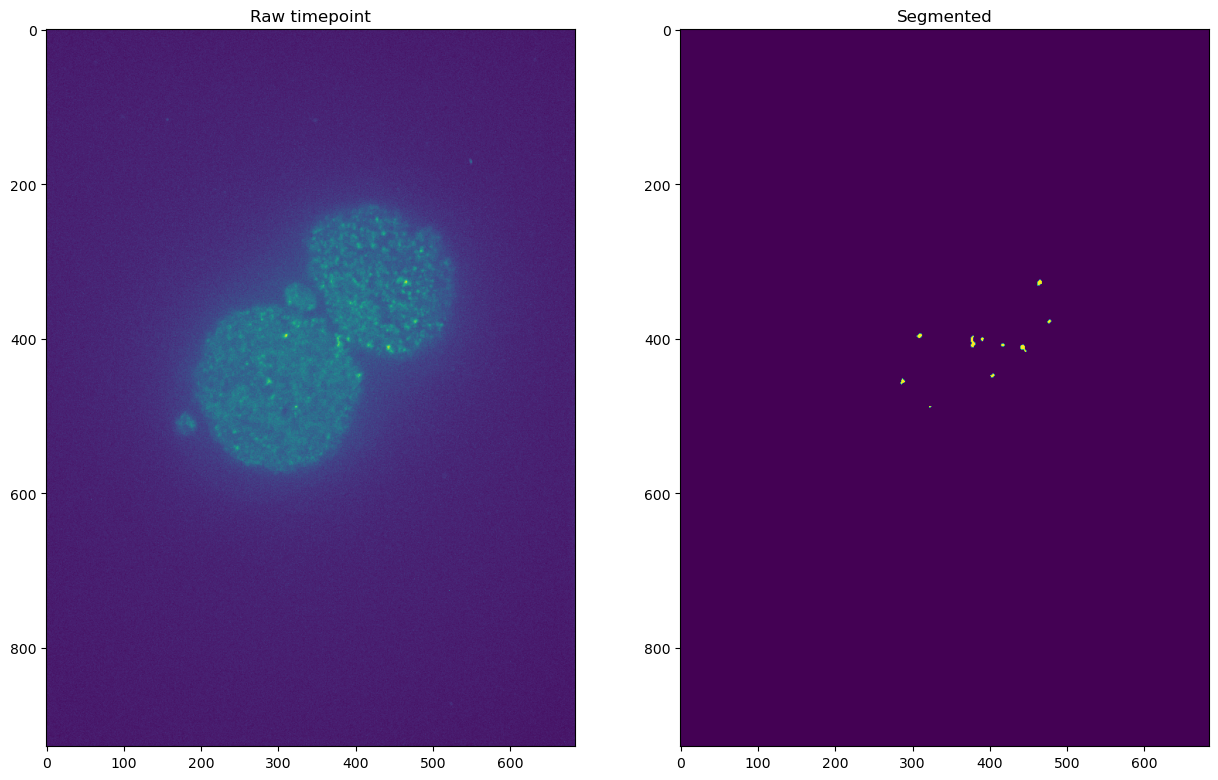

In [30]:

def detect_puncta_structures_wp(timelapse_with_puncta_tmpt, embryo_mask_tmpt, hyst_filt_top_perc, hyst_filt_bot_perc, hyst_filt_top_stdfactor, hyst_filt_bot_stdfactor, use_raw_img_4hyst=None):
    #Median blurr the selected timepoint
    timelapse_with_puncta_tmpt_med = filters.median(timelapse_with_puncta_tmpt)

    #Get the array of pixels in the median-filtered image which are in the embryo mask
    timelapse_with_puncta_tmpt_med_overembryo = timelapse_with_puncta_tmpt_med[embryo_mask_tmpt>0]
    
    #Get picture histogram distribution
    timelapse_with_puncta_tmpt_med_overembryo_hist_counts, timelapse_with_puncta_tmpt_med_overembryo_hist_edges = np.histogram(timelapse_with_puncta_tmpt_med_overembryo, bins=35)
    
    #Get the histogram mode
    mode_posi_ti_on = np.argmax(timelapse_with_puncta_tmpt_med_overembryo_hist_counts)
    mode_inte_n_sit_y_val = timelapse_with_puncta_tmpt_med_overembryo_hist_edges[mode_posi_ti_on]
    
    #Get standard deviation of the intensity values histogram distribution
    histogramdistr_std_dv = np.std(timelapse_with_puncta_tmpt_med_overembryo)

    #Get a putative top threshold based on percentile
    putati_ve__top_thresh_old_i = np.percentile(timelapse_with_puncta_tmpt_med_overembryo, hyst_filt_top_perc)

    if putati_ve__top_thresh_old_i>=(mode_inte_n_sit_y_val+hyst_filt_top_stdfactor*histogramdistr_std_dv):
        putati_ve__top_thresh_old = putati_ve__top_thresh_old_i
    else:
        putati_ve__top_thresh_old = mode_inte_n_sit_y_val+hyst_filt_top_stdfactor*histogramdistr_std_dv

    #Get a putative bottom threshold based on percentile
    putati_ve__bot_thresh_old_i = np.percentile(timelapse_with_puncta_tmpt_med_overembryo, hyst_filt_bot_perc)

    if putati_ve__bot_thresh_old_i>=(mode_inte_n_sit_y_val+hyst_filt_bot_stdfactor*histogramdistr_std_dv):
        putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_i
    else:
        putati_ve__bot_thresh_old = mode_inte_n_sit_y_val+hyst_filt_bot_stdfactor*histogramdistr_std_dv

    if use_raw_img_4hyst!= None and use_raw_img_4hyst!= False:
        # Get a putative thresholded image using hysteresis based thresholding strategy using the raw image instead of the median filtered image
        timelapse_with_puncta_tmpt_hyst_thresh = filters.apply_hysteresis_threshold(timelapse_with_puncta_tmpt, low=putati_ve__bot_thresh_old, high=putati_ve__top_thresh_old)
        
    else:
        # Get a putative thresholded image using hysteresis based thresholding strategy using the median filtered image
        timelapse_with_puncta_tmpt_hyst_thresh = filters.apply_hysteresis_threshold(timelapse_with_puncta_tmpt_med, low=putati_ve__bot_thresh_old, high=putati_ve__top_thresh_old)
    
    #Rescale hysteresis-based binary image on the uint8 value range
    uint8_timelapse_with_puncta_tmpt_hyst_thresh = np.where(timelapse_with_puncta_tmpt_hyst_thresh>0, 255, 0).astype(np.uint8)
    
    #Further remove every puncta which is detected outside the embryo
    final_filtered_img = np.where(embryo_mask_tmpt>0, uint8_timelapse_with_puncta_tmpt_hyst_thresh, 0).astype(np.uint8)

    # #Further remove every puncta which is detected outside the embryo
    # final_filtered_img = np.where(timelapse_with_puncta_tmpt>700, 255, 0).astype(np.uint8)


    fig4000, ax4000 = plt.subplots(1,1, figsize=(15,10))
    ax4000.set_title("Histogram - median - overemberyo - mode top bottom thresholds")
    ax4000.hist(timelapse_with_puncta_tmpt_med_overembryo.flatten(), bins=35)
    ax4000.axvline(x=mode_inte_n_sit_y_val, color="black")
    ax4000.axvline(x=mode_inte_n_sit_y_val+hyst_filt_top_stdfactor*histogramdistr_std_dv, color="blue")
    ax4000.axvline(x=mode_inte_n_sit_y_val+hyst_filt_bot_stdfactor*histogramdistr_std_dv, color="blue")
    ax4000.axvline(x=putati_ve__top_thresh_old_i, color="orange")
    ax4000.axvline(x=putati_ve__bot_thresh_old_i, color="orange")
    # ax4000.set_xlim(1000, 1300) #change this line to slice the histogram graph
    # ax4000.set_ylim(0, 1000) #change this line to slice the histogram graph
    
    fig4001, ax4001 = plt.subplots(1,2, figsize=(15,10))
    ax4001[0].set_title("Raw timepoint")
    ax4001[0].imshow(timelapse_with_puncta_tmpt)
    ax4001[1].set_title("Segmented")
    ax4001[1].imshow(final_filtered_img)


#Select a timepoint to test
selected_tmpnt_ch2 = 1

#Extract the selected timepoint for the farred channel
selected_tmpnt_ch2_img = ch2_timecourse[selected_tmpnt_ch2,:,:]

#Extract the selected timepoint for the thresholded embryo
selected_tmpnt_embryo_img = embryo_timelapse_img[selected_tmpnt_ch2,:,:]


detect_puncta_structures_wp(selected_tmpnt_ch2_img, selected_tmpnt_embryo_img, ch2_top_percentile_hyst_filt, ch2_bot_percentile_hyst_filt, ch2_top_stdv_multfactor_hyst_filt, ch2_bot_stdv_multfactor_hyst_filt, use_raw_img_4hyst=None)



In [37]:
#Iterate through the ch2 (supposedly Cyk1) timecourse to extract putative puncta

puncta_segmentation_on_timecourses(output_folder, ch2_timecourse, embryo_timelapse_img, ch2_top_percentile_hyst_filt, ch2_bot_percentile_hyst_filt, ch2_top_stdv_multfactor_hyst_filt, ch2_bot_stdv_multfactor_hyst_filt, ch2_sav_ing_name, plane_2process)

print("wowowo")


wowowo


SEGMENT ARX2 PUNCTA

Ch1 segmentation - supposedly Arx2

In [38]:
#Import thresholded embryo, thresholded filopodia cyk1 and arx2 images
#Get a list of the files in the input_ output_ folder
list_out_files_4ch1 = listdirNHF(output_folder)
list_inp_files_4ch1 = listdirNHF(input_folder)

# Get the name of the embryo segmented mask for the target plane timecourse
embryo_threshold_target_name_4ch1 = [f2 for f2 in list_out_files_4ch1 if ((embryo_mask_sav_ing_name in f2) and (("pln"+str(plane_2process)) in f2))][0]
#Get the name of the ch3-thresholded mask timecourse (supposely pip2-enriched domains) for the target plane to process (supposely the embryo cortex)
ch3_threshold_name_2target_4ch1 = [f for f in list_out_files_4ch1 if ((ch3_sav_ing_name in f) and (("pln"+str(plane_2process)) in f) and (ch1_sav_ing_name not in f) and (ch2_sav_ing_name not in f) and (embryo_mask_sav_ing_name not in f))][0]
# Get the name of the Ch1 timecourse (supposely arx2 puncta) for the target plane timecourse
ch1_name_2target_4ch1 = [f for f in list_inp_files_4ch1 if ((ch1_target_name in f) and (("pln"+str(plane_2process)) in f) and (ch1_sav_ing_name not in f) and (ch2_sav_ing_name not in f) and (ch3_sav_ing_name not in f) and (embryo_mask_sav_ing_name not in f))][0]
# print(embryo_threshold_target_name_4ch1)
# print(ch3_threshold_name_2target_4ch1)
# print(ch1_name_2target_4ch1)
# print(ch2_name_2target_4ch1)


#Indicate the directories of the thresholded embryo, thresholded filopodia and thresholded protursions time-lapses
embryo_timelapse_dir_4ch1 = os.path.join(output_folder, embryo_threshold_target_name_4ch1)
ch3_threshold_dir_4ch1 = os.path.join(output_folder, ch3_threshold_name_2target_4ch1)
ch1_dir_4ch1 = os.path.join(input_folder, ch1_name_2target_4ch1)



#Open he thresholded embryo, thresholded filopodia and thresholded protursions time-lapses
embryo_timelapse_img_4ch1 = tifffile.imread(embryo_timelapse_dir_4ch1)
print(embryo_timelapse_img_4ch1.shape)

ch3_threshold_timelapse_img_4ch1 = tifffile.imread(ch3_threshold_dir_4ch1)
print(ch3_threshold_timelapse_img_4ch1.shape)

ch1_timecourse_4ch1 = tifffile.imread(ch1_dir_4ch1)
print(ch1_timecourse_4ch1.shape)

ch2_timecourse_4ch1 = tifffile.imread(ch2_dir_4ch1)
print(ch2_timecourse_4ch1.shape)



(61, 928, 684)
(61, 928, 684)
(61, 928, 684)
(61, 928, 684)


In [6]:
#Initialize processing function

def puncta_segmentation_on_timecourses(output_folder_ii, puncta_timecourse, embryo_thresholded_time_course, top_thresh_prcntl, bot_thresh_prcntl, top_thresh_stndrdv, bot_thresh_stndrdv,  chsavingname, processed1plane, use_raw_imgtmpt=None):
    #Initialize a collection list - to be used for forming the array to be saved
    ou_t_pu_t_timecourse_collection = []
    
    #Initialize a position counter
    pnct_tmpnt_counter = 0
    
    #Iterate through the timepoints of the timecourse
    for puncta_t_m_pntt in list(puncta_timecourse):
        
        #Extract the thresholded embryo of current timepoint
        selected_tmpnt_embryo_img = embryo_thresholded_time_course[pnct_tmpnt_counter,:,:]
        
        #Get the binary mask of putative puncta
        puncta_thresholded_tmpnt = detect_puncta_structures(puncta_t_m_pntt, selected_tmpnt_embryo_img, top_thresh_prcntl, bot_thresh_prcntl, top_thresh_stndrdv, bot_thresh_stndrdv, use_raw_imgtmpt)
        
        #Collect the binary mask in the collection list
        ou_t_pu_t_timecourse_collection.append(puncta_thresholded_tmpnt)
    
        #Update the counter
        pnct_tmpnt_counter = pnct_tmpnt_counter + 1
    
    #Transform the collection list in an array
    ou_t_pu_t_timecourse_collection_array = np.asarray(ou_t_pu_t_timecourse_collection).astype(np.uint8)

    #CHANGE THE NAME SAVING
    #Save the final array
    ch_putative_puncta_saving_name = "pln"+ str(processed1plane)+"_"+str(chsavingname)+".tif"
    
    #Save files - uncomment these lines to save the files
    tifffile.imwrite(os.path.join(output_folder_ii, ch_putative_puncta_saving_name), ou_t_pu_t_timecourse_collection_array, photometric='minisblack')

print("wowowo")


wowowo


In [39]:
#Ch1 detection parameters - supposedly Arx2
ch1_top_percentile_hyst_filt = 99.12 #percentile to use for calculating the high value to be passed to hysteresis filtering - suggested 99.5
ch1_bot_percentile_hyst_filt = 98.5 #percentile to use for calculating the low value to be passed to hysteresis filtering - suggested 98
ch1_top_stdv_multfactor_hyst_filt = 4.2 #how many standard deviations to sum to the mode of the intensity distribution, for calculating the high value to be passed to hysteresis filtering - suggested 5
ch1_bot_stdv_multfactor_hyst_filt = 2.9 #how many standard deviations to sum to the mode of the intensity distribution, for calculating the low value to be passed to hysteresis filtering - suggested 3

print("wowowo")


wowowo


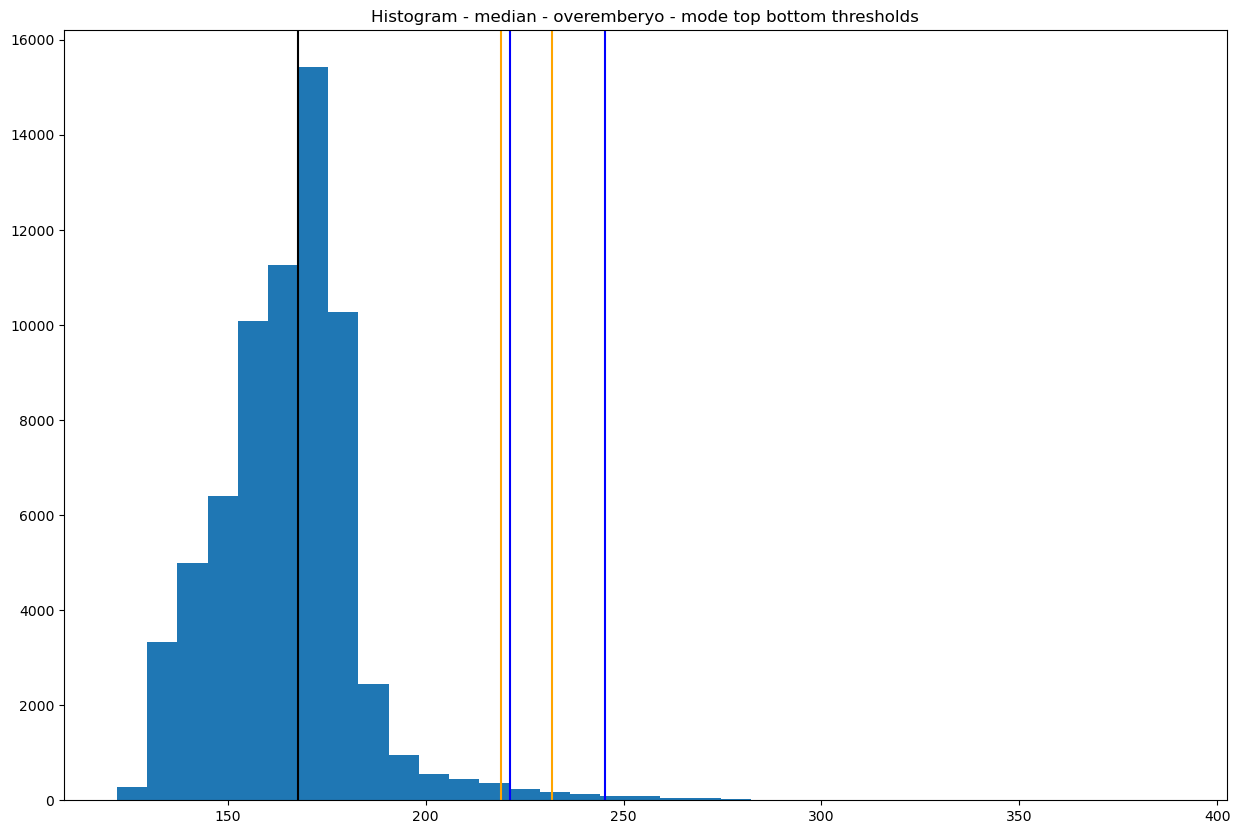

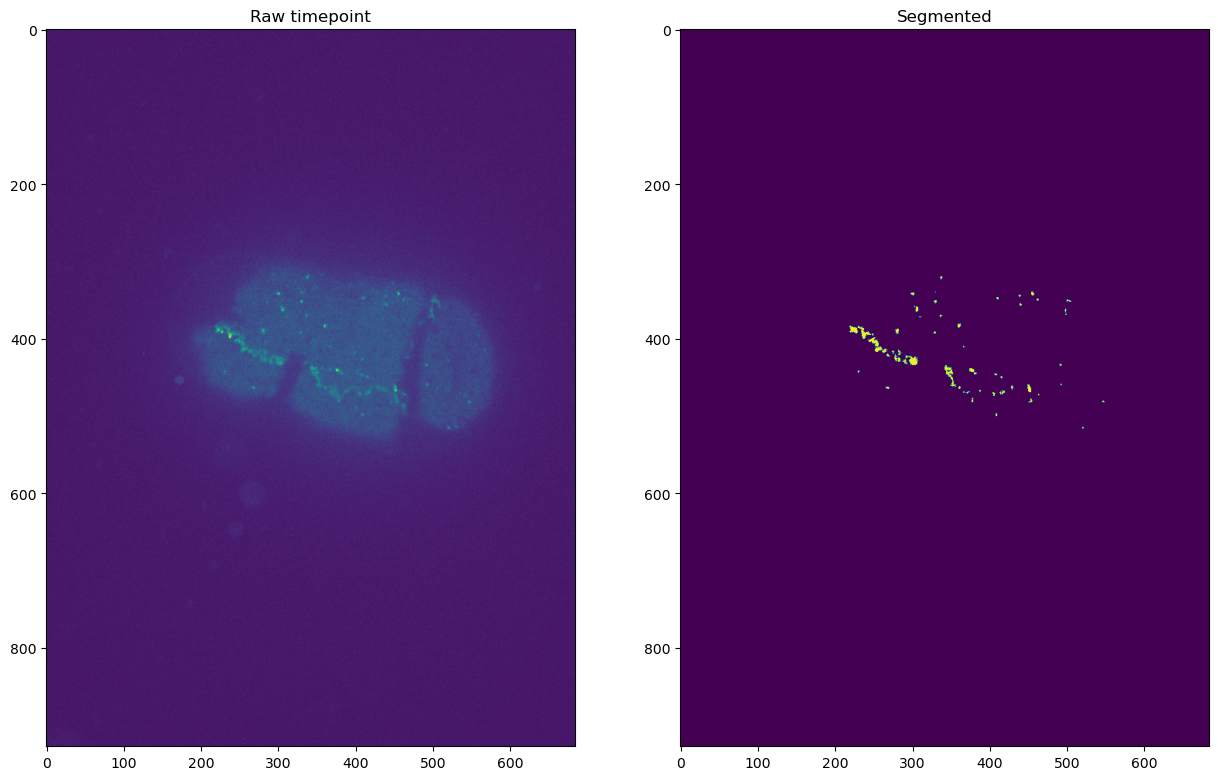

In [13]:

def detect_puncta_structures_wp(timelapse_with_puncta_tmpt, embryo_mask_tmpt, hyst_filt_top_perc, hyst_filt_bot_perc, hyst_filt_top_stdfactor, hyst_filt_bot_stdfactor, use_raw_img_4hyst=None):
    #Median blurr the selected timepoint
    timelapse_with_puncta_tmpt_med = filters.median(timelapse_with_puncta_tmpt)

    #Get the array of pixels in the median-filtered image which are in the embryo mask
    timelapse_with_puncta_tmpt_med_overembryo = timelapse_with_puncta_tmpt_med[embryo_mask_tmpt>0]
    
    #Get picture histogram distribution
    timelapse_with_puncta_tmpt_med_overembryo_hist_counts, timelapse_with_puncta_tmpt_med_overembryo_hist_edges = np.histogram(timelapse_with_puncta_tmpt_med_overembryo, bins=35)
    
    #Get the histogram mode
    mode_posi_ti_on = np.argmax(timelapse_with_puncta_tmpt_med_overembryo_hist_counts)
    mode_inte_n_sit_y_val = timelapse_with_puncta_tmpt_med_overembryo_hist_edges[mode_posi_ti_on]
    
    #Get standard deviation of the intensity values histogram distribution
    histogramdistr_std_dv = np.std(timelapse_with_puncta_tmpt_med_overembryo)

    #Get a putative top threshold based on percentile
    putati_ve__top_thresh_old_i = np.percentile(timelapse_with_puncta_tmpt_med_overembryo, hyst_filt_top_perc)

    if putati_ve__top_thresh_old_i>=(mode_inte_n_sit_y_val+hyst_filt_top_stdfactor*histogramdistr_std_dv):
        putati_ve__top_thresh_old = putati_ve__top_thresh_old_i
    else:
        putati_ve__top_thresh_old = mode_inte_n_sit_y_val+hyst_filt_top_stdfactor*histogramdistr_std_dv

    #Get a putative bottom threshold based on percentile
    putati_ve__bot_thresh_old_i = np.percentile(timelapse_with_puncta_tmpt_med_overembryo, hyst_filt_bot_perc)

    if putati_ve__bot_thresh_old_i>=(mode_inte_n_sit_y_val+hyst_filt_bot_stdfactor*histogramdistr_std_dv):
        putati_ve__bot_thresh_old = putati_ve__bot_thresh_old_i
    else:
        putati_ve__bot_thresh_old = mode_inte_n_sit_y_val+hyst_filt_bot_stdfactor*histogramdistr_std_dv

    if use_raw_img_4hyst!= None and use_raw_img_4hyst!= False:
        # Get a putative thresholded image using hysteresis based thresholding strategy using the raw image instead of the median filtered image
        timelapse_with_puncta_tmpt_hyst_thresh = filters.apply_hysteresis_threshold(timelapse_with_puncta_tmpt, low=putati_ve__bot_thresh_old, high=putati_ve__top_thresh_old)
        
    else:
        # Get a putative thresholded image using hysteresis based thresholding strategy using the median filtered image
        timelapse_with_puncta_tmpt_hyst_thresh = filters.apply_hysteresis_threshold(timelapse_with_puncta_tmpt_med, low=putati_ve__bot_thresh_old, high=putati_ve__top_thresh_old)
    
    #Rescale hysteresis-based binary image on the uint8 value range
    uint8_timelapse_with_puncta_tmpt_hyst_thresh = np.where(timelapse_with_puncta_tmpt_hyst_thresh>0, 255, 0).astype(np.uint8)
    
    #Further remove every puncta which is detected outside the embryo
    final_filtered_img = np.where(embryo_mask_tmpt>0, uint8_timelapse_with_puncta_tmpt_hyst_thresh, 0).astype(np.uint8)

    # #Further remove every puncta which is detected outside the embryo
    # final_filtered_img = np.where(timelapse_with_puncta_tmpt>700, 255, 0).astype(np.uint8)


    fig4002, ax4002 = plt.subplots(1,1, figsize=(15,10))
    ax4002.set_title("Histogram - median - overemberyo - mode top bottom thresholds")
    ax4002.hist(timelapse_with_puncta_tmpt_med_overembryo.flatten(), bins=35)
    ax4002.axvline(x=mode_inte_n_sit_y_val, color="black")
    ax4002.axvline(x=mode_inte_n_sit_y_val+hyst_filt_top_stdfactor*histogramdistr_std_dv, color="blue")
    ax4002.axvline(x=mode_inte_n_sit_y_val+hyst_filt_bot_stdfactor*histogramdistr_std_dv, color="blue")
    ax4002.axvline(x=putati_ve__top_thresh_old_i, color="orange")
    ax4002.axvline(x=putati_ve__bot_thresh_old_i, color="orange")
    # ax4002.set_xlim(1000, 1300) #change this line to slice the histogram graph
    # ax4002.set_ylim(0, 1000) #change this line to slice the histogram graph
    
    fig4003, ax4003 = plt.subplots(1,2, figsize=(15,10))
    ax4003[0].set_title("Raw timepoint")
    ax4003[0].imshow(timelapse_with_puncta_tmpt)
    ax4003[1].set_title("Segmented")
    ax4003[1].imshow(final_filtered_img)


#Select a timepoint to test
selected_tmpnt_ch1 = 60

#Extract the selected timepoint for the farred channel
selected_tmpnt_ch1_img = ch1_timecourse_4ch1[selected_tmpnt_ch1,:,:]

#Extract the selected timepoint for the thresholded embryo
selected_tmpnt_embryo_img = embryo_timelapse_img_4ch1[selected_tmpnt_ch1,:,:]


detect_puncta_structures_wp(selected_tmpnt_ch1_img, selected_tmpnt_embryo_img, ch1_top_percentile_hyst_filt, ch1_bot_percentile_hyst_filt, ch1_top_stdv_multfactor_hyst_filt, ch1_bot_stdv_multfactor_hyst_filt, use_raw_img_4hyst=True)



In [40]:
#Iterate through the ch1 (supposedly Arx2) timecourse to extract putative puncta

puncta_segmentation_on_timecourses(output_folder, ch1_timecourse_4ch1, embryo_timelapse_img_4ch1, ch1_top_percentile_hyst_filt, ch1_bot_percentile_hyst_filt, ch1_top_stdv_multfactor_hyst_filt, ch1_bot_stdv_multfactor_hyst_filt, ch1_sav_ing_name, plane_2process, use_raw_imgtmpt=True)

print("wowowo")


wowowo


BATCH PROCESSING

============== embryo_9
3
finished EMBRYO
(61, 928, 684)
(61, 928, 684)
=== 7 / 61
=== 15 / 61
=== 21 / 61
=== 30 / 61
=== 35 / 61
=== 45 / 61
=== 49 / 61
=== finished initial filtering ===
=== 7 / 61
=== 15 / 61
=== 21 / 61
=== 30 / 61
=== 35 / 61
=== 45 / 61
=== 49 / 61
finished PIP2
(61, 928, 684)
(61, 928, 684)
(61, 928, 684)
finished CYK1
finished ARX2
wowowo


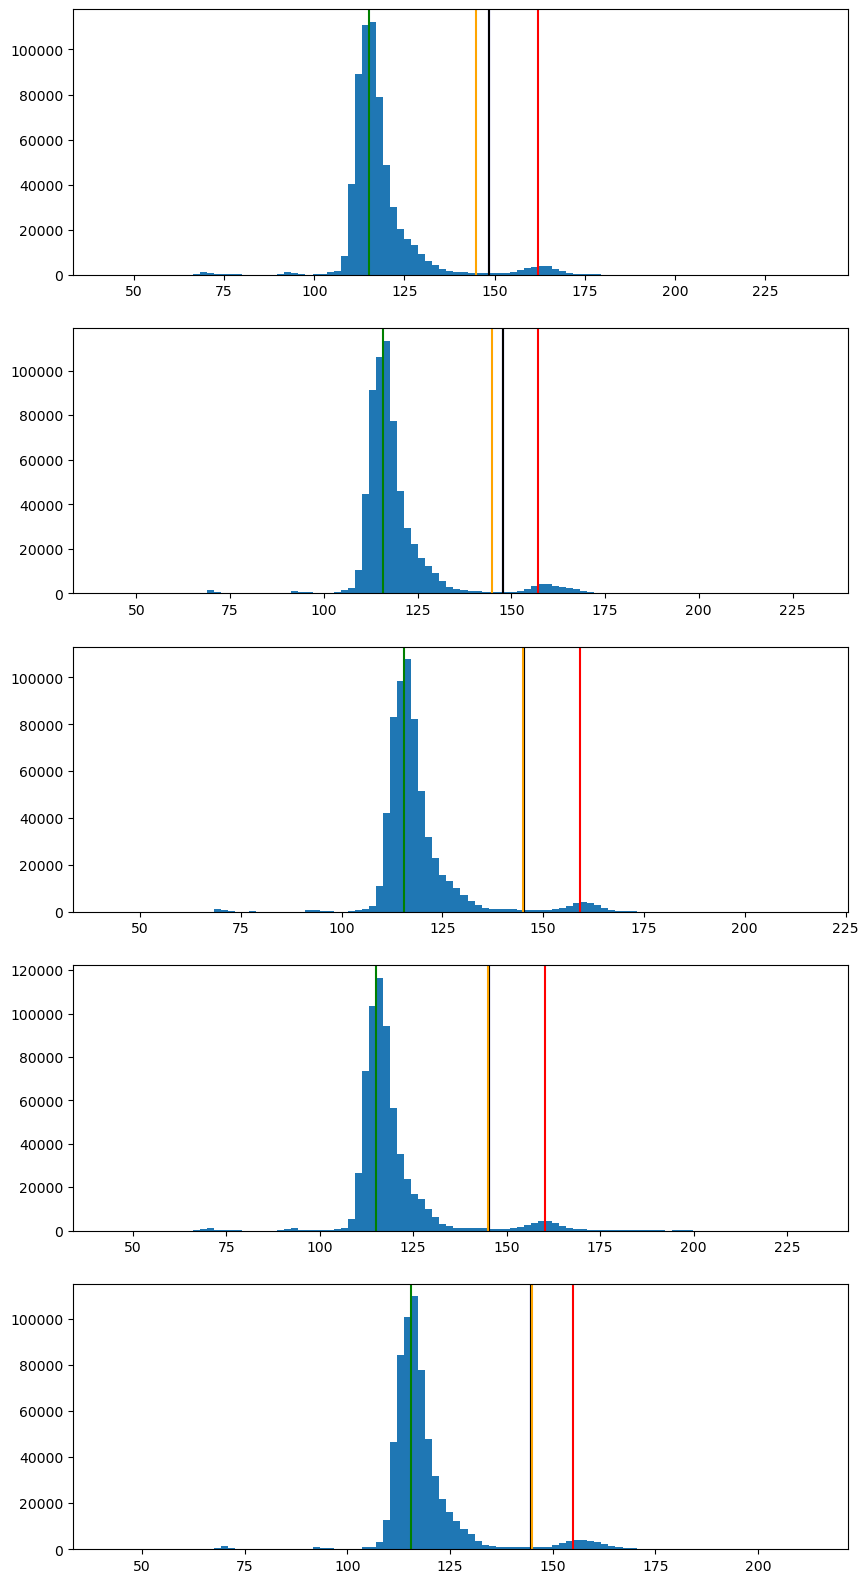

In [41]:

root_input_dir = r"/Users/ulivia/Desktop/Alessandro/projects/filopodia_actin_dynamics_img/output_files_new"

for inout_fldr in listdirNHF(root_input_dir)[-1:]:
    print("==============", inout_fldr)
    inout_fldr_dir = os.path.join(root_input_dir, inout_fldr)
    
    organized_dict, plane_2process = organize_channel_timecourses_get_cortex_plane(inout_fldr_dir, ch1_target_name, ch2_target_name, ch3_target_name, ch1_sav_ing_name, ch2_sav_ing_name, ch3_sav_ing_name, embryo_mask_sav_ing_name)
    print(plane_2process)
    #mask embryo
    #Select the ch3 (supposely pip2-mCherry) timecourse to process (supposely corresponding to embryo cortex)
    ch3_lp_timepoints_list = organized_dict[ch3_target_name][plane_2process]
    
    mask_embryo(ch3_lp_timepoints_list, inout_fldr_dir, ch3_target_name, plane_2process, gau_smooth_sigma_embryo, bin_n_cell_prof, embryo_mask_sav_ing_name, embryo_highpass_area_threshold)
    print('finished EMBRYO')





    
    #Segment ch3 - pip2
    
    #Get a list of the files in the input_output_folder
    list_out_files = listdirNHF(inout_fldr_dir)
    
    #Get the name of the ch3 timecourse (supposely pip2-mCherry) for the target plane to process (supposely the embryo cortex)
    ch3_name_2target = [f for f in list_out_files if ((ch3_target_name in f) and (("pln"+str(plane_2process)) in f) and (ch1_sav_ing_name not in f) and (ch2_sav_ing_name not in f) and (ch3_sav_ing_name not in f) and (embryo_mask_sav_ing_name not in f))][0]
    # Get the name of the embryo segmented mask for the target plane timecourse
    ch3_embryo_target_name = [f2 for f2 in list_out_files if ((embryo_mask_sav_ing_name in f2) and (("pln"+str(plane_2process)) in f2))][0]
    # print(ch3_name_2target)
    # print(ch3_embryo_target_name)
    
    #Create the directories of the channel-3 (pip2-mCherry) and embryo-thresholded files
    ch3_timelapse_dir = os.path.join(inout_fldr_dir, ch3_name_2target)
    ch3_threshold_dir = os.path.join(inout_fldr_dir, ch3_embryo_target_name)
    
    #Open channel-3 (pip2-mCherry) and embryo-thresholded files
    ch3_timalapse_img = tifffile.imread(ch3_timelapse_dir)
    print(ch3_timalapse_img.shape)
    ch3_threshold_img = tifffile.imread(ch3_threshold_dir)
    print(ch3_threshold_img.shape)

    segment_pip2_enriched_domains(inout_fldr_dir, ch3_timalapse_img, ch3_threshold_img, gau_smooth_sigma_fil_rep, bil_smooth_diameter_rep, bil_smooth_sigma_color_rep, bil_smooth_sigma_space_rep, pip2_top_percentile_hyst_filt_rep, pip2_bot_percentile_hyst_filt_rep, pip2_top_stdv_multfactor_hyst_filt_rep, pip2_bot_stdv_multfactor_hyst_filt_rep, frangi_filter_peak_position_rep, highpass_distance_threshold_rep, highpass_area_threshold_rep, ch3_sav_ing_name_rep, plane_2process)
    print('finished PIP2')


    

    
    
    #Import thresholded embryo, thresholded filopodia cyk1 and arx2 images
    #Get a list of the files in the input_output_folder
    list_inpout_files = listdirNHF(inout_fldr_dir)
    
    # Get the name of the embryo segmented mask for the target plane timecourse
    embryo_threshold_target_name = [f2 for f2 in list_inpout_files if ((embryo_mask_sav_ing_name in f2) and (("pln"+str(plane_2process)) in f2))][0]
    #Get the name of the ch3-thresholded mask timecourse (supposely pip2-enriched domains) for the target plane to process (supposely the embryo cortex)
    ch3_threshold_name_2target = [f for f in list_inpout_files if ((ch3_sav_ing_name in f) and (("pln"+str(plane_2process)) in f) and (ch1_sav_ing_name not in f) and (ch2_sav_ing_name not in f) and (embryo_mask_sav_ing_name not in f))][0]
    # Get the name of the Ch1 timecourse (supposely arx2 puncta) for the target plane timecourse
    ch1_name_2target = [f for f in list_inpout_files if ((ch1_target_name in f) and (("pln"+str(plane_2process)) in f) and (ch1_sav_ing_name not in f) and (ch2_sav_ing_name not in f) and (ch3_sav_ing_name not in f) and (embryo_mask_sav_ing_name not in f))][0]
    # Get the name of the Ch2 timecourse (supposely cyk1 puncta) for the target plane timecourse
    ch2_name_2target = [f for f in list_inpout_files if ((ch2_target_name in f) and (("pln"+str(plane_2process)) in f) and (ch1_sav_ing_name not in f) and (ch2_sav_ing_name not in f) and (ch3_sav_ing_name not in f) and (embryo_mask_sav_ing_name not in f))][0]
    
    
    #Indicate the directories of the thresholded embryo, thresholded filopodia and thresholded protursions time-lapses
    embryo_timelapse_dir = os.path.join(inout_fldr_dir, embryo_threshold_target_name)
    ch3_threshold_dir = os.path.join(inout_fldr_dir, ch3_threshold_name_2target)
    ch1_dir = os.path.join(inout_fldr_dir, ch1_name_2target)
    ch2_dir = os.path.join(inout_fldr_dir, ch2_name_2target)
    
    
    #Open he thresholded embryo, thresholded filopodia and thresholded protursions time-lapses
    embryo_timelapse_img = tifffile.imread(embryo_timelapse_dir)
    print(embryo_timelapse_img.shape)
    
    ch3_threshold_timelapse_img = tifffile.imread(ch3_threshold_dir)
    # print(ch3_threshold_timelapse_img.shape)
    
    ch1_timecourse = tifffile.imread(ch1_dir)
    print(ch1_timecourse.shape)
    
    ch2_timecourse = tifffile.imread(ch2_dir)
    print(ch2_timecourse.shape)
    
    #Segment ch2 - cyk1
    puncta_segmentation_on_timecourses(inout_fldr_dir, ch2_timecourse, embryo_timelapse_img, ch2_top_percentile_hyst_filt, ch2_bot_percentile_hyst_filt, ch2_top_stdv_multfactor_hyst_filt, ch2_bot_stdv_multfactor_hyst_filt, ch2_sav_ing_name, plane_2process)
    print("finished CYK1")
    
    #Segment ch1 - arx2
    puncta_segmentation_on_timecourses(inout_fldr_dir, ch1_timecourse, embryo_timelapse_img, ch1_top_percentile_hyst_filt, ch1_bot_percentile_hyst_filt, ch1_top_stdv_multfactor_hyst_filt, ch1_bot_stdv_multfactor_hyst_filt, ch1_sav_ing_name, plane_2process, use_raw_imgtmpt=True)
    print("finished ARX2")





print("wowowo")


